# Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify the file paths
annotation_file_path = 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = 'uniprotdomains.gz'
gene_domain_file_path = 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = 'AlphaMissense_hg38.tsv.gz'
epi25_variants_file_path = 'epi25_variant_results.tsv.gz'
aou_variants_file_path = 'aou_variants.tsv.gz'
genome_coverage_file_path = 'gnomad.genomes.r3.0.1.coverage_0.5_over10_chr2.summary.tsv.gz'

### Sherlock Setup

In [4]:
# project_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/'
data_path = '/oak/stanford/groups/mrivas/projects/multiomics/osthoag/wgs-constraint-llm/'
project_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/'

# Update the file paths
annotation_file_path = data_path + annotation_file_path
variants_file_path = data_path + variants_file_path
coverage_file_path = data_path + coverage_file_path
constraint_file_path = data_path + constraint_file_path
domain_file_path = data_path + domain_file_path
gene_domain_file_path = data_path + gene_domain_file_path
alpha_missense_file_path = data_path + alpha_missense_file_path
epi25_variants_file_path = data_path + epi25_variants_file_path
aou_variants_file_path = project_path + aou_variants_file_path
genome_coverage_file_path = project_path + genome_coverage_file_path

### Colab Setup

(Skip if in Jupyter)

In [13]:
from google.colab import drive

drive_path = '/content/drive'
drive.mount(drive_path)

project_path = drive_path + '/MyDrive/Colab Notebooks/Mutation Prediction/' # Make sure the path to the project is correct

# Update the file paths
annotation_file_path = project_path + annotation_file_path
variants_file_path = project_path + variants_file_path
coverage_file_path = project_path + coverage_file_path
constraint_file_path = project_path + constraint_file_path
domain_file_path = project_path + domain_file_path
gene_domain_file_path = project_path + gene_domain_file_path

# Load data

In [5]:
# Read the file into a pandas DataFrame
domain_df = pd.read_csv(domain_file_path, sep='\t', header=None, 
                        names=['chr', 'start', 'end', 'domain_name', 'frame', 'strand'], 
                        dtype={'start': int, 'end': int})
domain_df

chr   start     end  \
0                          chr1   11994   12024   
1                          chr1   12189   12227   
2                          chr1   12612   12688   
3                          chr1   15799   15808   
4                          chr1   16857   17055   
...                         ...     ...     ...   
207209  chr14_KI270726v1_random   41672   41870   
207210  chr14_KI270726v1_random   41645   41675   
207211  chr14_KI270726v1_random   41678   41870   
207212  chr15_KI270727v1_random  136187  136349   
207213  chr15_KI270727v1_random  386397  387138   

                                            domain_name  frame strand  
0                                                 FHOD1      0      +  
1                                         ATP-dependent      0      +  
2                                         ATP-dependent      0      +  
3                                                 WASH1      0      -  
4                                                 WASH1      0      -  
...                                                 ...    ...    ...  
207209  Ig-like_cds_1_0_chr14_KI270726v1_random_41673_f      0      +  
207210  Ig-like_cds_0_0_chr14_KI270726v1_random_41646_f      0      +  
207211  Ig-like_cds_1_0_chr14_KI270726v1_random_41679_f      0      +  
207212                                    CCDC144C-like      0      -  
207213                                        G-protein      0      +  

[207214 rows x 6 columns]

In [6]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df

chr   source feature   start     end score strand frame  \
60       chr1   HAVANA     CDS   65565   65573     .      +     0   
63       chr1   HAVANA     CDS   69037   70005     .      +     0   
236      chr1   HAVANA     CDS  450743  451678     .      -     0   
304      chr1   HAVANA     CDS  685719  686654     .      -     0   
524      chr1   HAVANA     CDS  924432  924948     .      +     0   
...       ...      ...     ...     ...     ...   ...    ...   ...   
1998488  chrM  ENSEMBL     CDS   10470   10763     .      +     0   
1998495  chrM  ENSEMBL     CDS   10760   12137     .      +     0   
1998509  chrM  ENSEMBL     CDS   12337   14145     .      +     0   
1998515  chrM  ENSEMBL     CDS   14149   14673     .      -     0   
1998523  chrM  ENSEMBL     CDS   14747   15887     .      +     0   

                    gene_id       gene_type gene_name      transcript_id  \
60        ENSG00000186092.7  protein_coding     OR4F5  ENST00000641515.2   
63        ENSG00000186092.7  protein_coding     OR4F5  ENST00000641515.2   
236       ENSG00000284733.2  protein_coding    OR4F29  ENST00000426406.4   
304       ENSG00000284662.2  protein_coding    OR4F16  ENST00000332831.5   
524      ENSG00000187634.13  protein_coding    SAMD11  ENST00000616016.5   
...                     ...             ...       ...                ...   
1998488   ENSG00000212907.2  protein_coding   MT-ND4L  ENST00000361335.1   
1998495   ENSG00000198886.2  protein_coding    MT-ND4  ENST00000361381.2   
1998509   ENSG00000198786.2  protein_coding    MT-ND5  ENST00000361567.2   
1998515   ENSG00000198695.2  protein_coding    MT-ND6  ENST00000361681.2   
1998523   ENSG00000198727.2  protein_coding    MT-CYB  ENST00000361789.2   

              transcript transcript_num transcript_name  
60       ENST00000641515              2       OR4F5-201  
63       ENST00000641515              2       OR4F5-201  
236      ENST00000426406              4      OR4F29-201  
304      ENST00000332831              5      OR4F16-201  
524      ENST00000616016              5      SAMD11-209  
...                  ...            ...             ...  
1998488  ENST00000361335              1     MT-ND4L-201  
1998495  ENST00000361381              2      MT-ND4-201  
1998509  ENST00000361567              2      MT-ND5-201  
1998515  ENST00000361681              2      MT-ND6-201  
1998523  ENST00000361789              2      MT-CYB-201  

[654548 rows x 15 columns]

In [7]:
# Define function to cross join 2 dataframes where the start/end of the rows overlap
def merge_overlapping_intervals(gene_df, domain_df):
    # Rename columns to avoid ambiguity
    shared_columns = gene_df.columns.intersection(domain_df.columns).tolist()
    gene_df_renamed = gene_df.rename(columns={col: 'gene_' + col for col in shared_columns})
    domain_df_renamed = domain_df.rename(columns={col: 'domain_' + col for col in shared_columns})

    # Initialize an empty dataframe to store merged results
    merged_df = pd.DataFrame(columns=gene_df_renamed.columns.union(domain_df_renamed.columns).tolist())

    # Use tqdm to add a progress bar
    for _, gene_row in tqdm(gene_df_renamed.reset_index(drop=True).iterrows(), total=len(gene_df_renamed)):
        # Find overlapping rows in domain_df
        overlapping_rows = domain_df_renamed[
            (domain_df_renamed['domain_start'] <= gene_row['gene_end'])
            & (domain_df_renamed['domain_end'] >= gene_row['gene_start'])
            & (domain_df_renamed['domain_chr'] == gene_row['gene_chr'])
        ]

        # Check if there are overlapping rows
        if not overlapping_rows.empty:
            # Create a new dataframe with merged rows
            merged_rows = pd.concat([gene_row.to_frame().transpose()] * len(overlapping_rows))

            # Reset index of merged_rows and overlapping_rows before concatenation
            merged_rows.reset_index(drop=True, inplace=True)
            overlapping_rows.reset_index(drop=True, inplace=True)

            merged_rows = pd.concat([merged_rows, overlapping_rows], axis=1)

            # Append the merged dataframe to the result
            merged_df = pd.concat([merged_df, merged_rows], ignore_index=True)

    # Update 'start' column based on maximum of 'start' and 'domain_start'
    merged_df['start'] = np.maximum(merged_df['gene_start'], merged_df['domain_start']).astype(int)

    # Update 'end' column based on minimum of 'end' and 'domain_end'
    merged_df['end'] = np.minimum(merged_df['gene_end'], merged_df['domain_end']).astype(int)

    return merged_df

# Check if the joined file already exists
if not os.path.exists(gene_domain_file_path):
    # Filter rows for chr2
    chr2_gene_df = gene_df[gene_df['chr'] == 'chr2']
    chr2_domain_df = domain_df[domain_df['chr'] == 'chr2']
    
    # Merge the dataframes
    gene_domain_df = merge_overlapping_intervals(chr2_gene_df, chr2_domain_df)
    
    # Write gene_domain_df to a csv to avoid recomputing
    gene_domain_df.to_csv(gene_domain_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    gene_domain_df = pd.read_csv(gene_domain_file_path, sep='\t')

gene_domain_df

domain_chr  domain_end  domain_frame  \
0           chr2       45803             0   
1           chr2       46346             0   
2           chr2      247570             0   
3           chr2      234269             0   
4           chr2      234272             0   
...          ...         ...           ...   
62784       chr2   241852954             0   
62785       chr2   241852954             0   
62786       chr2   241852882             0   
62787       chr2   241869914             0   
62788       chr2   241871999             0   

                                      domain_name  domain_start domain_strand  \
0          Centrosome-ass..._cds_0_0_chr2_45477_r         45476             -   
1          Centrosome-ass..._cds_0_0_chr2_46236_r         46235             -   
2                                           Ysc84        247537             -   
3                                           Ysc84        234159             -   
4                                           Ysc84        234159             -   
...                                           ...           ...           ...   
62784                                     Ig-like     241852621             -   
62785            Ig-like_cds_0_0_chr2_241852622_r     241852621             -   
62786  Immunoglobulin..._cds_0_0_chr2_241852625_r     241852624             -   
62787                                        zinc     241869909             +   
62788                                        zinc     241871713             +   

      feature gene_chr   gene_end  gene_frame  ... gene_strand  \
0         CDS     chr2      46385           0  ...           -   
1         CDS     chr2      46385           0  ...           -   
2         CDS     chr2     247602           2  ...           -   
3         CDS     chr2     234272           0  ...           -   
4         CDS     chr2     234272           0  ...           -   
...       ...      ...        ...         ...  ...         ...   
62784     CDS     chr2  241852980           2  ...           -   
62785     CDS     chr2  241852980           2  ...           -   
62786     CDS     chr2  241852980           2  ...           -   
62787     CDS     chr2  241869914           0  ...           +   
62788     CDS     chr2  241873271           1  ...           +   

            gene_type  score  source       transcript       transcript_id  \
0      protein_coding      .  HAVANA  ENST00000327669   ENST00000327669.5   
1      protein_coding      .  HAVANA  ENST00000327669   ENST00000327669.5   
2      protein_coding      .  HAVANA  ENST00000403712   ENST00000403712.6   
3      protein_coding      .  HAVANA  ENST00000403712   ENST00000403712.6   
4      protein_coding      .  HAVANA  ENST00000403712   ENST00000403712.6   
...               ...    ...     ...              ...                 ...   
62784  protein_coding      .  HAVANA  ENST00000334409  ENST00000334409.10   
62785  protein_coding      .  HAVANA  ENST00000334409  ENST00000334409.10   
62786  protein_coding      .  HAVANA  ENST00000334409  ENST00000334409.10   
62787  protein_coding      .  HAVANA  ENST00000343216   ENST00000343216.3   
62788  protein_coding      .  HAVANA  ENST00000343216   ENST00000343216.3   

      transcript_name transcript_num      start        end  
0         FAM110C-201              5      45476      45803  
1         FAM110C-201              5      46235      46346  
2          SH3YL1-205              6     247538     247570  
3          SH3YL1-205              6     234160     234269  
4          SH3YL1-205              6     234160     234272  
...               ...            ...        ...        ...  
62784       PDCD1-201             10  241852621  241852954  
62785       PDCD1-201             10  241852621  241852954  
62786       PDCD1-201             10  241852624  241852882  
62787        RTP5-201              3  241869909  241869914  
62788        RTP5-201              3  241871714  241871999  

[62789 rows x 23 columns]

In [8]:
with gzip.open(coverage_file_path, 'rt') as coverage_file:
    # Read the file into a pandas DataFrame
    coverage_df = pd.read_csv(coverage_file, sep='\t',
                             usecols=['locus', 'over_10', 'over_20'])

# Expand locus column
coverage_df[['chr', 'pos']] = coverage_df['locus'].str.split(':', expand=True)
coverage_df['pos'] = coverage_df['pos'].astype(int)

# Drop the original locus column
coverage_df = coverage_df.drop('locus', axis=1)

coverage_df

over_10  over_20   chr    pos
0          0.00000  0.00000  chr1  11819
1          0.00000  0.00000  chr1  11820
2          0.00000  0.00000  chr1  11821
3          0.00000  0.00000  chr1  11822
4          0.00000  0.00000  chr1  11823
...            ...      ...   ...    ...
170202922  0.29592  0.23756  chrM  16069
170202923  0.29582  0.23788  chrM  16070
170202924  0.29689  0.23808  chrM  16071
170202925  0.29674  0.23815  chrM  16072
170202926  0.29712  0.23825  chrM  16073

[170202927 rows x 4 columns]

In [9]:
# Initialize an empty dataframe to store the concatenated data
variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for chromnum in tqdm(range(1, 23), desc='Processing Chromosomes'):
        # Read the variants file into a pandas DataFrame
        chr_variants_df = pd.read_csv(
            "rgc_me_variant_frequencies_chr" + str(chromnum) + "_20231004.vcf.gz",
            comment='#',
            sep='\t',
            header=None,
            names=['chr', 'pos', 'variant', 'ref', 'alt', 'quality', 'filter', 'info'],
            dtype={'pos': int},
            usecols=[i for i in range(8)]
        )

        # Append the dataframe to the main dataframe
        variants_df = pd.concat([variants_df, chr_variants_df], ignore_index=True)

    # Write gene_domain_df to a csv to avoid recomputing
    variants_df.to_csv(variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    variants_df = pd.read_csv(variants_file_path, sep='\t')

variants_df

chr       pos          variant ref alt quality filter
0           1     69026      1_69026_T_G   T   G       .    svm
1           1     69045      1_69045_A_G   A   G       .    svm
2           1     69072      1_69072_G_A   G   A       .    svm
3           1     69081      1_69081_G_A   G   A       .    svm
4           1     69081      1_69081_G_C   G   C       .    svm
...       ...       ...              ...  ..  ..     ...    ...
45939069   22  50782396  22_50782396_A_C   A   C       .    svm
45939070   22  50782398  22_50782398_C_T   C   T       .    svm
45939071   22  50782401  22_50782401_A_G   A   G       .    svm
45939072   22  50782404  22_50782404_C_A   C   A       .    svm
45939073   22  50782407  22_50782407_C_T   C   T       .    svm

[45939074 rows x 7 columns]

In [10]:
# # Read the data into a DataFrame
# epilepsy_genebass_df = pd.read_csv('Epilepsy_custom.genebass.tsv.gz', sep='\t')
# epilepsy_genebass_df

In [11]:
# Read the file into a pandas DataFrame
constraint_df = pd.read_csv(constraint_file_path, sep='\t', 
                            usecols=['gene', 'transcript', 'mane_select', 'mis.z_score'])

# Compute the MTR
#constraint_df['MTR'] = (constraint_df['mis.obs'] / (constraint_df['mis.obs'] + constraint_df['syn.obs'])) / (constraint_df['mis.exp'] / (constraint_df['mis.exp'] + constraint_df['syn.exp']))

constraint_df

gene       transcript  mane_select  mis.z_score
0       A1BG  ENST00000263100         True     -0.86948
1       A1BG  ENST00000600966        False      0.11131
2       A1BG      NM_130786.4         True     -0.86948
3       A1CF  ENST00000282641        False      1.22810
4       A1CF  ENST00000373993        False      1.24550
...      ...              ...          ...          ...
211267   NaN  ENST00000691540        False      1.42620
211268   NaN  ENST00000691972        False      1.02480
211269   NaN  ENST00000692281        False      2.21410
211270   NaN  ENST00000692585        False     -0.26486
211271   NaN  ENST00000693342        False      0.13518

[211272 rows x 4 columns]

In [12]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

chr       pos ref alt genome uniprot_id             transcript_id  \
0         chr1     69094   G   T   hg38     Q8NH21         ENST00000335137.4   
1         chr1     69094   G   C   hg38     Q8NH21         ENST00000335137.4   
2         chr1     69094   G   A   hg38     Q8NH21         ENST00000335137.4   
3         chr1     69095   T   C   hg38     Q8NH21         ENST00000335137.4   
4         chr1     69095   T   A   hg38     Q8NH21         ENST00000335137.4   
...        ...       ...  ..  ..    ...        ...                       ...   
71697551  chrY  57196925   T   G   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697552  chrY  57196925   T   C   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697553  chrY  57196925   T   A   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697554  chrY  57196926   C   G   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697555  chrY  57196926   C   A   hg38     Q01113  ENST00000244174.10_PAR_Y   

         protein_variant  am_pathogenicity           am_class  \
0                    V2L            0.2937      likely_benign   
1                    V2L            0.2937      likely_benign   
2                    V2M            0.3296      likely_benign   
3                    V2A            0.2609      likely_benign   
4                    V2E            0.2922      likely_benign   
...                  ...               ...                ...   
71697551           F521C            0.1903      likely_benign   
71697552           F521S            0.2045      likely_benign   
71697553           F521Y            0.1440      likely_benign   
71697554           F521L            0.5879  likely_pathogenic   
71697555           F521L            0.5879  likely_pathogenic   

               transcript transcript_num  
0         ENST00000335137              4  
1         ENST00000335137              4  
2         ENST00000335137              4  
3         ENST00000335137              4  
4         ENST00000335137              4  
...                   ...            ...  
71697551  ENST00000244174       10_PAR_Y  
71697552  ENST00000244174       10_PAR_Y  
71697553  ENST00000244174       10_PAR_Y  
71697554  ENST00000244174       10_PAR_Y  
71697555  ENST00000244174       10_PAR_Y  

[71697556 rows x 12 columns]

In [13]:
# # Read the data into a DataFrame
# epi25_variant_results_df = pd.read_csv(epi25_variants_file_path, sep='\t')

# # Split locus into chr and pos and convert to integers
# epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
# # variant_results_df['chr'] = variant_results_df['chr'].str.replace('chr', '').astype(int)
# epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# # Filter out rows
# epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
# epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
#                                                     (epi25_variant_results_df['consequence'] != "non_coding") & 
#                                                     (epi25_variant_results_df['consequence'] != "NA")]
# epi25_variant_results_df

locus    alleles          gene_id        consequence  \
0             chr1:69731  ["T","C"]  ENSG00000186092  damaging_missense   
1             chr1:69731  ["T","C"]  ENSG00000186092  damaging_missense   
8             chr1:69923  ["T","G"]  ENSG00000186092     other_missense   
9             chr1:69928  ["T","A"]  ENSG00000186092  damaging_missense   
10            chr1:69928  ["T","A"]  ENSG00000186092  damaging_missense   
...                  ...        ...              ...                ...   
17246348  chr22:50782272  ["G","A"]  ENSG00000079974     other_missense   
17246349  chr22:50782272  ["G","T"]  ENSG00000079974     other_missense   
17246350  chr22:50782285  ["C","T"]  ENSG00000079974     other_missense   
17246351  chr22:50782286  ["T","G"]  ENSG00000079974     other_missense   
17246352  chr22:50782286  ["T","G"]  ENSG00000079974     other_missense   

             hgvsc        hgvsp     mpc           polyphen group  \
0         c.641T>C  p.Ile214Thr  3.3624  probably_damaging   EPI   
1         c.641T>C  p.Ile214Thr  3.3624  probably_damaging  NAFE   
8         c.833T>G  p.Ile278Ser  2.3070             benign   EPI   
9         c.838T>A  p.Tyr280Asn  4.3167  probably_damaging   EPI   
10        c.838T>A  p.Tyr280Asn  4.3167  probably_damaging  NAFE   
...            ...          ...     ...                ...   ...   
17246348   c.23C>T    p.Pro8Leu     NaN             benign  NAFE   
17246349   c.23C>A    p.Pro8Gln     NaN             benign   EPI   
17246350   c.10G>A    p.Asp4Asn     NaN             benign   EPI   
17246351    c.9A>C    p.Glu3Asp     NaN             benign   EPI   
17246352    c.9A>C    p.Glu3Asp     NaN             benign   GGE   

                  variant_id  ac_case  an_case  ac_ctrl  an_ctrl  estimate  \
0             chr1:69731:T:C        3    37174        0    55408       NaN   
1             chr1:69731:T:C        3    16300        0    55408       NaN   
8             chr1:69923:T:G        1    30002        0    43218       NaN   
9             chr1:69928:T:A        1    30156        0    43308       NaN   
10            chr1:69928:T:A        1    13296        0    43308       NaN   
...                      ...      ...      ...      ...      ...       ...   
17246348  chr22:50782272:G:A        0    18438        1    64916       NaN   
17246349  chr22:50782272:G:T        1    41956        0    64916       NaN   
17246350  chr22:50782285:C:T        1    41954        0    64092       NaN   
17246351  chr22:50782286:T:G        1    41954        0    64054       NaN   
17246352  chr22:50782286:T:G        1    10998        0    64054       NaN   

          chi_sq_stat  p_value in_analysis    chr       pos  
0                 NaN      NaN        True   chr1     69731  
1                 NaN      NaN        True   chr1     69731  
8                 NaN      NaN        True   chr1     69923  
9                 NaN      NaN        True   chr1     69928  
10                NaN      NaN        True   chr1     69928  
...               ...      ...         ...    ...       ...  
17246348          NaN      NaN         NaN  chr22  50782272  
17246349          NaN      NaN         NaN  chr22  50782272  
17246350          NaN      NaN         NaN  chr22  50782285  
17246351          NaN      NaN         NaN  chr22  50782286  
17246352          NaN      NaN         NaN  chr22  50782286  

[11716914 rows x 20 columns]

In [5]:
# Initialize an empty dataframe to store the concatenated data
aou_variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(aou_variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for filenum in tqdm(range(1, 9), desc='Processing Files'):
        # Read the variants file into a pandas DataFrame
        file_variants_df = pd.read_csv(
            "output_prefix_0" + str(filenum) + ".tsv.gz",
            sep='-',
            skiprows=1,
            usecols=[0,1],
            names=['chr', 'pos'],
            dtype={'chr': str, 'pos': int},
        )
        
        file_variants_df.drop_duplicates(inplace=True)

        # Append the dataframe to the main dataframe
        aou_variants_df = pd.concat([aou_variants_df, file_variants_df], ignore_index=True)
    
    # Add chr prefix for consistency
    aou_variants_df['chr'] = 'chr' + aou_variants_df['chr'].astype(str)
    
    # Write aou_variants_df to a csv to avoid recomputing
    aou_variants_df.to_csv(aou_variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    aou_variants_df = pd.read_csv(aou_variants_file_path, sep='\t')

aou_variants_df

reading file


chr       pos
0          chr1     10001
1          chr1     10073
2          chr1     10108
3          chr1     10110
4          chr1     10113
...         ...       ...
934655699  chrY  56887741
934655700  chrY  56887744
934655701  chrY  56887793
934655702  chrY  56887802
934655703  chrY  56887898

[934655704 rows x 2 columns]

# Apply HMM to All of Us Data

In [5]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def fit_and_predict_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


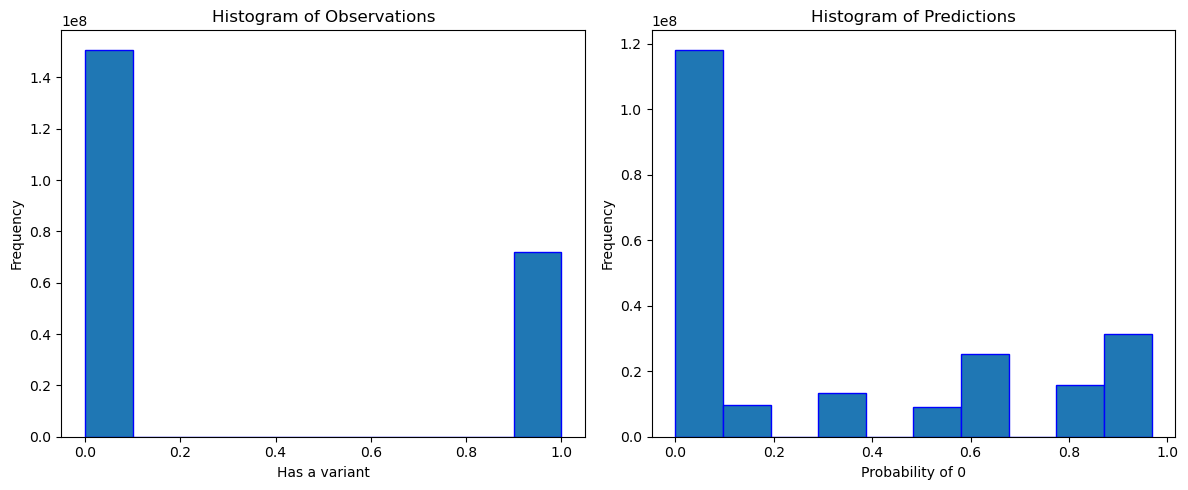

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                 1.044e+08
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:56:01   Log-Likelihood:            -1.0389e+08
No. Observations:           222708440   AIC:                         2.078e+08
Df Residuals:               222708438   BIC:                         2.078e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5406   3.35e-05   1.61e+04      0.0

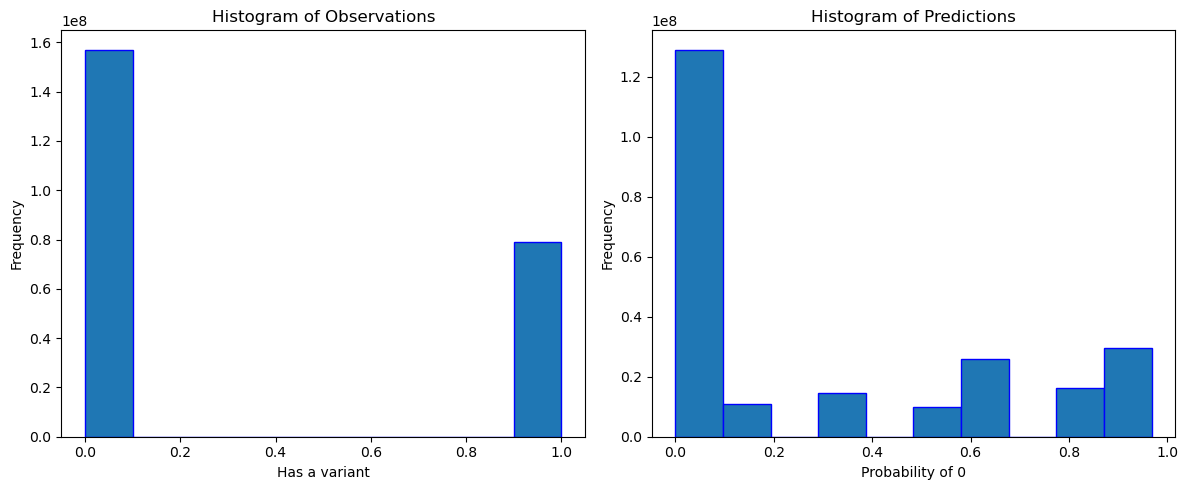

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                 1.076e+08
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        01:57:19   Log-Likelihood:            -1.1312e+08
No. Observations:           235849517   AIC:                         2.262e+08
Df Residuals:               235849515   BIC:                         2.262e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5443   3.25e-05   1.67e+04      0.0

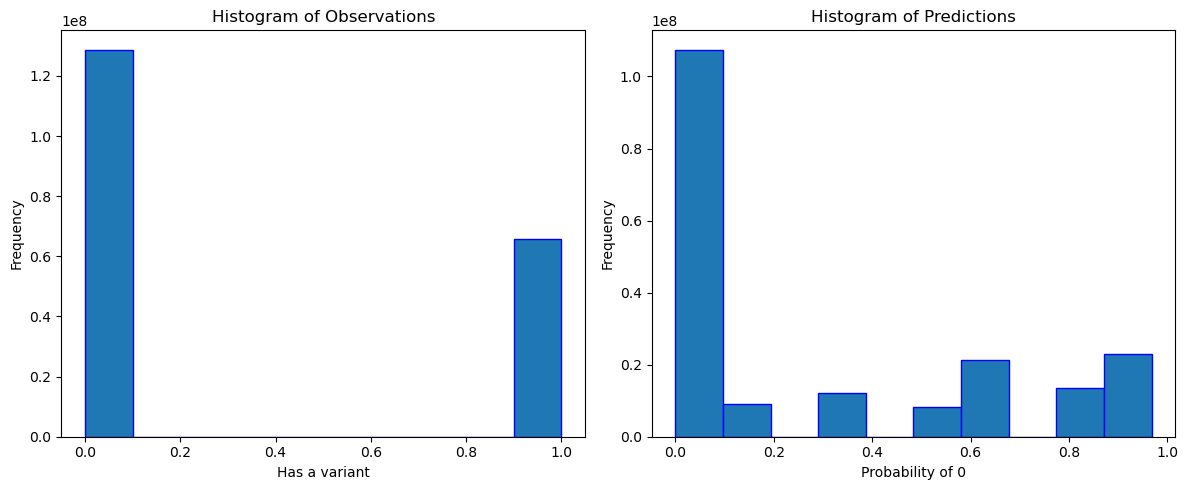

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 8.757e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        02:48:10   Log-Likelihood:            -9.4140e+07
No. Observations:           194410484   AIC:                         1.883e+08
Df Residuals:               194410482   BIC:                         1.883e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5450   3.58e-05   1.52e+04      0.0

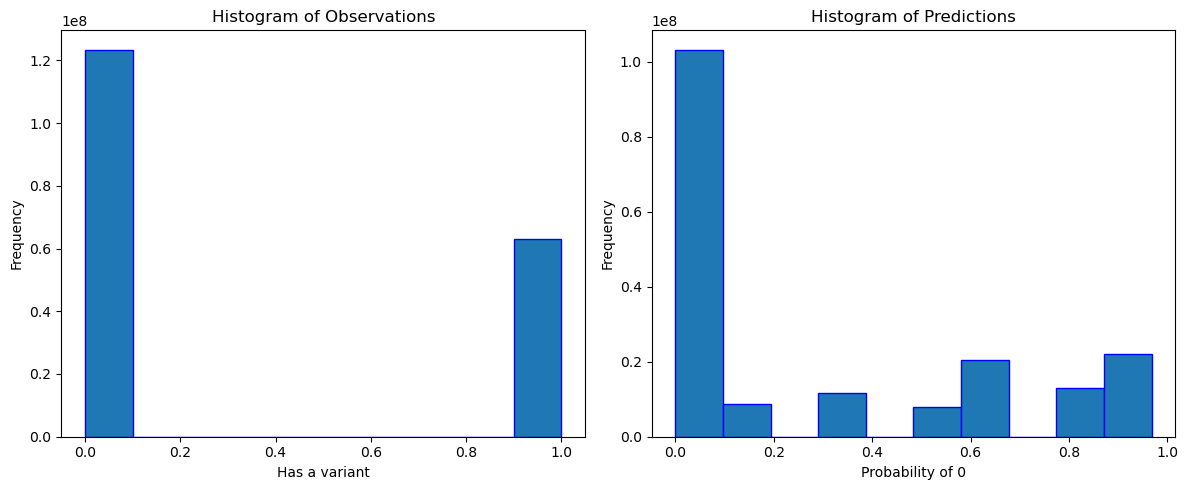

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 8.403e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        03:36:41   Log-Likelihood:            -9.0395e+07
No. Observations:           186503999   AIC:                         1.808e+08
Df Residuals:               186503997   BIC:                         1.808e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5455   3.66e-05   1.49e+04      0.0

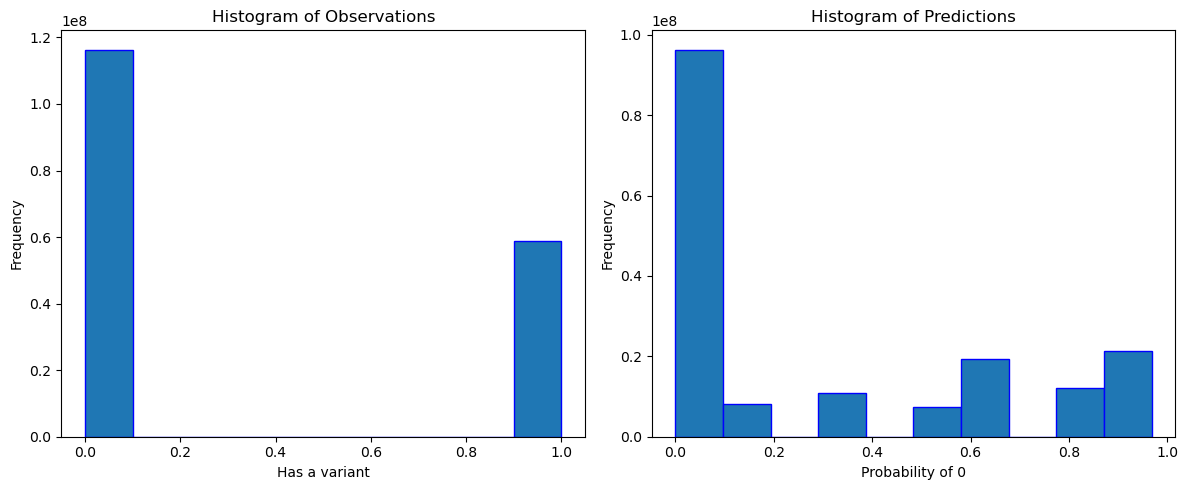

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                 7.944e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        04:22:41   Log-Likelihood:            -8.4407e+07
No. Observations:           175160062   AIC:                         1.688e+08
Df Residuals:               175160060   BIC:                         1.688e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5448   3.77e-05   1.44e+04      0.0

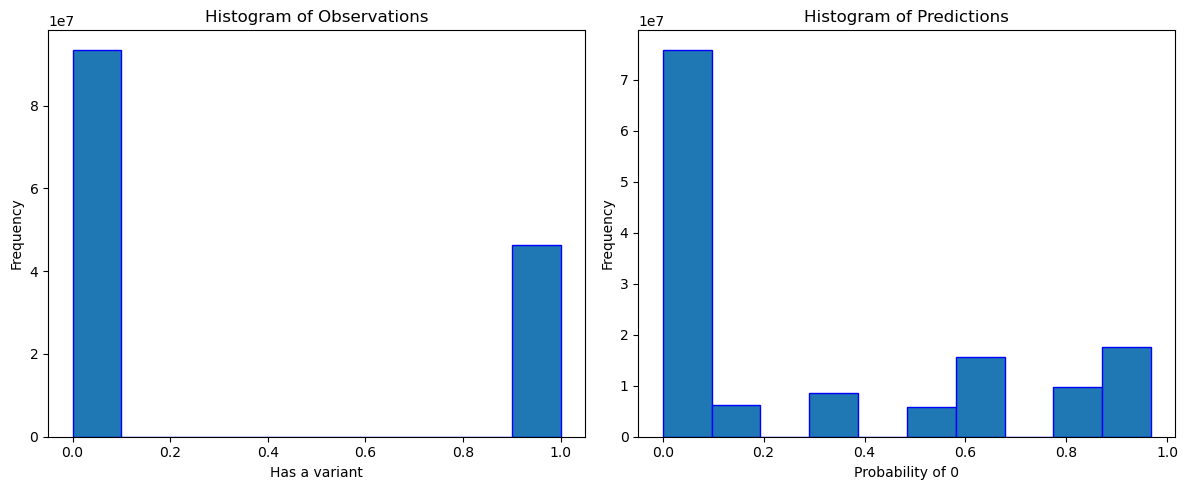

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                 6.408e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        05:00:26   Log-Likelihood:            -6.6606e+07
No. Observations:           139802903   AIC:                         1.332e+08
Df Residuals:               139802901   BIC:                         1.332e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5429   4.23e-05   1.28e+04      0.0

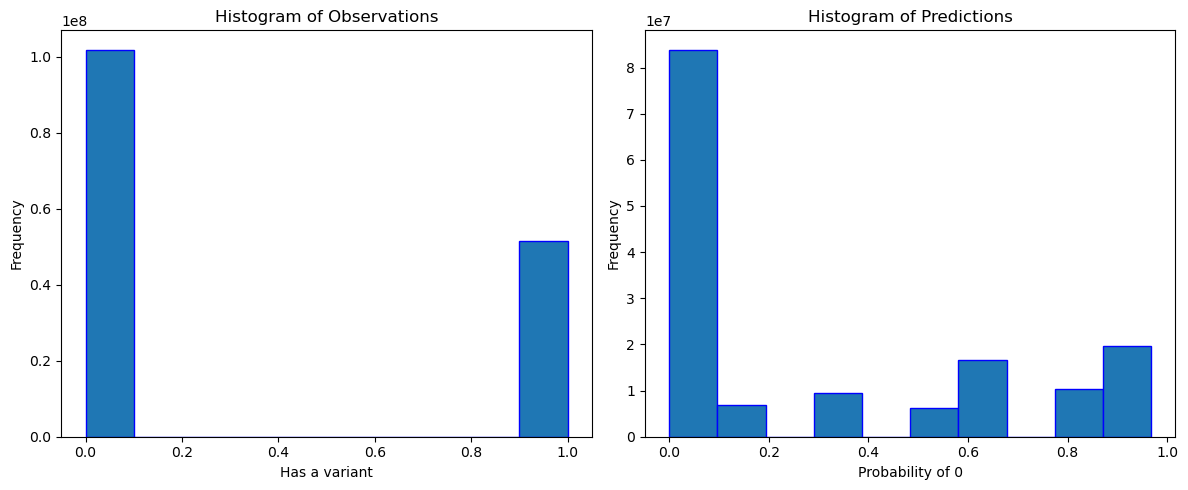

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 7.037e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        05:40:26   Log-Likelihood:            -7.3473e+07
No. Observations:           153247925   AIC:                         1.469e+08
Df Residuals:               153247923   BIC:                         1.469e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5461   4.03e-05   1.35e+04      0.0

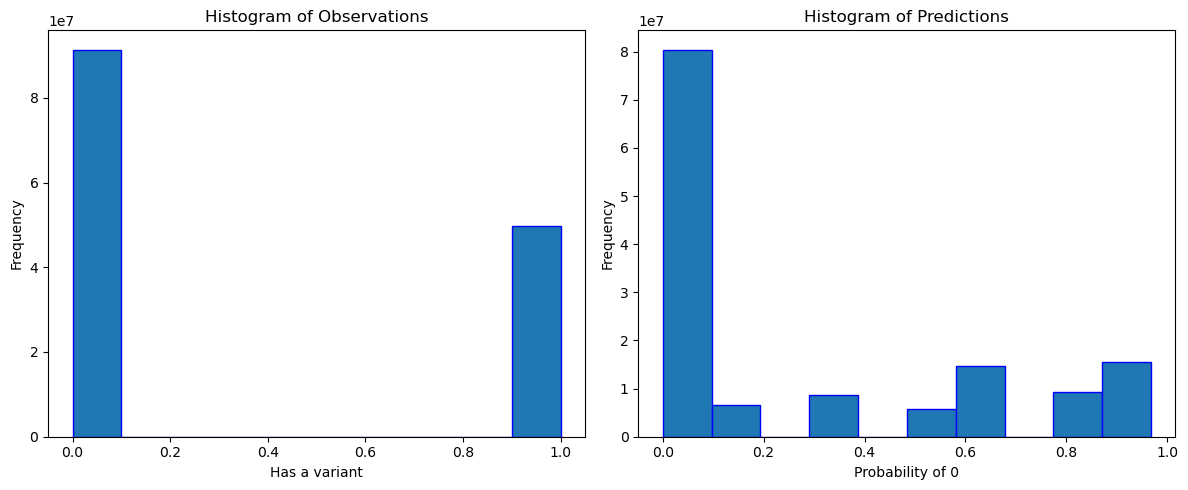

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                 6.297e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:17:39   Log-Likelihood:            -7.0016e+07
No. Observations:           141154640   AIC:                         1.400e+08
Df Residuals:               141154638   BIC:                         1.400e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5540    4.2e-05   1.32e+04      0.0

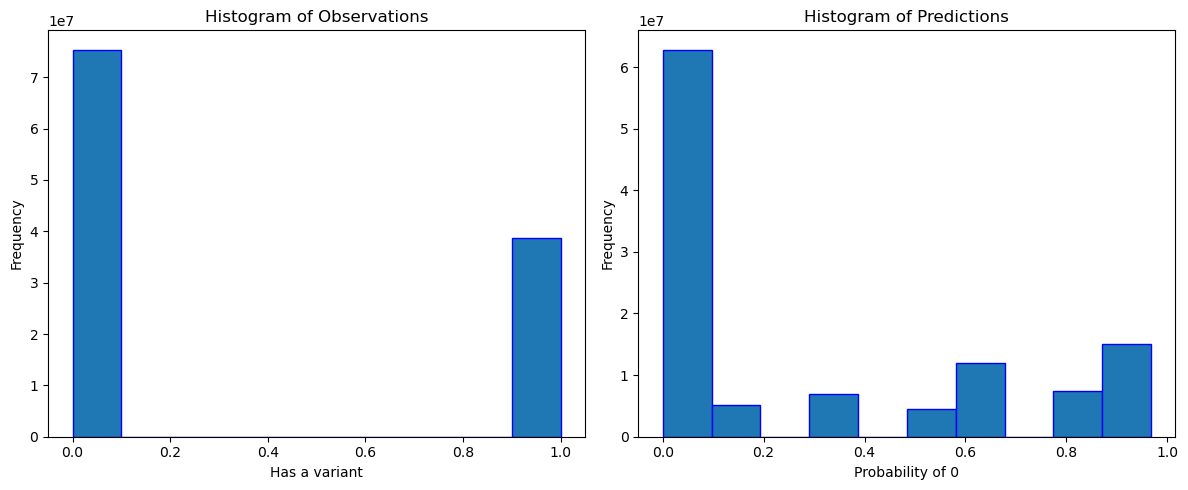

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 5.246e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        06:47:53   Log-Likelihood:            -5.4966e+07
No. Observations:           114050927   AIC:                         1.099e+08
Df Residuals:               114050925   BIC:                         1.099e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5489   4.67e-05   1.17e+04      0.0

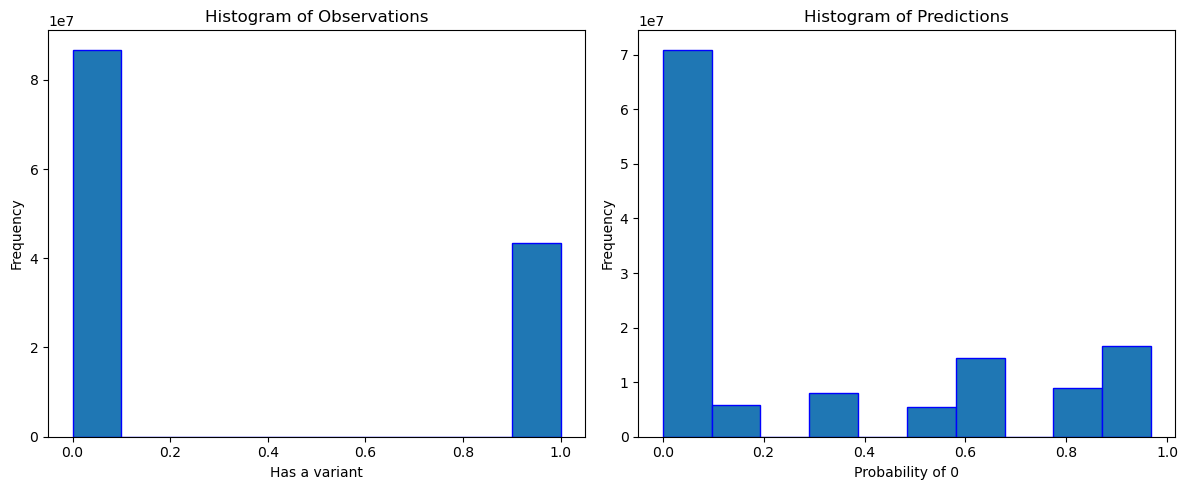

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 5.984e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        07:22:02   Log-Likelihood:            -6.2182e+07
No. Observations:           130137207   AIC:                         1.244e+08
Df Residuals:               130137205   BIC:                         1.244e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5450   4.38e-05   1.24e+04      0.0

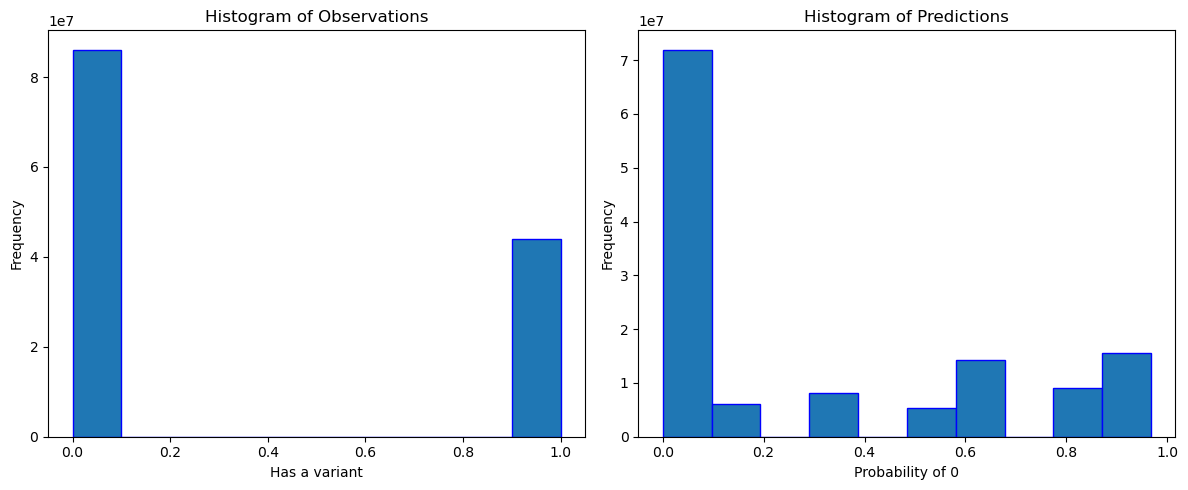

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                 5.896e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        07:57:22   Log-Likelihood:            -6.3006e+07
No. Observations:           130164368   AIC:                         1.260e+08
Df Residuals:               130164366   BIC:                         1.260e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5464   4.38e-05   1.25e+04      0.0

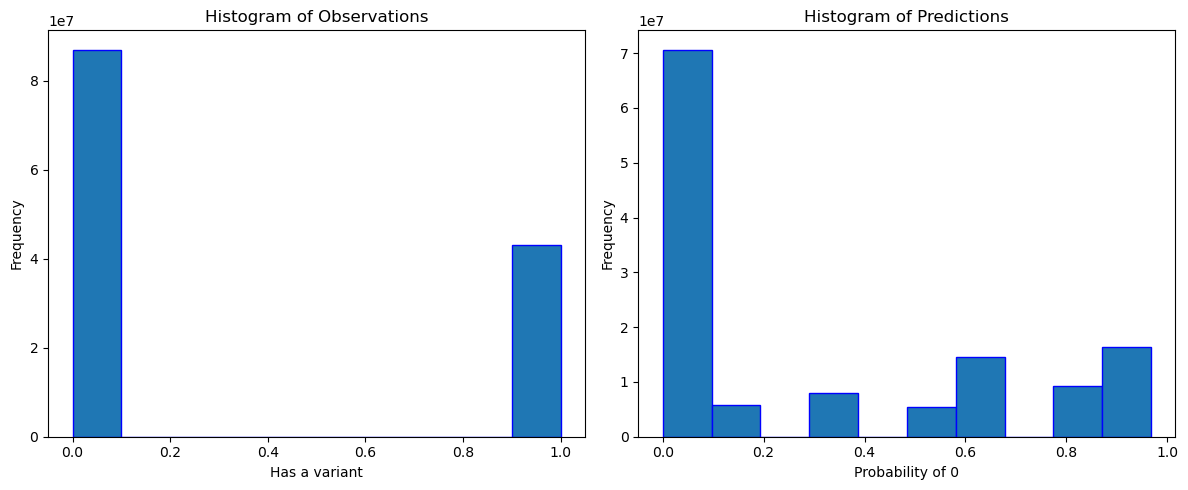

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 5.975e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        08:31:42   Log-Likelihood:            -6.1958e+07
No. Observations:           130087895   AIC:                         1.239e+08
Df Residuals:               130087893   BIC:                         1.239e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5433   4.38e-05   1.24e+04      0.0

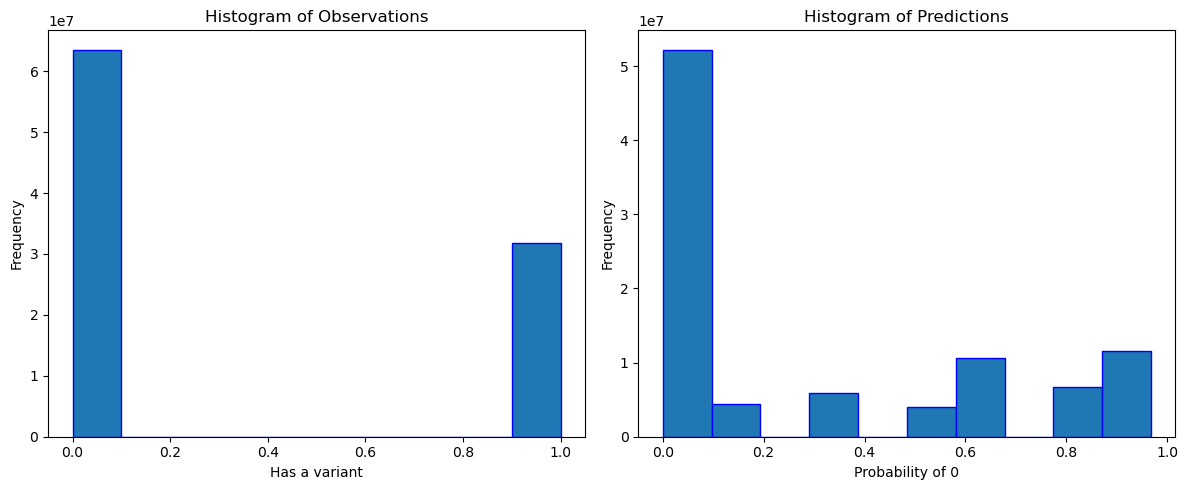

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                 4.328e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        08:57:07   Log-Likelihood:            -4.5797e+07
No. Observations:            95371422   AIC:                         9.159e+07
Df Residuals:                95371420   BIC:                         9.159e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5434   5.12e-05   1.06e+04      0.0

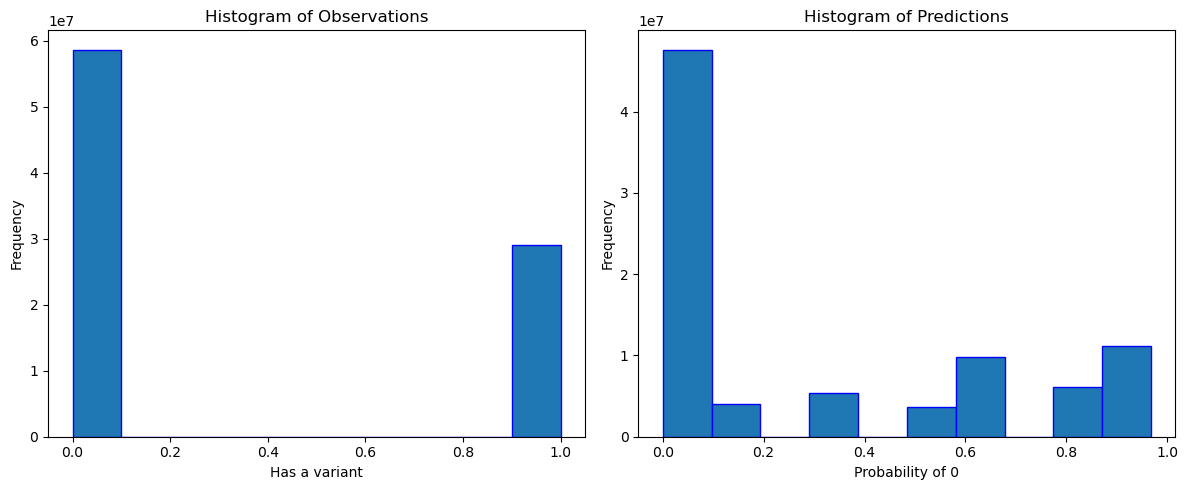

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                 4.014e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:20:34   Log-Likelihood:            -4.1783e+07
No. Observations:            87645371   AIC:                         8.357e+07
Df Residuals:                87645369   BIC:                         8.357e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5429   5.34e-05   1.02e+04      0.0

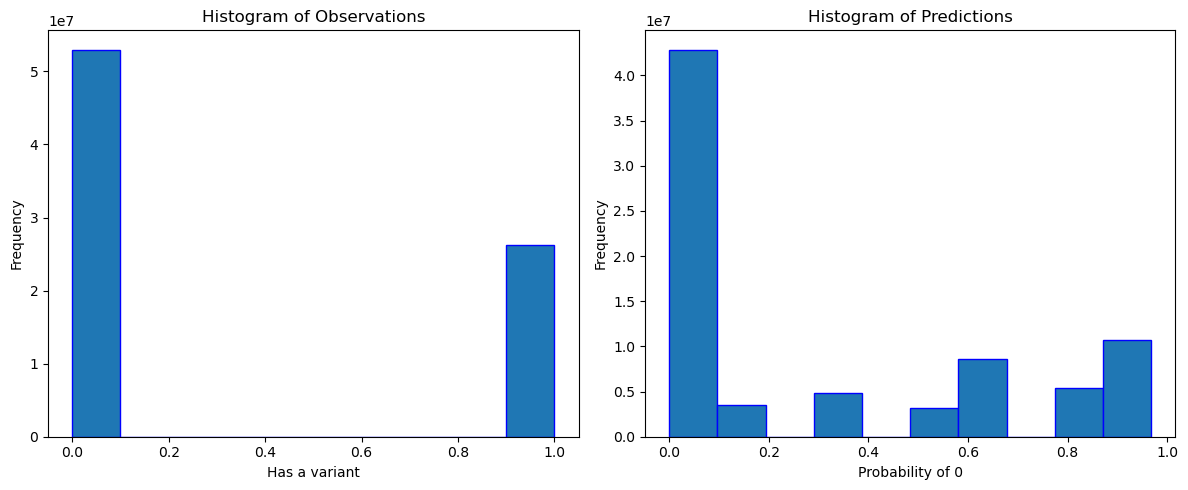

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                 3.667e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        09:41:30   Log-Likelihood:            -3.7592e+07
No. Observations:            79173993   AIC:                         7.518e+07
Df Residuals:                79173991   BIC:                         7.518e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5444   5.62e-05   9694.651      0.0

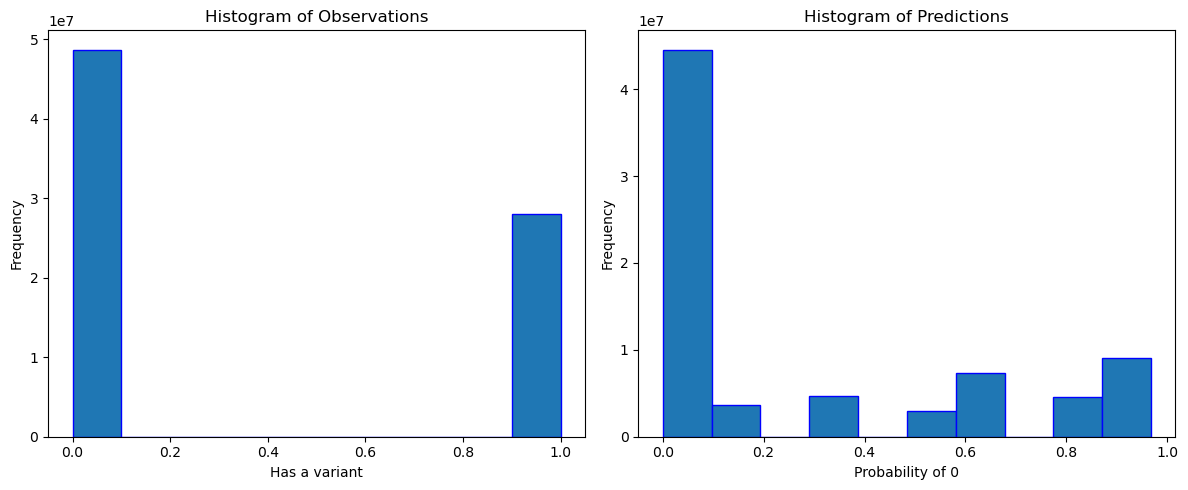

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 3.455e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:01:06   Log-Likelihood:            -3.8522e+07
No. Observations:            76698796   AIC:                         7.704e+07
Df Residuals:                76698794   BIC:                         7.704e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5639   5.68e-05   9930.266      0.0

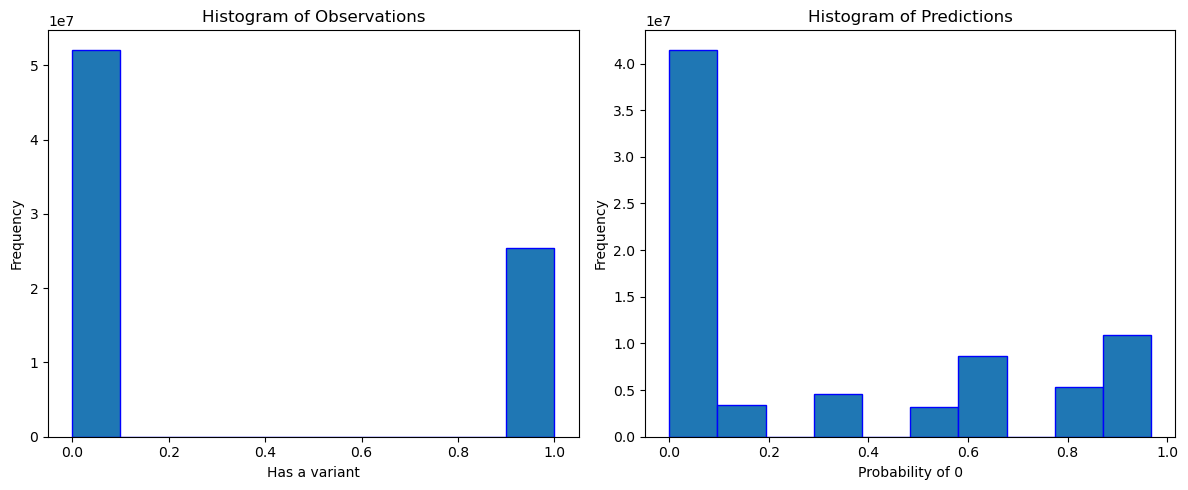

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                 3.663e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:21:44   Log-Likelihood:            -3.6360e+07
No. Observations:            77519347   AIC:                         7.272e+07
Df Residuals:                77519345   BIC:                         7.272e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5450   5.67e-05   9605.464      0.0

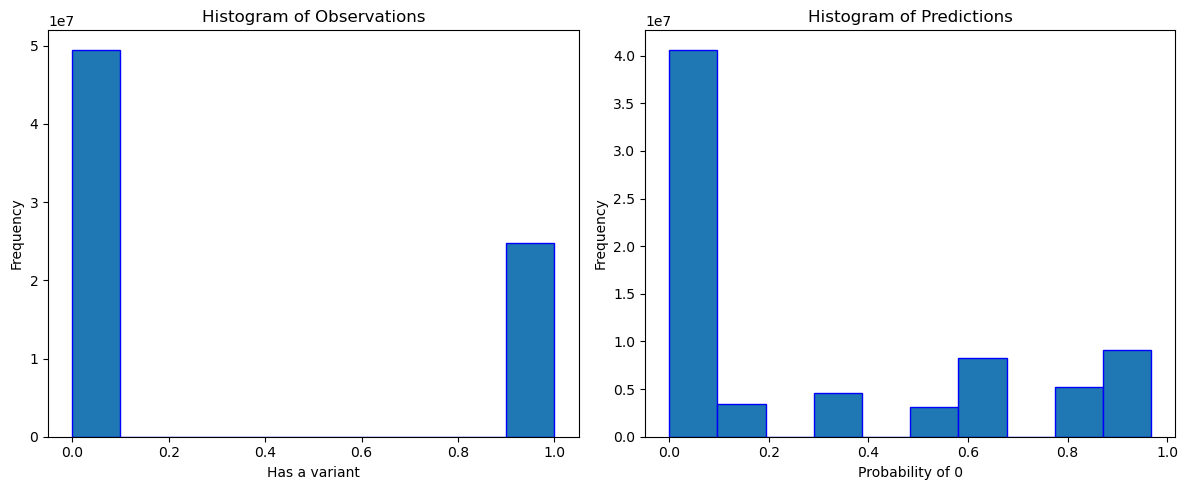

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                 3.380e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:41:49   Log-Likelihood:            -3.5630e+07
No. Observations:            74286945   AIC:                         7.126e+07
Df Residuals:                74286943   BIC:                         7.126e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5437    5.8e-05   9377.005      0.0

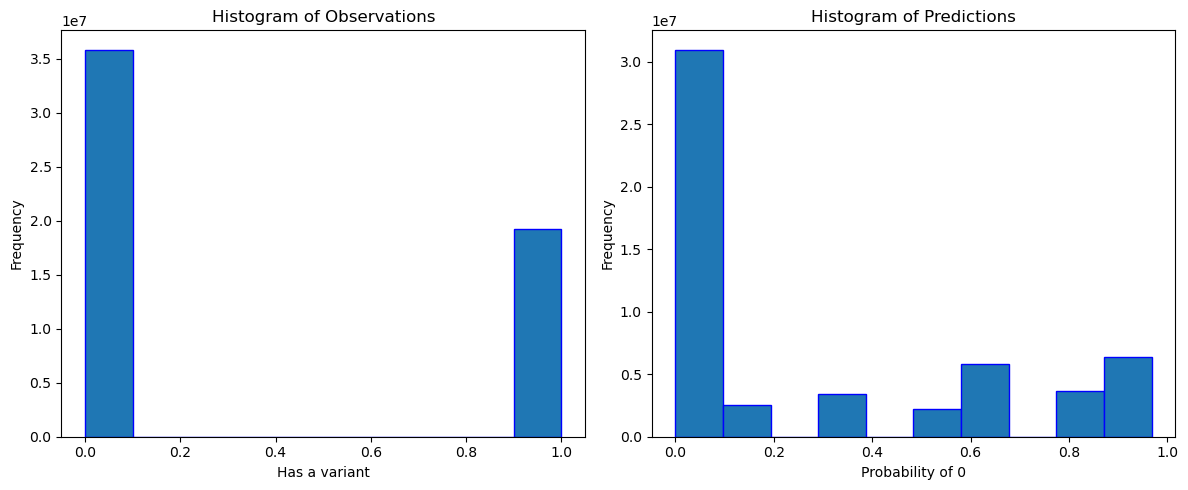

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                 2.517e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:57:26   Log-Likelihood:            -2.6958e+07
No. Observations:            55042757   AIC:                         5.392e+07
Df Residuals:                55042755   BIC:                         5.392e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5549   6.72e-05   8258.302      0.0

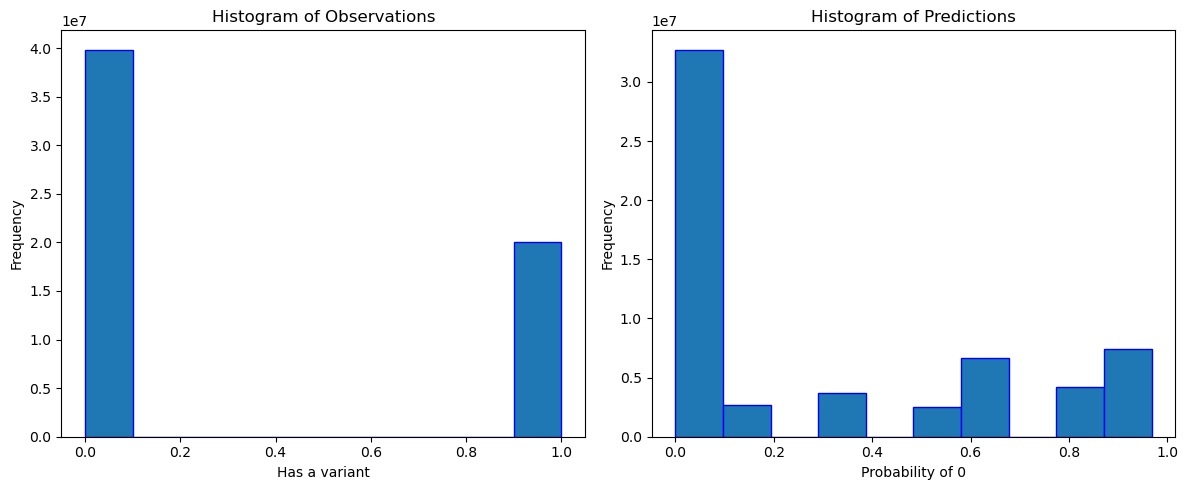

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                 2.746e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:15:09   Log-Likelihood:            -2.8666e+07
No. Observations:            59849788   AIC:                         5.733e+07
Df Residuals:                59849786   BIC:                         5.733e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5454   6.46e-05   8446.269      0.0

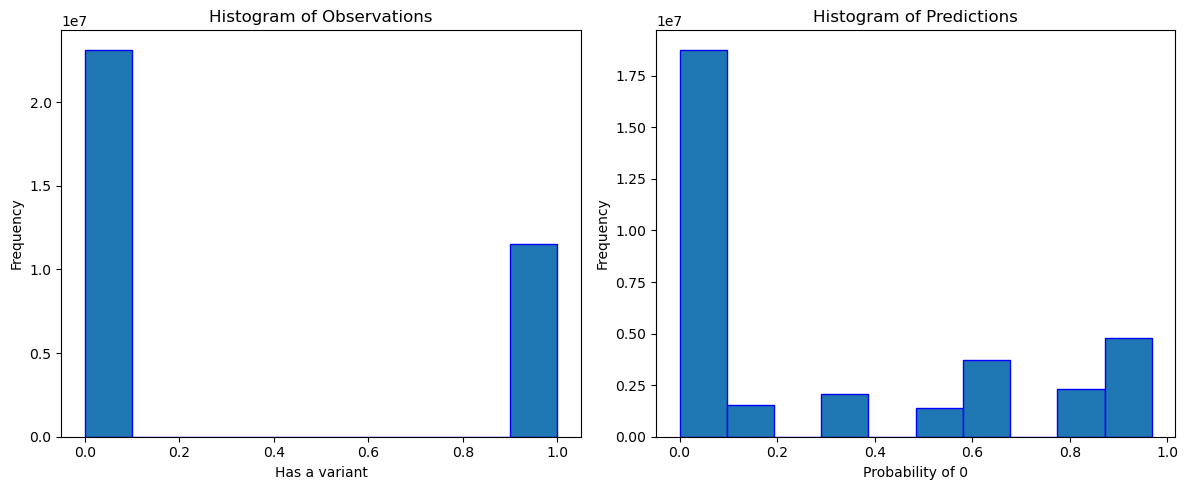

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 1.619e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:25:42   Log-Likelihood:            -1.6446e+07
No. Observations:            34654126   AIC:                         3.289e+07
Df Residuals:                34654124   BIC:                         3.289e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5466   8.48e-05   6442.872      0.0

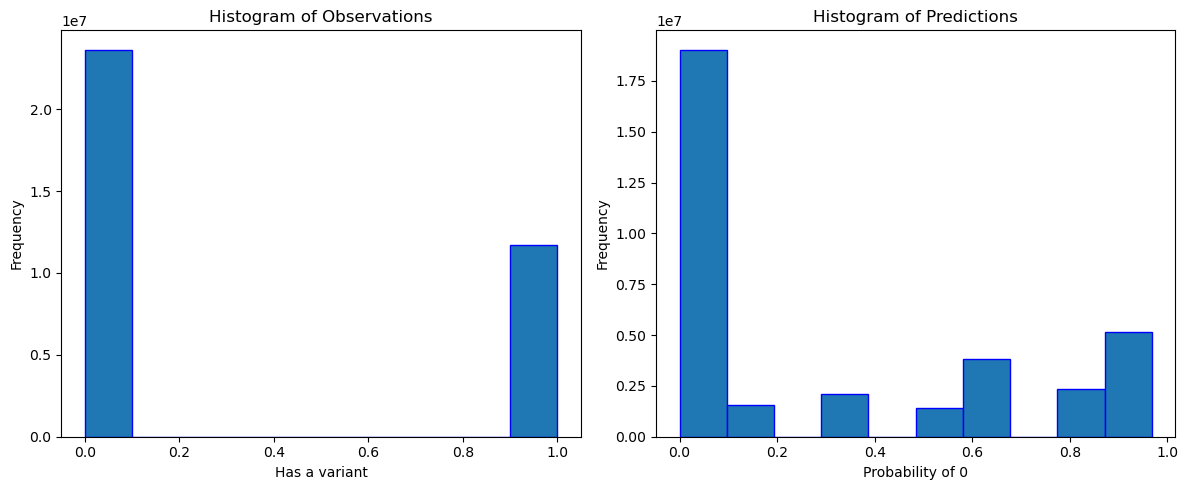

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 1.685e+07
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:36:26   Log-Likelihood:            -1.6655e+07
No. Observations:            35368401   AIC:                         3.331e+07
Df Residuals:                35368399   BIC:                         3.331e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5490   8.39e-05   6540.448      0.0

Empty DataFrame
Columns: [chr, pos, prob_0, prob_1, observation]
Index: []

In [6]:
# Load AoU variants file
aou_variants_df = pd.read_csv(aou_variants_file_path, sep='\t')

# Define pattern for coverage file paths
coverage_file_prefix = project_path + 'gnomad.genomes.r3.0.1.coverage_0.5_over10_chr'
coverage_file_suffix = '.summary.tsv.gz'

# Parameters for analysis
order = 2

# Initialize empty dataframes
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observation'])

# Define path to trained HMM
hmm_file_path = project_path + 'HMM_aou_wgs_chr2_model.joblib'

if os.path.exists(hmm_file_path):
    # Load the pretrained model
    model = joblib.load(hmm_file_path)
    
else:
    # Filter rows for chromosome 2
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(2)]
    chr_coverage_df = pd.read_csv(coverage_file_prefix + str(2) + coverage_file_suffix, sep='\t', names=['pos'])

    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM to Chromosome 2
    model = fit_HMM(observations, order=order)

    # Save the HMM model to a file to avoid retraining
    joblib.dump(model, hmm_file_path)

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(chromnum)]
    chr_coverage_df = pd.read_csv(coverage_file_prefix + str(chromnum) + coverage_file_suffix, sep='\t', names=['pos'])
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Checkpoint chr_predictions_df to a csv to avoid memory bottleneck
    chr_predictions_df.to_csv(project_path + "HMM_aou_constraint_predictions_chr" + str(chromnum) + ".tsv.gz", index=False, compression='gzip', sep='\t')
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
#     # Append predictions to overall df
#     predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)

# # Write predictions_df to a csv to avoid recomputing
# predictions_df.to_csv(project_path + "HMM_aou_constraint_predictions.tsv.gz", index=False, compression='gzip', sep='\t')

predictions_df

In [7]:
chr_predictions_df

chr       pos        prob_0    prob_1  observation
0         chr22  10515803  2.621396e-35  1.000000          0.0
1         chr22  10515804  6.635308e-01  0.336469          0.0
2         chr22  10515805  8.721616e-01  0.127838          0.0
3         chr22  10515806  9.377604e-01  0.062240          0.0
4         chr22  10515807  9.583863e-01  0.041614          0.0
...         ...       ...           ...       ...          ...
35368396  chr22  50808377  8.694705e-01  0.130530          0.0
35368397  chr22  50808379  9.322186e-01  0.067781          0.0
35368398  chr22  50808380  9.458634e-01  0.054137          0.0
35368399  chr22  50808381  9.308014e-01  0.069199          0.0
35368400  chr22  50808382  8.645175e-01  0.135483          0.0

[35368401 rows x 5 columns]

# Fit HMM to Protein-Coding Regions with > 80% Coverage on Chr 2

In [14]:
# Filter rows for chr2
chr2_gene_df = gene_df[gene_df['chr'] == 'chr2']
chr2_coverage_df = coverage_df[coverage_df['chr'] == 'chr2']
chr2_variants_df = variants_df[variants_df['chr'] == 2]

# Get the length of the genetic sequence
sequence_length = max(chr2_gene_df['end'].max(), chr2_coverage_df['pos'].max(), chr2_variants_df['pos'].max())

# Create a boolean mask for the combined protein-coding regions
protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

# Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
for start, end in zip(chr2_gene_df['start'].to_numpy(), chr2_gene_df['end'].to_numpy()):
    protein_coding_mask[start:end+1] = 1

# Filter for >= 80% coverage > 20
chr2_coverage_df = chr2_coverage_df[chr2_coverage_df['over_20'] > 0.80]

# Create boolean mask for exome coverage
coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

# Use NumPy boolean indexing to get mask for positions with over 80% coverage
coverage_mask[chr2_coverage_df['pos'].to_numpy()] = 1

# Convert the position of the variants to a numpy array
variant_pos = chr2_variants_df['pos'].to_numpy()

# Initialize values to zero for all positions
sequence = np.zeros(sequence_length + 1)

# Set positions to 1 where a variant exists
sequence[variant_pos] = 1

# Filter for only the protein-coding regions with over 80% exome coverage
observations = np.array(sequence[protein_coding_mask & coverage_mask])

print("Size of total sequence:", sequence_length)
print("Size of regions with >= 80% coverage > 20:", np.sum(coverage_mask))
print("Size of protein coding-regions:", np.sum(protein_coding_mask))
print("Size of joint regions:", np.sum(protein_coding_mask & coverage_mask))
print("Size of joint regions with variants", np.sum(observations))

Size of total sequence: 242175684
Size of regions with >= 80% coverage > 20: 3443248
Size of protein coding-regions: 2554055
Size of joint regions: 2347389
Size of joint regions with variants 1057841.0


In [15]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set the desired order
order = 2

# Flatten the higher-order structure
X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

# Convert observations to counts
X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

# Create and fit a first-order HMM
model = hmm.MultinomialHMM(n_components=2, random_state=10)
model.fit(X_counts)

# Predict probabilities for each position
probabilities = model.predict_proba(X_counts)

# Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
predictions_df = pd.DataFrame({'pos': np.where(protein_coding_mask & coverage_mask)[0][0:len(observations)-2],
                               'prob_0': probabilities[:, 0], 'prob_1': probabilities[:, 1],
                               'observation' : observations[0:len(observations)-2]})

predictions_df.head()

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


pos        prob_0    prob_1  observation
0  41611  1.551681e-35  1.000000          1.0
1  41612  4.089036e-05  0.999959          1.0
2  41613  4.095493e-05  0.999959          1.0
3  41614  6.455707e-05  0.999935          1.0
4  41615  2.363784e-02  0.976362          1.0

## Summarize results

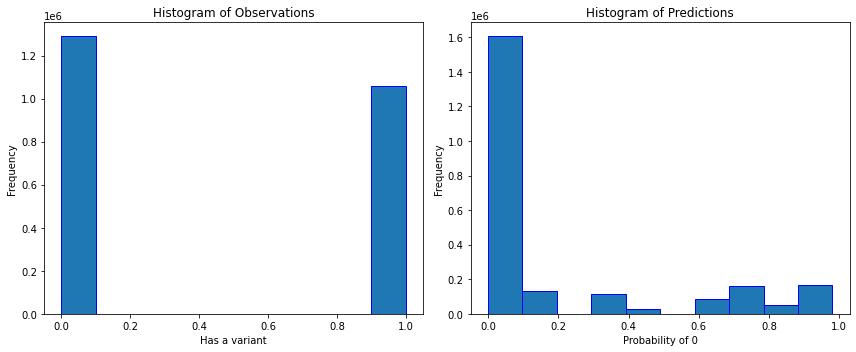

In [23]:
def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
plot_hist_from_predictions(predictions_df)

In [24]:
# Add a constant term to the independent variable for the intercept
X = sm.add_constant(predictions_df['prob_0'])

# Fit the linear regression model
model2 = sm.OLS(predictions_df['observation'],X).fit()

model2.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

# Get the summary of the regression
print(model2.summary())

# Extract the F-statistic and its associated p-value
f_statistic = model2.fvalue
p_value_f_statistic = model2.f_pvalue

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 9.559e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:15:01   Log-Likelihood:            -1.2913e+06
No. Observations:             2347387   AIC:                         2.583e+06
Df Residuals:                 2347385   BIC:                         2.583e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6169      0.000   1914.188      0.0

## Visualize predictions for specific genes

In [25]:
# Filter for the positions with probability > 0.6 of observing a 0
pos_over_60 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()

# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

# Calculate the proportion of each gene with probability > 0.6 of observing a 0
chr2_gene_df['proportion_over_60'] = chr2_gene_df.apply(lambda row: calculate_overlap(row, pos_over_60), axis=1)

# Display the result
chr2_gene_df

chr  source feature      start        end score strand frame  \
193059  chr2  HAVANA     CDS      45440      46385     .      -     0   
193062  chr2  HAVANA     CDS      41611      41627     .      -     2   
193079  chr2  HAVANA     CDS     263984     263984     .      -     0   
193083  chr2  HAVANA     CDS     253005     253115     .      -     2   
193085  chr2  HAVANA     CDS     249731     249844     .      -     2   
...      ...     ...     ...        ...        ...   ...    ...   ...   
341845  chr2  HAVANA     CDS  241894216  241894339     .      -     1   
341852  chr2  HAVANA     CDS  241897186  241897331     .      -     0   
341855  chr2  HAVANA     CDS  241894216  241894339     .      -     1   
341863  chr2  HAVANA     CDS  241897186  241897331     .      -     0   
341866  chr2  HAVANA     CDS  241894216  241894339     .      -     1   

                   gene_id       gene_type gene_name      transcript_id  \
193059   ENSG00000184731.6  protein_coding   FAM110C  ENST00000327669.5   
193062   ENSG00000184731.6  protein_coding   FAM110C  ENST00000327669.5   
193079  ENSG00000035115.22  protein_coding    SH3YL1  ENST00000403712.6   
193083  ENSG00000035115.22  protein_coding    SH3YL1  ENST00000403712.6   
193085  ENSG00000035115.22  protein_coding    SH3YL1  ENST00000403712.6   
...                    ...             ...       ...                ...   
341845   ENSG00000216921.9  protein_coding   FAM240C  ENST00000404031.6   
341852   ENSG00000216921.9  protein_coding   FAM240C  ENST00000452112.5   
341855   ENSG00000216921.9  protein_coding   FAM240C  ENST00000452112.5   
341863   ENSG00000216921.9  protein_coding   FAM240C  ENST00000401641.2   
341866   ENSG00000216921.9  protein_coding   FAM240C  ENST00000401641.2   

             transcript transcript_num transcript_name  proportion_over_60  
193059  ENST00000327669              5     FAM110C-201            0.031712  
193062  ENST00000327669              5     FAM110C-201            0.000000  
193079  ENST00000403712              6      SH3YL1-205            0.000000  
193083  ENST00000403712              6      SH3YL1-205            0.252252  
193085  ENST00000403712              6      SH3YL1-205            0.078947  
...                 ...            ...             ...                 ...  
341845  ENST00000404031              6     FAM240C-202            0.104839  
341852  ENST00000452112              5     FAM240C-203            0.020548  
341855  ENST00000452112              5     FAM240C-203            0.104839  
341863  ENST00000401641              2     FAM240C-201            0.020548  
341866  ENST00000401641              2     FAM240C-201            0.104839  

[50389 rows x 16 columns]

In [26]:
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

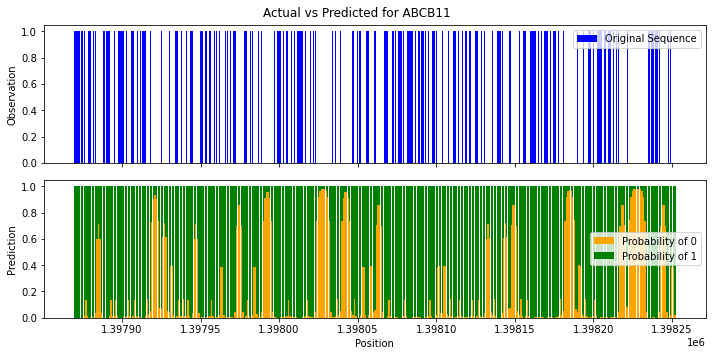

In [27]:
# print(np.where(predictions_df['pos'] == min(gene_df[(gene_df['gene_name'] == "HAT1") ]['start'])))

start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == "ABCB11") ]['start']))[0][0] + 750
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == "ABCB11")]['end']))[0][0] - 2800

plot_subsequence_predictions(start_idx, end_idx, name="ABCB11")

# plt.hist(probabilities[start_idx:end_idx, 0])
# plt.show()

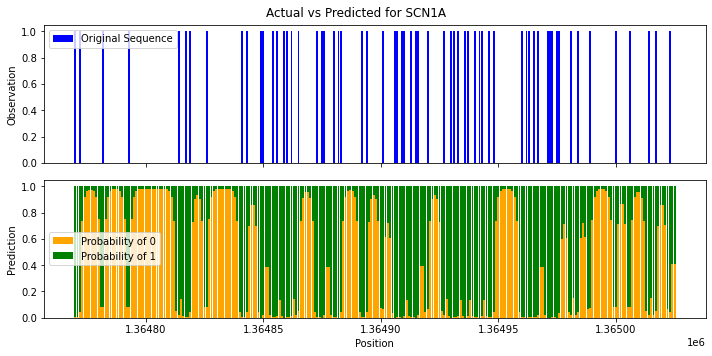

In [28]:
start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == "SCN1A") & (chr2_gene_df['start'].isin(pos_over_60))]['start']))[0][0] + 750
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == "SCN1A") & (chr2_gene_df['end'].isin(pos_over_60))]['end']))[0][0] - 2800 

plot_subsequence_predictions(start_idx, end_idx, name="SCN1A")

## Read protein domains information and summarize across genes


In [31]:
gene_name = "SCN1A"

# Retrieve the gencodeId from your gene_df DataFrame
for i in range(21):
    gencode_id = chr2_gene_df[chr2_gene_df['gene_name'] == gene_name]['gene_id'].iloc[0].split('.')[0] + "."  + str(i)
    
    # GTEx API endpoint for gene expression
    api_url = "https://gtexportal.org/api/v2/expression/medianGeneExpression"

    # Make the API request
    response = requests.get(api_url, params={"gencodeId": gencode_id})

    # Check if the response is successful and the DataFrame is not empty
    if response.status_code == 200 and not pd.DataFrame(response.json()['data']).empty:
        # If DataFrame is not empty, break the loop
        break

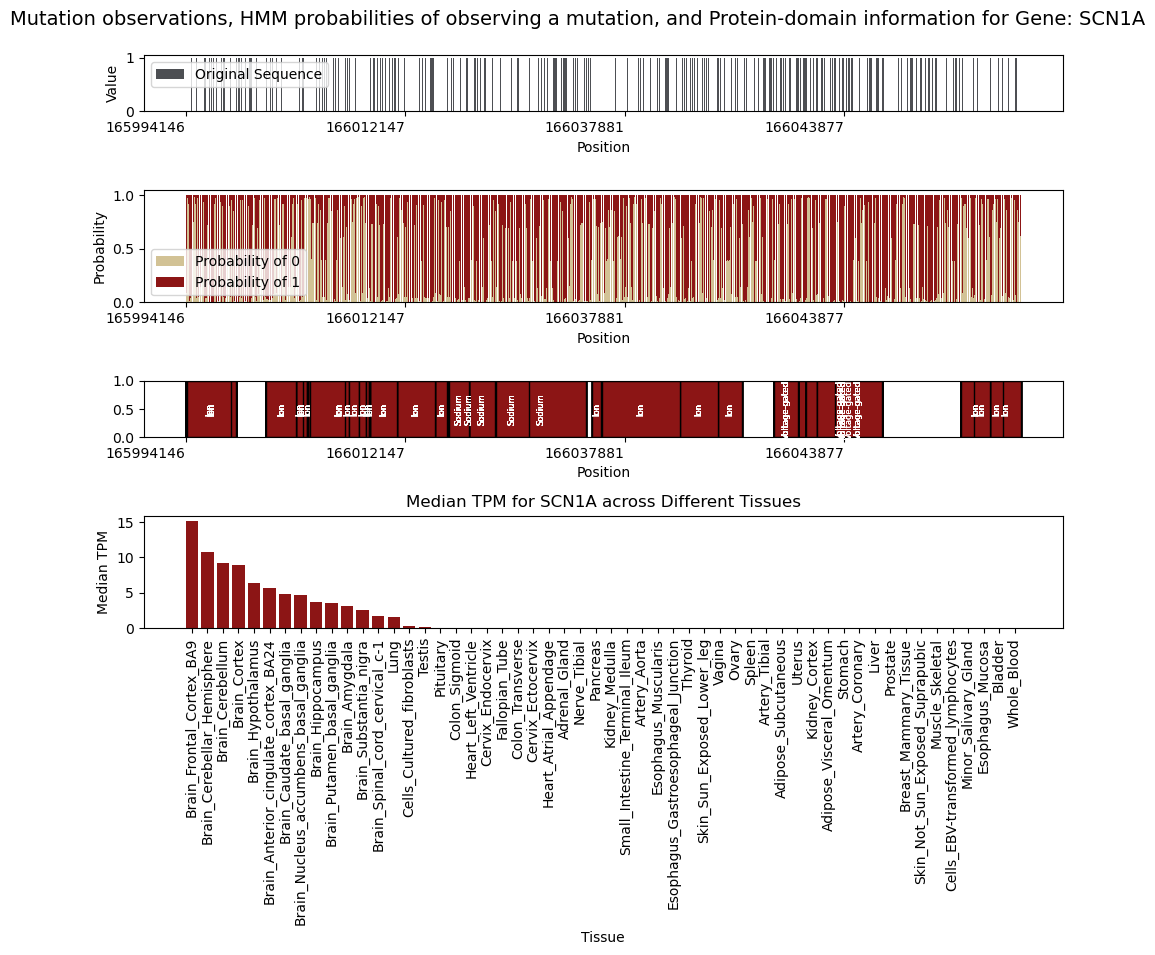

In [35]:
# Reset matplotlib to default, then customize
mpl.rcdefaults()

# Stanford Cardinal inspired color palette
stanford_palette = ['#8C1515', '#D2C295', '#000000', '#4D4F53']  # Cardinal Red, Sandstone, Black, Grey
contrast_blue = '#005AB5'  # A contrasting blue color

# Check if the response is successful
if response.status_code == 200:
    # Load the data into a pandas DataFrame
    expression_data = pd.DataFrame(response.json()['data'])
    # Calculate the median TPM for each tissue
    median_tpm = expression_data.groupby('tissueSiteDetailId')['median'].median().sort_values(ascending=False)
else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")

# Create the title string
title = f"Mutation observations, HMM probabilities of observing a mutation, and Protein-domain information for Gene: {gene_name}"

# Adjust the start and end indices based on your specific conditions
start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == gene_name) & (chr2_gene_df['start'].isin(pos_over_60))]['start']))[0][0]
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == gene_name) & (chr2_gene_df['end'].isin(pos_over_60))]['end']))[0][0]

# Filter gene_domain_df to include only rows overlapping with start_idx and end_idx
overlapping_domains = gene_domain_df[(gene_domain_df['start'] >= predictions_df['pos'][start_idx]) & (gene_domain_df['end'] <= predictions_df['pos'][end_idx])]

# Adjust the subplots to include the fourth plot
fig, axs = plt.subplots(4, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 2, 1, 2]})

#axs[0].bar(predictions_df['pos'][start_idx:end_idx], observations[start_idx:end_idx], color='blue', label='Original Sequence')
axs[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color=stanford_palette[3], label='Original Sequence')

axs[0].set(xlabel='Position', ylabel='Value')
axs[0].legend()

# Plot the predicted probabilities as stacked barplots
axs[1].bar(range(start_idx,end_idx), probabilities[start_idx:end_idx, 0], color=stanford_palette[1], label='Probability of 0')
axs[1].bar(range(start_idx,end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color=stanford_palette[0], label='Probability of 1')

axs[1].set(xlabel='Position', ylabel='Probability')
axs[1].legend()

# Set sparse x-axis labels for axs[0] and axs[1]
sparse_ticks = np.arange(start_idx, end_idx, step=1000)  # Adjust the step value as needed
axs[0].set_xticks(sparse_ticks)
axs[0].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')
axs[1].set_xticks(sparse_ticks)
axs[1].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')


# Convert 'pos' column to numeric type
predictions_df['pos'] = pd.to_numeric(predictions_df['pos'], errors='coerce')

# Get x-axis limits of axs[1]
x_limits = axs[1].get_xlim()

# Set x-axis limits for axs[2]
axs[2].set_xlim(x_limits)

# Add a horizontal rectangle for each overlapping domain to the bottom plot
for _, domain_row in overlapping_domains.iterrows():
    rect_start = np.where((predictions_df['pos'] >=  domain_row['start']) & (predictions_df['pos'] <=  domain_row['end']))
    if len(rect_start[0]) == 0:
        continue
    rect_start = min(rect_start[0])
    rect_end = max(np.where((predictions_df['pos'] >=  domain_row['start']) & (predictions_df['pos'] <=  domain_row['end']))[0])
    rect_width = rect_end - rect_start
    rect_height = 1
    rect = Rectangle((rect_start, 0), rect_width, rect_height, linewidth=1, edgecolor="black", facecolor=stanford_palette[0], label=domain_row['domain_name'])
    axs[2].add_patch(rect)
    # Annotate with smaller font size and 90-degree rotation
    axs[2].annotate(
        domain_row['domain_name'],
        xy=(rect_start + rect_width / 2, 0.5),
        color='white',
        ha='center',
        va='center',
        fontsize=6,  # Set the font size
        rotation=90,  # Rotate text by 90 degrees
    )
axs[2].set(xlabel='Position')
axs[2].set_xticks(sparse_ticks)
axs[2].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')


# Plot the GTEx tissue expression profile
axs[3].bar(median_tpm.index, median_tpm.values, color=stanford_palette[0])
axs[3].set(xlabel='Tissue', ylabel='Median TPM')
axs[3].tick_params(axis='x', rotation=90)  # Rotate tissue names for readability
axs[3].set_title("Median TPM for " + gene_name + " across Different Tissues")

# Add the title
plt.suptitle(title, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
# Calculate the proportion of each gene-domain combination with probability > 0.6 of observing a 0
gene_domain_df['gene_domain_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60), axis=1)

# Calculate the proportion of each gene with probability > 0.6 of observing a 0
gene_domain_df['gene_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60, start_col='gene_start', end_col='gene_end'), axis=1)

# Calculate the proportion of each domain with probability > 0.6 of observing a 0
gene_domain_df['domain_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60, start_col='domain_start', end_col='domain_end'), axis=1)

# Derive length column
gene_domain_df['length'] = abs(gene_domain_df['end'] - gene_domain_df['start']) + 1
chr2_gene_df['length'] = abs(chr2_gene_df['end'] - chr2_gene_df['start']) + 1

# Display the result in different subsets
# gene_domain_df[(gene_domain_df['gene_domain_proportion_over_60'] > .4) & (gene_domain_df['gene_proportion_over_60'] < .2) & (gene_domain_df['length'] > 20)]
# gene_df[gene_df['proportion_over_80'] > .5]['gene_name'].unique()
# chr2_gene_df[chr2_gene_df['proportion_over_60'] > 0.5].sort_values(by='proportion_over_60', ascending=False)
# chr2_gene_df[(chr2_gene_df['proportion_over_60'] > 0.5) & (chr2_gene_df['length'] > 50)]['gene_name'].unique()
# chr2_gene_df[(chr2_gene_df['proportion_over_60'] > 0.5) & (chr2_gene_df['length'] > 50)].sort_values(by='proportion_over_60', ascending=False)

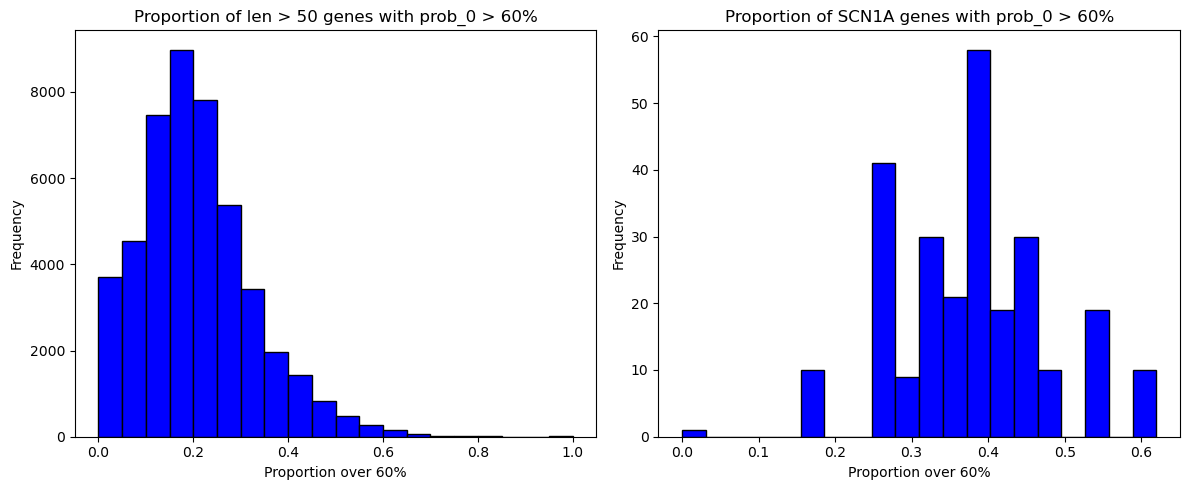

In [39]:
filtered_df = chr2_gene_df[(chr2_gene_df['length'] > 50)]
filtered_df_scn1a = chr2_gene_df[(chr2_gene_df['gene_name'].str.upper() == "SCN1A")]

# Create a figure with two subplots in one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram in the first subplot
axs[0].hist(filtered_df['proportion_over_60'], bins=20, color='blue', edgecolor='black')
axs[0].set_title('Proportion of len > 50 genes with prob_0 > 60%')
axs[0].set_xlabel('Proportion over 60%')
axs[0].set_ylabel('Frequency')

# Plot the second histogram in the second subplot
axs[1].hist(filtered_df_scn1a['proportion_over_60'], bins=20, color='blue', edgecolor='black')
axs[1].set_title('Proportion of SCN1A genes with prob_0 > 60%')
axs[1].set_xlabel('Proportion over 60%')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

## Compare results with Alpha Missense and Epi25

In [25]:
# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()
chr2_alpha_missense_df = alpha_missense_grouped_df[alpha_missense_grouped_df['chr'] == 'chr2']

epi25_variants_chr2_df = epi25_variant_results_df[epi25_variant_results_df['chr'] == "chr2"].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "variant_id", "estimate", "chi_sq_stat", "in_analysis", "chr"])

merged_df = pd.merge(pd.merge(predictions_df, chr2_alpha_missense_df, on='pos', how='inner'), epi25_variants_chr2_df, on='pos', how='inner')

merged_df = merged_df[(merged_df['ac_case'] > 0) & (merged_df['ac_ctrl'] > 0)]

# Calculating odds and log odds ratio
merged_df['odds_case'] = merged_df['ac_case'] / (merged_df['an_case'] - merged_df['ac_case'])
merged_df['odds_ctrl'] = merged_df['ac_ctrl'] / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])
merged_df['effect_size'] = np.log(merged_df['odds_case'] / merged_df['odds_ctrl'])

# Calculating the variance of log odds ratio
merged_df['var_effect_size'] = 1 / merged_df['ac_case'] + 1 / (merged_df['an_case'] - merged_df['ac_case']) + 1 / merged_df['ac_ctrl'] + 1 / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_epi25_chr2_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

pos    prob_0    prob_1  observation   chr  am_pathogenicity  \
0           41612  0.000041  0.999959          1.0  chr2            0.1313   
1           41612  0.000041  0.999959          1.0  chr2            0.1313   
5           41613  0.000041  0.999959          1.0  chr2            0.0848   
7           41613  0.000041  0.999959          1.0  chr2            0.0848   
9           41620  0.009943  0.990057          1.0  chr2            0.2398   
...           ...       ...       ...          ...   ...               ...   
809412  241873188  0.002536  0.997464          1.0  chr2            0.7384   
809413  241873188  0.002536  0.997464          1.0  chr2            0.7384   
809430  241873240  0.002616  0.997384          1.0  chr2            0.7266   
809431  241873240  0.002616  0.997384          1.0  chr2            0.7266   
809432  241873240  0.002616  0.997384          1.0  chr2            0.7266   

                gene_id        consequence group  ac_case  an_case  ac_ctrl  \
0       ENSG00000184731     other_missense   DEE        1     3874        4   
1       ENSG00000184731     other_missense   EPI        1    41920        4   
5       ENSG00000184731               pLoF   EPI        2    41906        2   
7       ENSG00000184731               pLoF  NAFE        2    18428        2   
9       ENSG00000184731     other_missense   EPI        1    41910        2   
...                 ...                ...   ...      ...      ...      ...   
809412  ENSG00000188011  damaging_missense   EPI        1    41958        2   
809413  ENSG00000188011  damaging_missense   GGE        1    10998        2   
809430  ENSG00000188011     other_missense   EPI        3    41956        5   
809431  ENSG00000188011     other_missense   GGE        2    10996        5   
809432  ENSG00000188011     other_missense  NAFE        1    18438        5   

        an_ctrl  p_value  odds_case  odds_ctrl  effect_size  var_effect_size  
0         66836      NaN   0.000258   0.000060     1.461858         1.250273  
1         66836      NaN   0.000024   0.000060    -0.919852         1.250039  
5         66816      NaN   0.000048   0.000030     0.466531         1.000039  
7         66816      NaN   0.000109   0.000030     1.288150         1.000069  
9         66844      NaN   0.000024   0.000030    -0.226316         1.500039  
...         ...      ...        ...        ...          ...              ...  
809412    66888      NaN   0.000024   0.000030    -0.226803         1.500039  
809413    66888      NaN   0.000091   0.000030     1.112220         1.500106  
809430    66770      NaN   0.000072   0.000075    -0.046197         0.533372  
809431    66770      NaN   0.000182   0.000075     0.887539         0.700106  
809432    66770      NaN   0.000054   0.000075    -0.322618         1.200069  

[169274 rows x 18 columns]

In [70]:
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

In [52]:
# Read the data from the file
data = pd.read_csv(project_path + "constraint_am_epi25_chr2_results.tsv.gz", sep='\t')

# Get unique values in the 'gene_id' column
unique_genes = data['gene_id'].unique()

# Initialize lists to store p-values
p_values_prob_0 = []
p_values_am_pathogenicity = []

# Loop over each gene and build a meta-regression model
for current_gene in unique_genes:
    # Subset the data for the current gene
    gene_data = data[data['gene_id'] == current_gene]
    
    # Check if there are at least 2 unique values in the dependent variable
    try:
        # Meta-regression model for the current gene
        X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
        y = np.log(gene_data['effect_size'])
        weights = 1 / np.sqrt(gene_data['var_effect_size'])  # Assuming the weights are based on the square root of var_effect_size

        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Get p-values for prob_0 and am_pathogenicity
        p_value_prob_0 = model.pvalues['prob_0']
        p_value_am_pathogenicity = model.pvalues['am_pathogenicity']

        # Append p-values to lists
        p_values_prob_0.append(p_value_prob_0)
        p_values_am_pathogenicity.append(p_value_am_pathogenicity)
        
    except:
        pass

# Combine p-values using Fisher's method
fisher_combined_p_prob_0 = fisher_method_p_value(np.array(p_values_prob_0))
fisher_combined_p_am_pathogenicity = fisher_method_p_value(np.array(p_values_am_pathogenicity))

# Print combined p-values
print(f"Combined p-value for prob_0: {fisher_combined_p_prob_0}")
print(f"Combined p-value for am_pathogenicity: {fisher_combined_p_am_pathogenicity}")

Combined p-value for prob_0: 0.0
Combined p-value for am_pathogenicity: 0.0


#  Apply HMM to other chromosomes and analyze epilepsy, autism, schizophrenia, and bipolar

## Define helper functions

In [43]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(gene_df, coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(gene_df['end'].max(), coverage_df['pos'].max(), variants_df['pos'].max())

    # Create a boolean mask for the combined protein-coding regions
    protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
    for start, end in zip(gene_df['start'].to_numpy(), gene_df['end'].to_numpy()):
        protein_coding_mask[start:end+1] = 1

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[protein_coding_mask & coverage_mask])
    
    positions = np.where(protein_coding_mask & coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def fit_and_predict_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

In [44]:
def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Get constraint predictions over the full genome

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


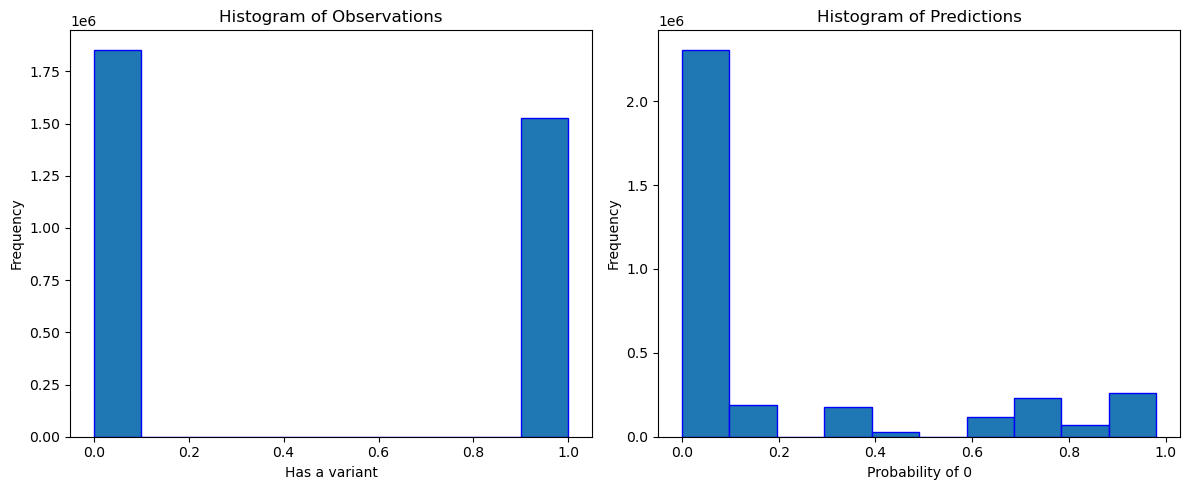

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 1.400e+06
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:23   Log-Likelihood:            -1.8517e+06
No. Observations:             3380119   AIC:                         3.703e+06
Df Residuals:                 3380117   BIC:                         3.703e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6192      0.000   2309.558      0.0

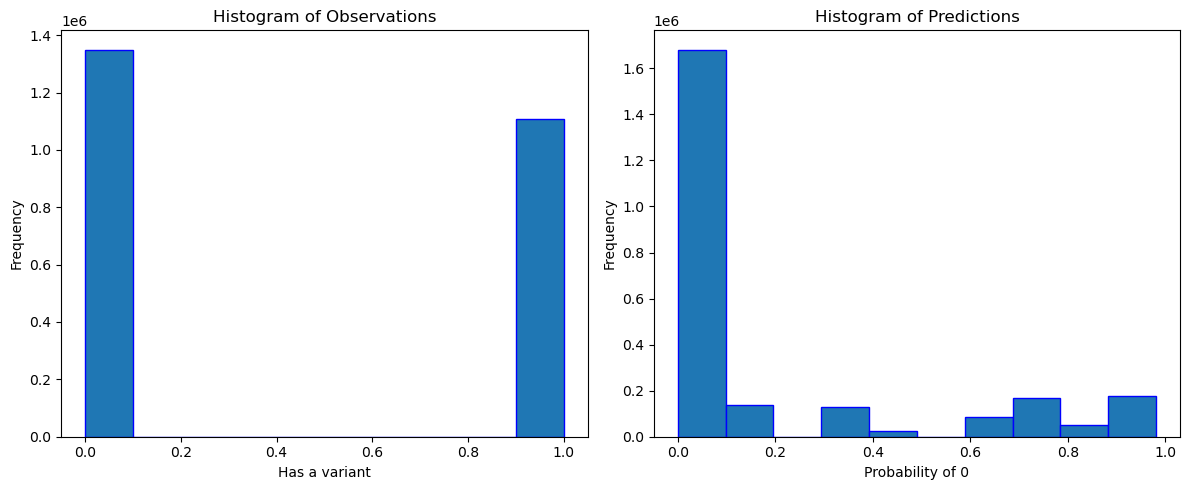

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 1.002e+06
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:41   Log-Likelihood:            -1.3518e+06
No. Observations:             2457680   AIC:                         2.704e+06
Df Residuals:                 2457678   BIC:                         2.704e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6171      0.000   1959.954      0.0

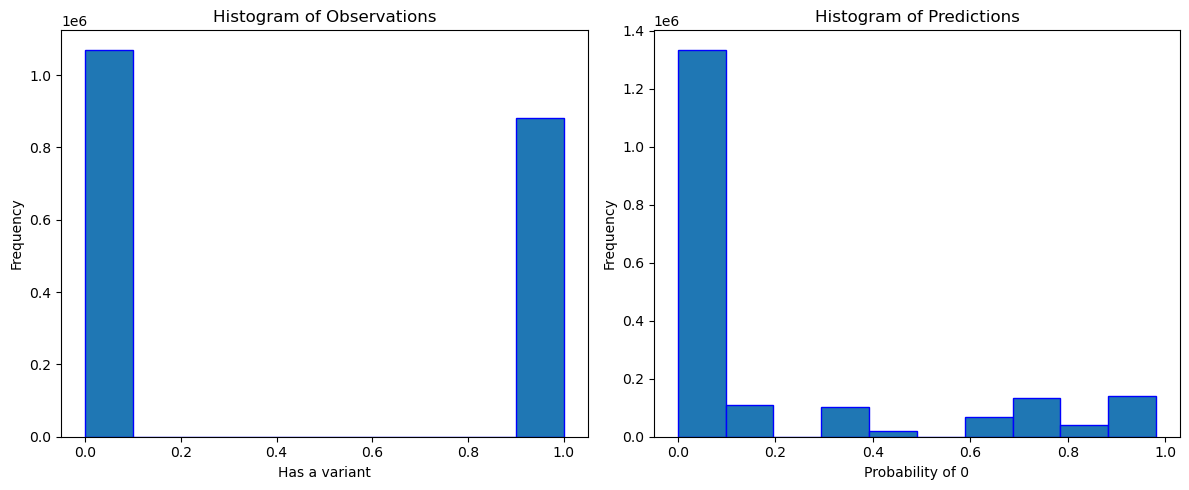

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 7.942e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:57   Log-Likelihood:            -1.0734e+06
No. Observations:             1950694   AIC:                         2.147e+06
Df Residuals:                 1950692   BIC:                         2.147e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6173      0.000   1746.676      0.0

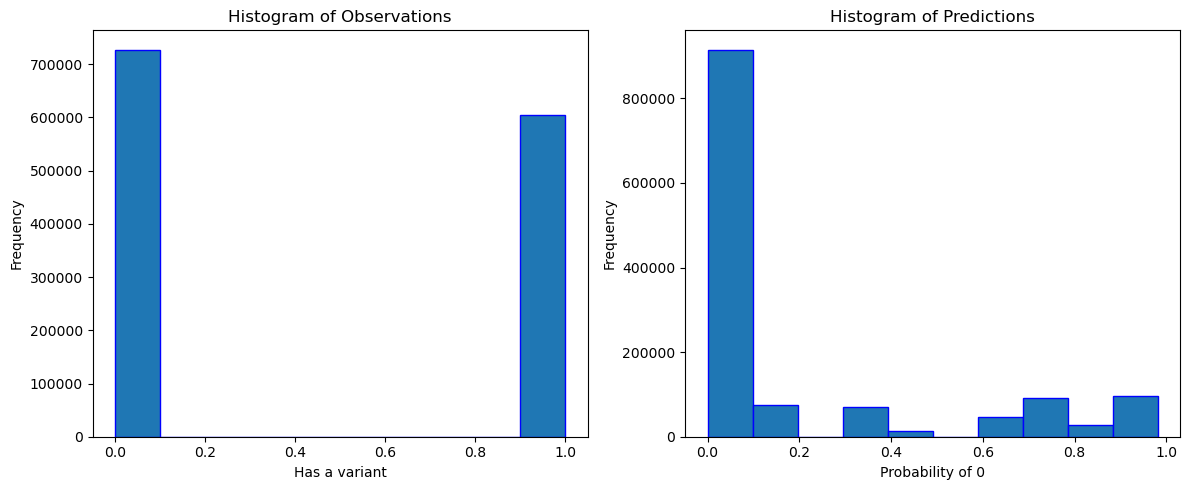

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 5.408e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:12   Log-Likelihood:            -7.3390e+05
No. Observations:             1331683   AIC:                         1.468e+06
Df Residuals:                 1331681   BIC:                         1.468e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6187      0.000   1447.884      0.0

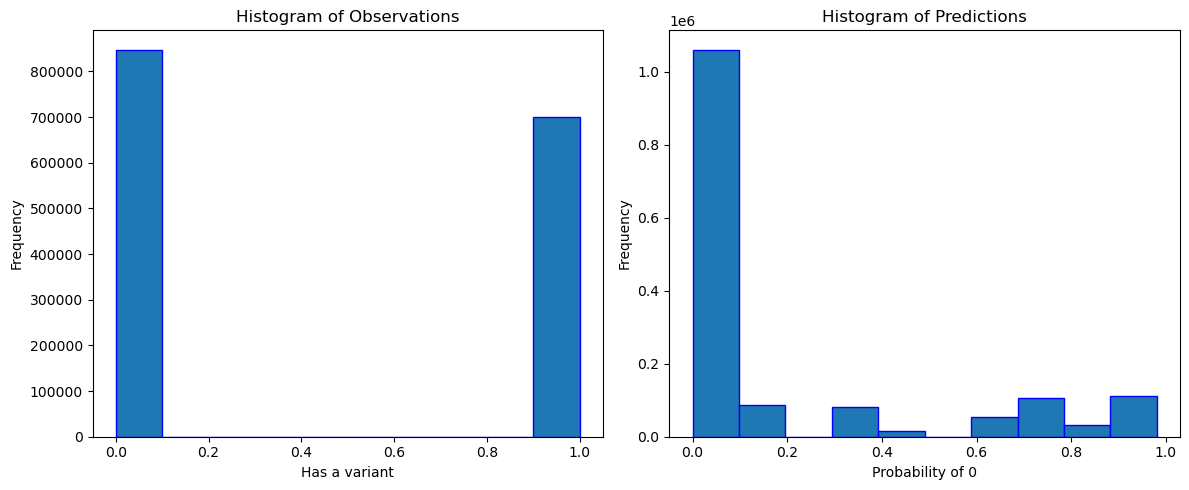

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 6.319e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:27   Log-Likelihood:            -8.5181e+05
No. Observations:             1548359   AIC:                         1.704e+06
Df Residuals:                 1548357   BIC:                         1.704e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6183      0.000   1559.818      0.0

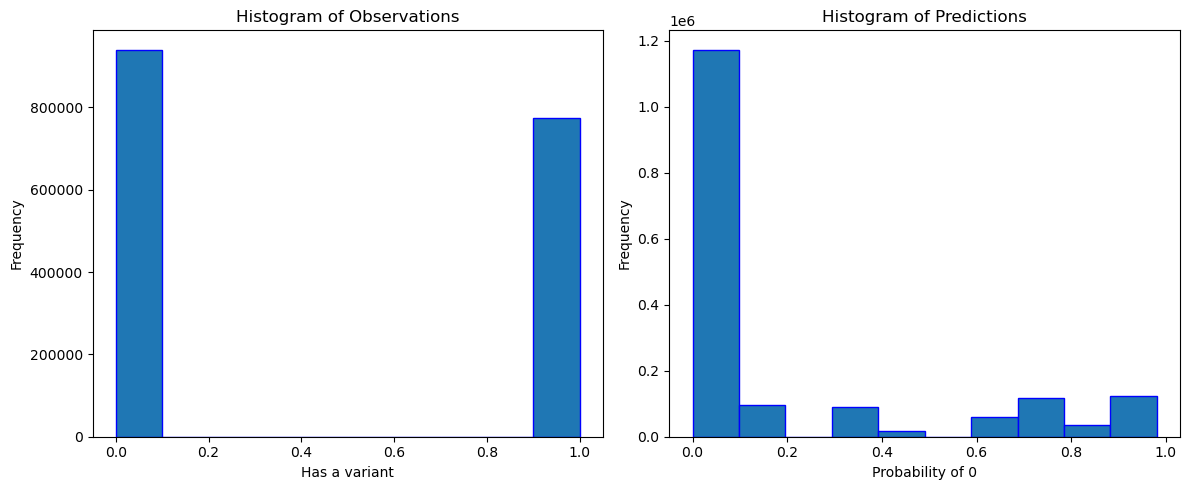

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.021e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:42   Log-Likelihood:            -9.4223e+05
No. Observations:             1714677   AIC:                         1.884e+06
Df Residuals:                 1714675   BIC:                         1.884e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6182      0.000   1640.933      0.0

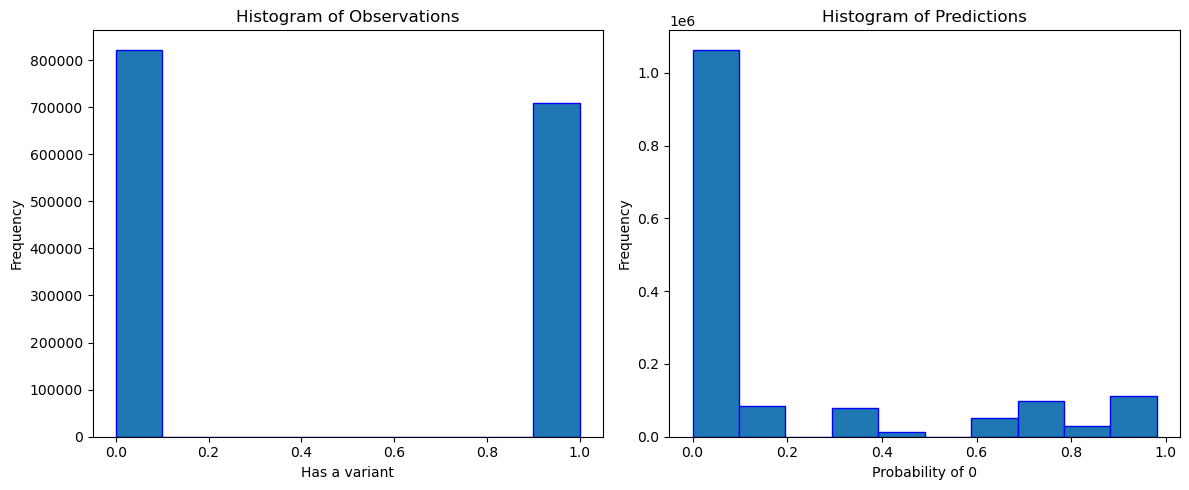

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 6.235e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:57   Log-Likelihood:            -8.4579e+05
No. Observations:             1531381   AIC:                         1.692e+06
Df Residuals:                 1531379   BIC:                         1.692e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6253      0.000   1575.601      0.0

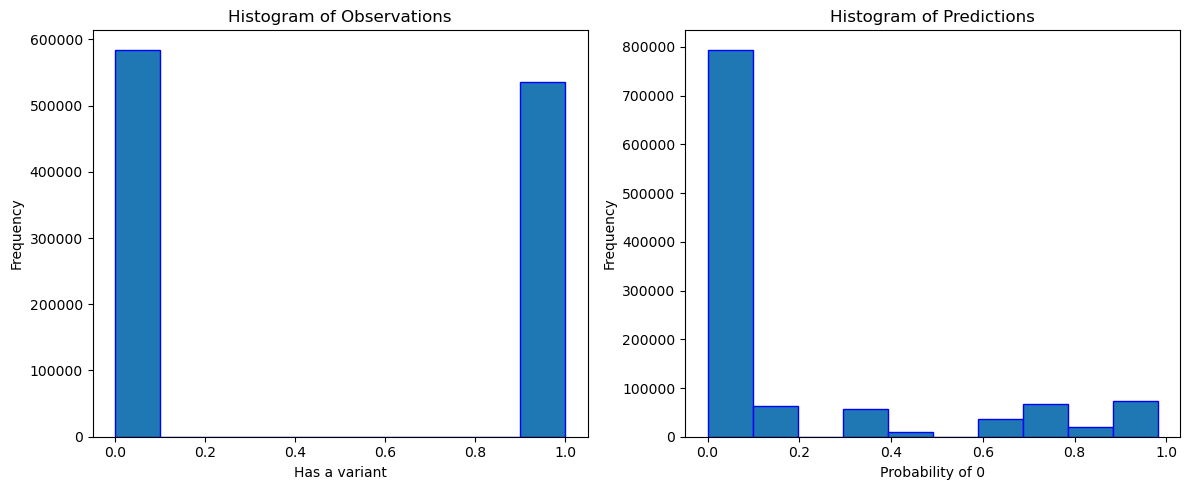

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                 4.456e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:13   Log-Likelihood:            -6.2414e+05
No. Observations:             1119857   AIC:                         1.248e+06
Df Residuals:                 1119855   BIC:                         1.248e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6331      0.000   1370.914      0.0

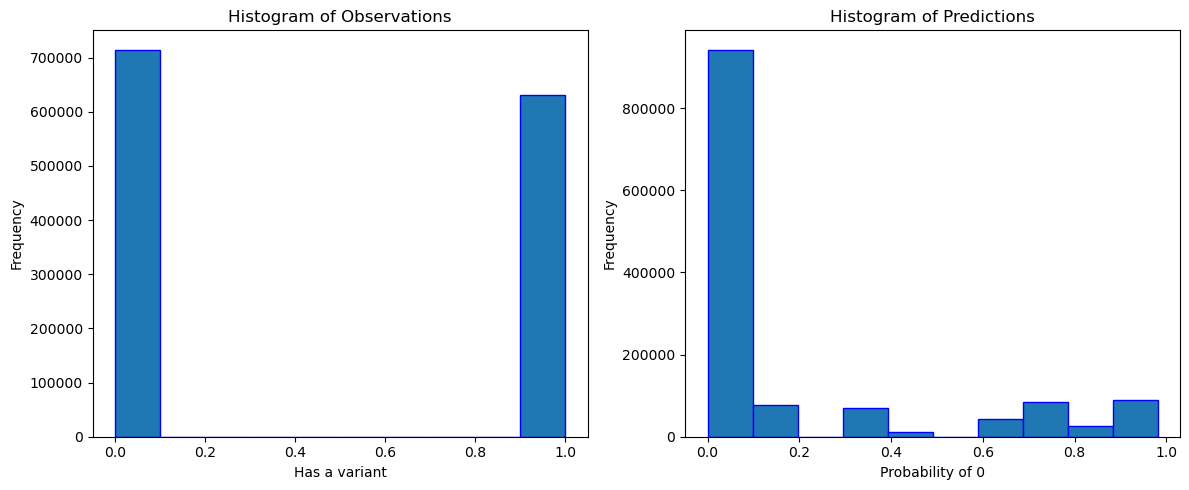

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                 5.370e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:29   Log-Likelihood:            -7.4730e+05
No. Observations:             1344526   AIC:                         1.495e+06
Df Residuals:                 1344524   BIC:                         1.495e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6269      0.000   1481.747      0.0

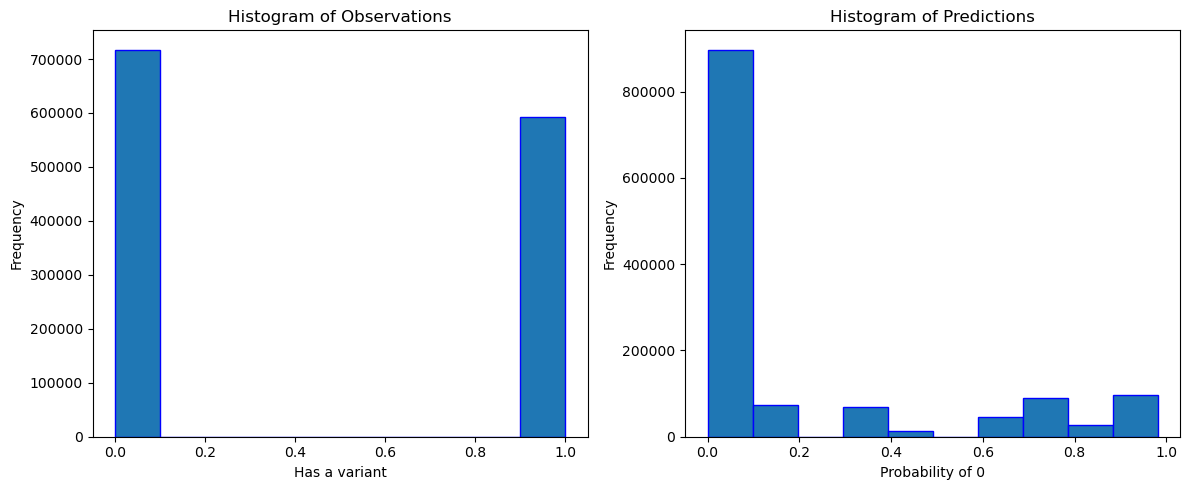

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 5.367e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:44   Log-Likelihood:            -7.2003e+05
No. Observations:             1310128   AIC:                         1.440e+06
Df Residuals:                 1310126   BIC:                         1.440e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6187      0.000   1436.125      0.0

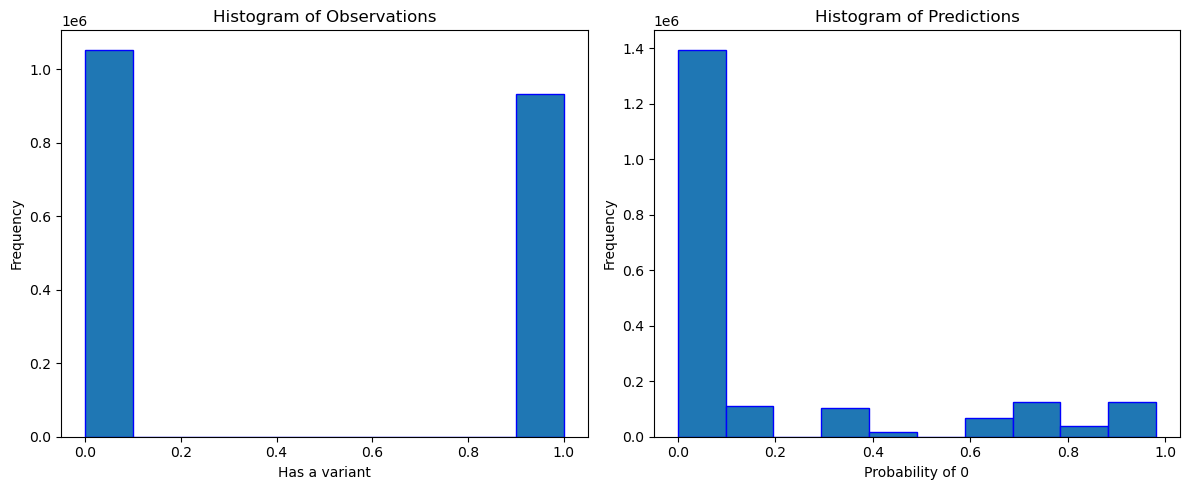

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 7.867e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:00   Log-Likelihood:            -1.1052e+06
No. Observations:             1984372   AIC:                         2.210e+06
Df Residuals:                 1984370   BIC:                         2.211e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6268      0.000   1799.580      0.0

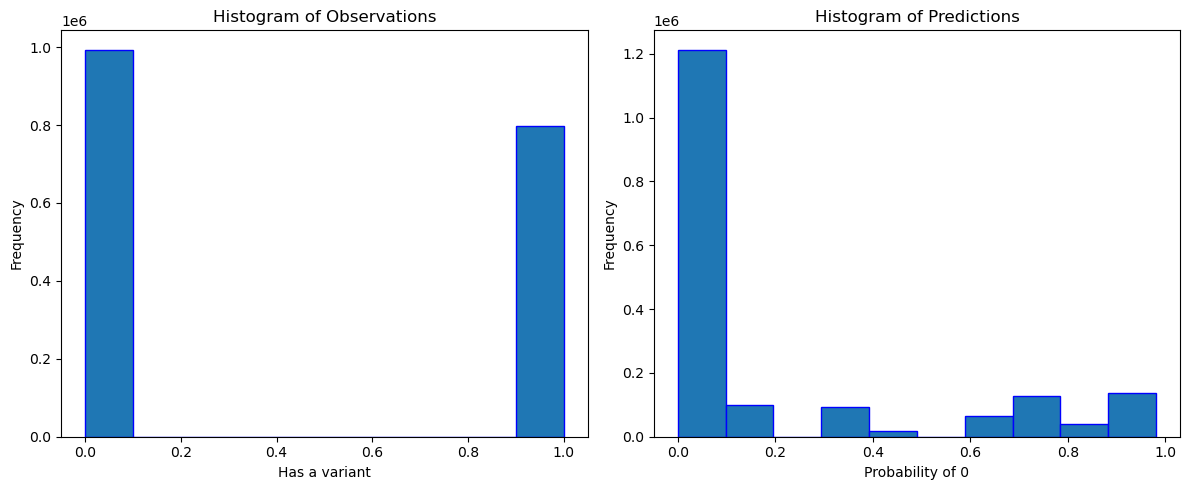

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 7.430e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:15   Log-Likelihood:            -9.7841e+05
No. Observations:             1791120   AIC:                         1.957e+06
Df Residuals:                 1791118   BIC:                         1.957e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6152      0.000   1666.185      0.0

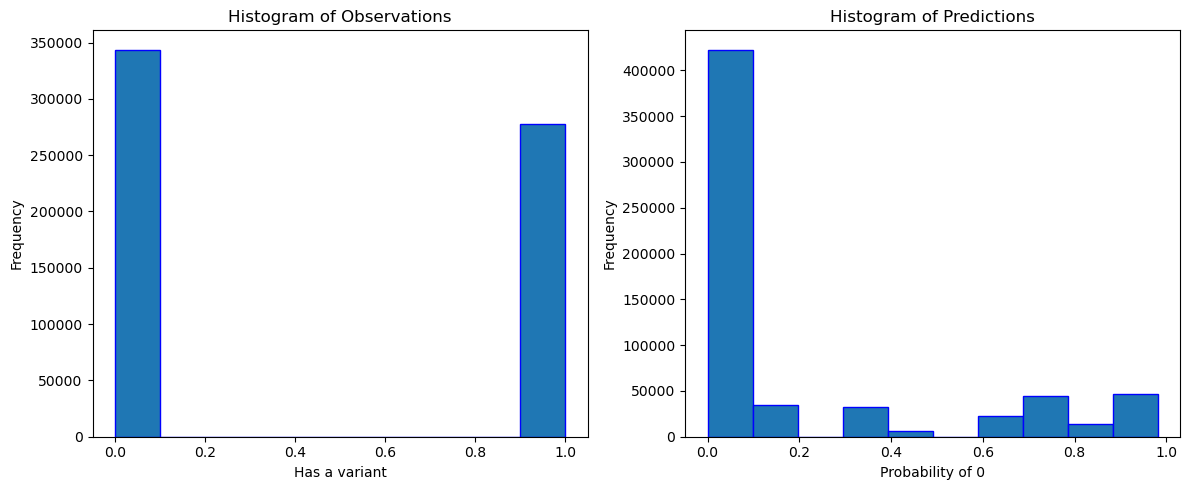

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 2.556e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:29   Log-Likelihood:            -3.4064e+05
No. Observations:              621634   AIC:                         6.813e+05
Df Residuals:                  621632   BIC:                         6.813e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6155      0.001    982.252      0.0

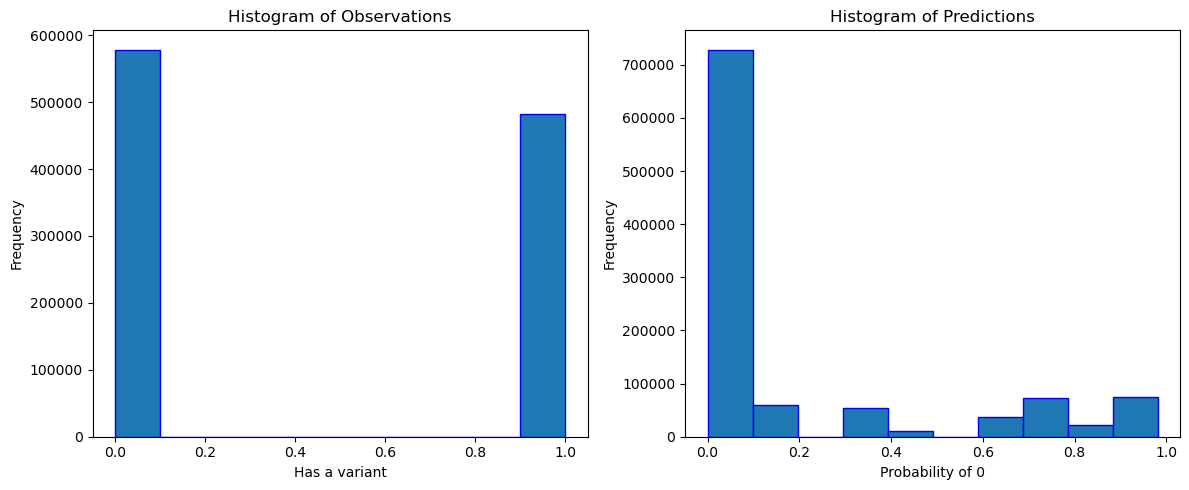

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 4.308e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:43   Log-Likelihood:            -5.8413e+05
No. Observations:             1059970   AIC:                         1.168e+06
Df Residuals:                 1059968   BIC:                         1.168e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6192      0.000   1292.966      0.0

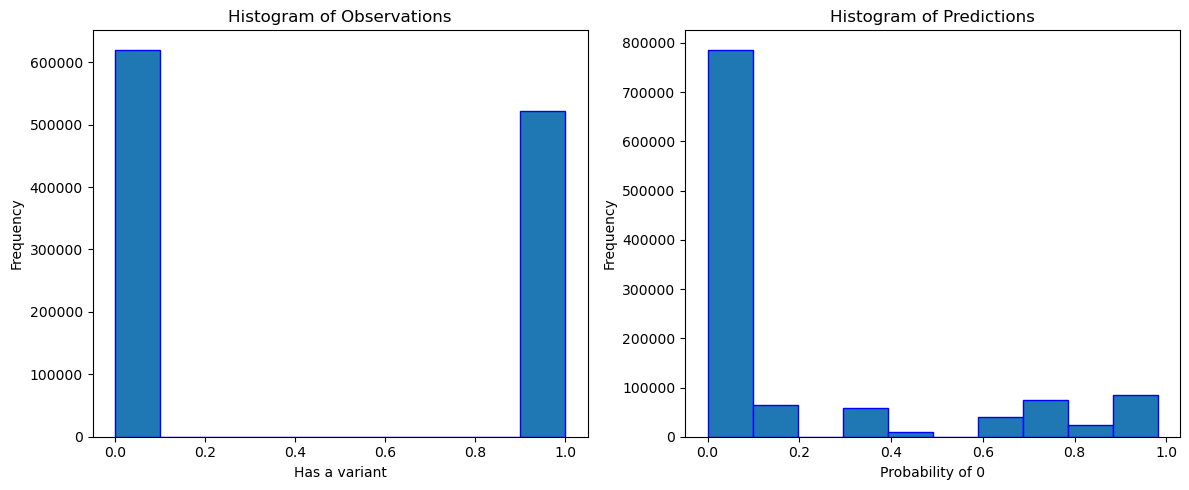

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 4.653e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:57   Log-Likelihood:            -6.2928e+05
No. Observations:             1141775   AIC:                         1.259e+06
Df Residuals:                 1141773   BIC:                         1.259e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6210      0.000   1347.804      0.0

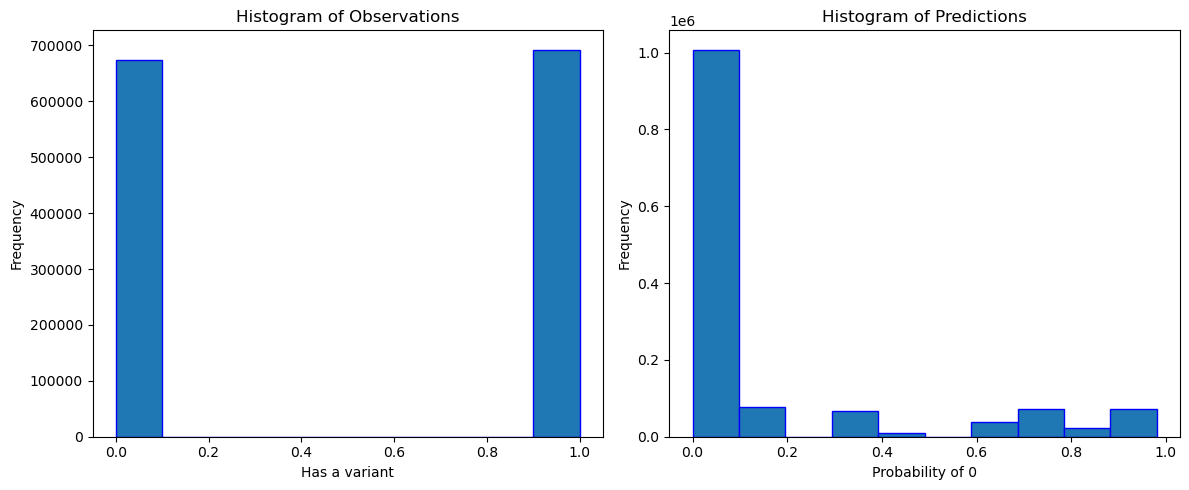

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 5.181e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:13   Log-Likelihood:            -7.7218e+05
No. Observations:             1366699   AIC:                         1.544e+06
Df Residuals:                 1366697   BIC:                         1.544e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6481      0.000   1566.187      0.0

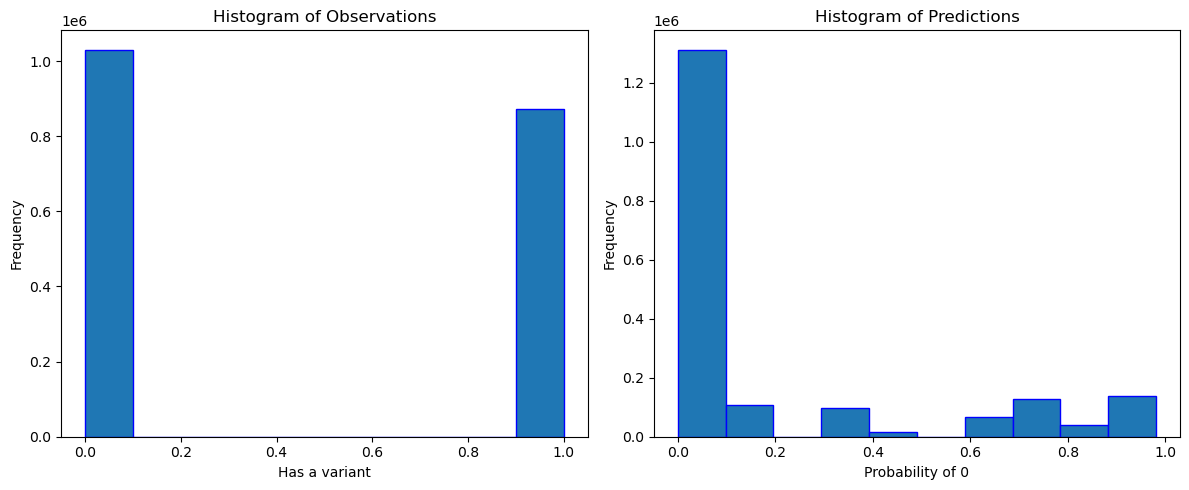

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.788e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:30   Log-Likelihood:            -1.0472e+06
No. Observations:             1901748   AIC:                         2.094e+06
Df Residuals:                 1901746   BIC:                         2.094e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6226      0.000   1744.926      0.0

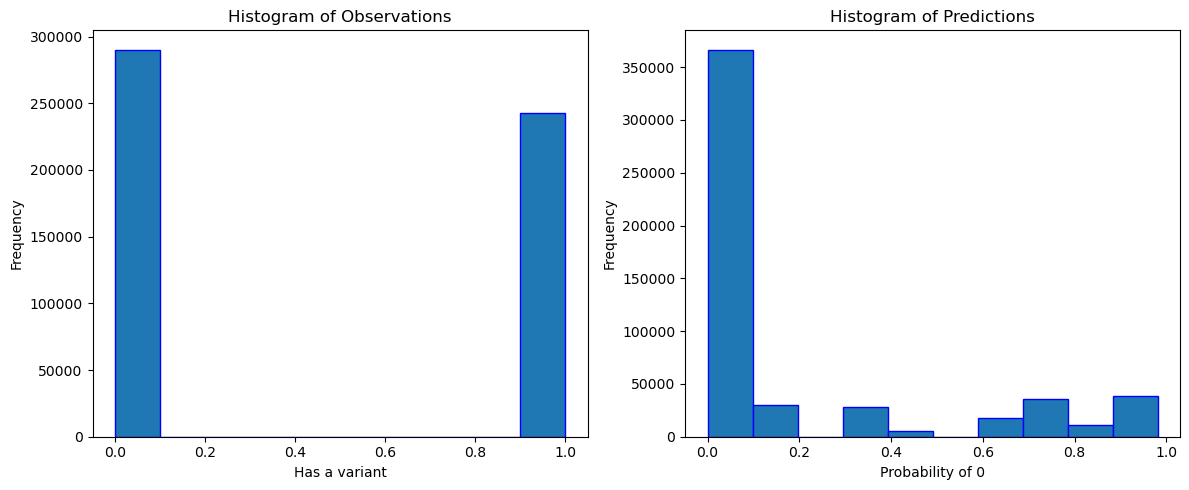

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 2.171e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:44   Log-Likelihood:            -2.9353e+05
No. Observations:              532825   AIC:                         5.871e+05
Df Residuals:                  532823   BIC:                         5.871e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6200      0.001    918.543      0.0

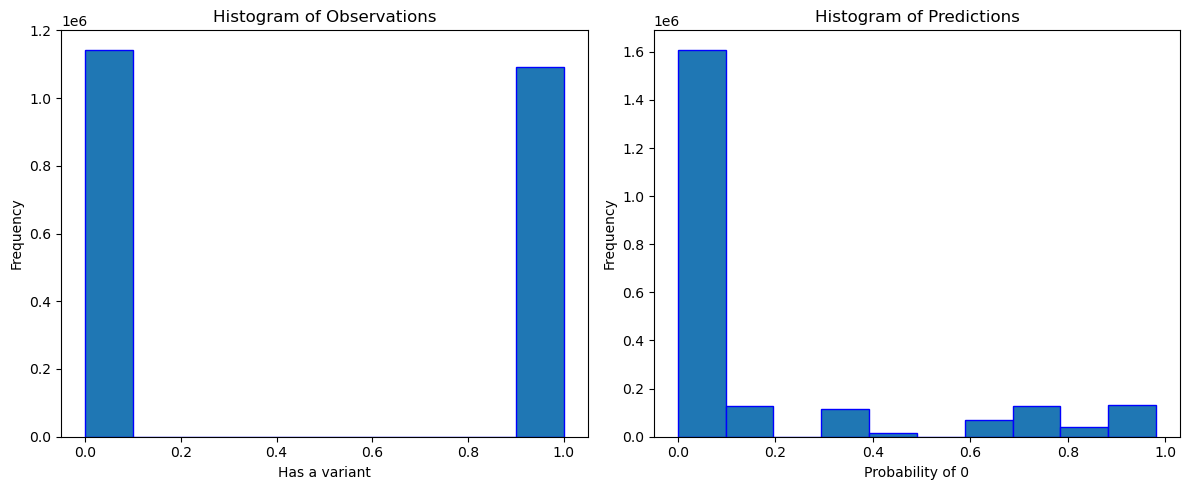

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                 8.685e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:01   Log-Likelihood:            -1.2543e+06
No. Observations:             2234481   AIC:                         2.509e+06
Df Residuals:                 2234479   BIC:                         2.509e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6379      0.000   1957.333      0.0

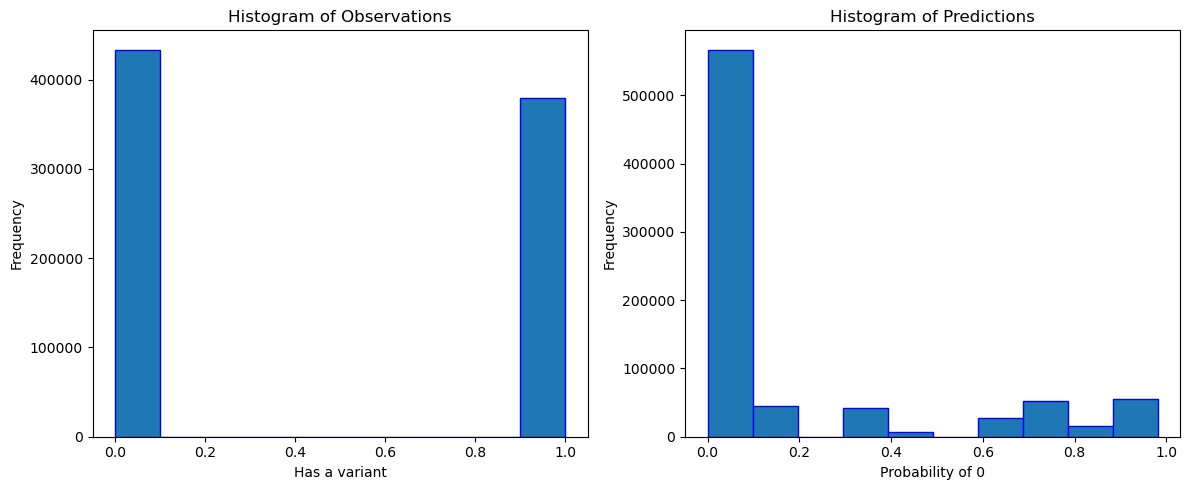

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 3.293e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:16   Log-Likelihood:            -4.4978e+05
No. Observations:              812688   AIC:                         8.996e+05
Df Residuals:                  812686   BIC:                         8.996e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6271      0.001   1152.104      0.0

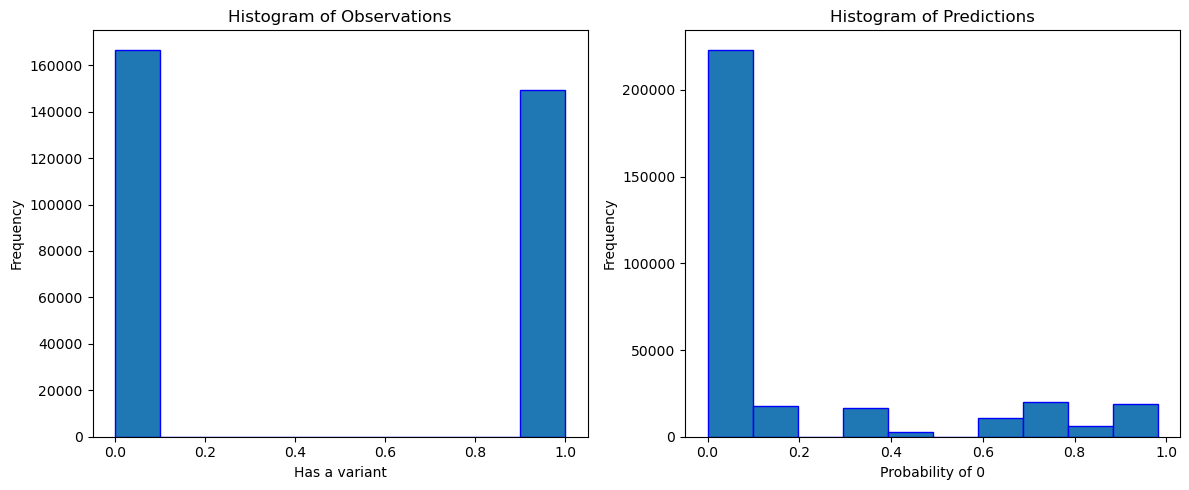

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:30   Log-Likelihood:            -1.7628e+05
No. Observations:              316182   AIC:                         3.526e+05
Df Residuals:                  316180   BIC:                         3.526e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6290      0.001    721.664      0.0

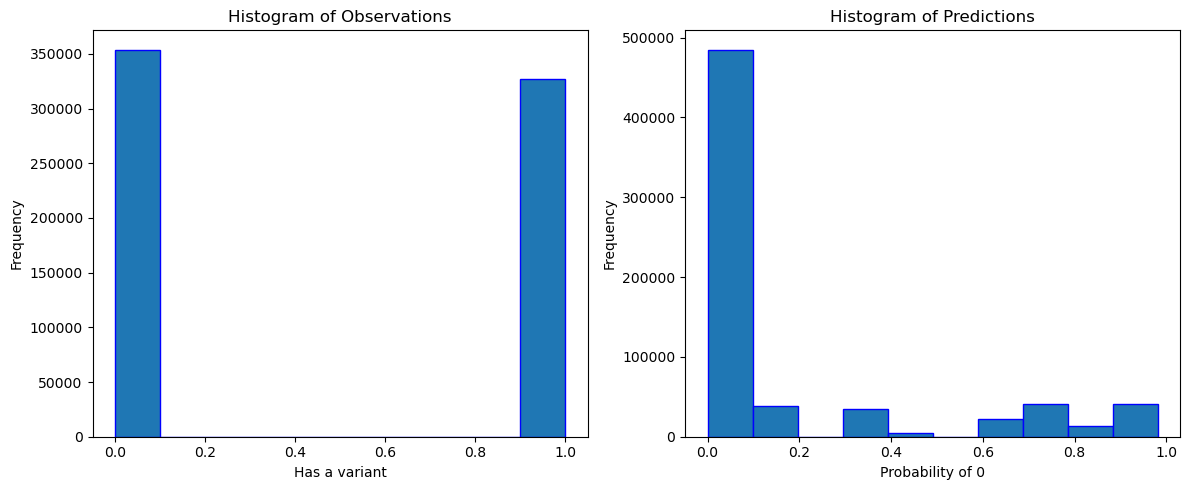

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 2.689e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:42   Log-Likelihood:            -3.8053e+05
No. Observations:              681114   AIC:                         7.611e+05
Df Residuals:                  681112   BIC:                         7.611e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6340      0.001   1071.141      0.0

chr       pos        prob_0    prob_1  observation
0          chr1     69344  1.707209e-31  1.000000          0.0
1          chr1     69345  1.321818e-01  0.867818          0.0
2          chr1     69346  1.468097e-02  0.985319          0.0
3          chr1     69347  2.860514e-02  0.971395          1.0
4          chr1     69348  3.884401e-01  0.611560          0.0
...         ...       ...           ...       ...          ...
32133707  chr22  50782288  2.463175e-02  0.975368          0.0
32133708  chr22  50782289  3.864468e-03  0.996136          1.0
32133709  chr22  50782290  2.528301e-03  0.997472          0.0
32133710  chr22  50782291  4.113130e-05  0.999959          1.0
32133711  chr22  50782292  1.131419e-04  0.999887          1.0

[32133712 rows x 5 columns]

In [31]:
# Parameters for analysis
coverage_thr = 0.5
order = 2

# Initialize empty dataframes
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observation'])

# Filter rows for chromosome 2
chr_gene_df = gene_df[gene_df['chr'] == 'chr2']
chr_variants_df = variants_df[variants_df['chr'] == 2]
chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr2') & (coverage_df['over_10'] > coverage_thr)]

# Get training data for the chromosome
observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

# Fit HMM to Chromosome 2
model = fit_HMM(observations, order=order)

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    chr_variants_df = variants_df[variants_df['chr'] == chromnum]
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum)) & (coverage_df['over_10'] > coverage_thr)]
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Append predictions to overall df
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)

# Write predictions_df to a csv to avoid recomputing
predictions_df.to_csv(project_path + "HMM_wgs_constraint_predictions.tsv.gz", index=False, compression='gzip', sep='\t')

predictions_df

# ***Run these cells for Alpha Missense analysis***

In [5]:
# Helper functions

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
#     Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
#     print("SCN1A:", len(cases_df[cases_df['gene_name'] == 'SCN1A']))
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if any(np.isnan(p_values)):
#         print("NaN values detected")
        return None

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

In [6]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

chr   source feature   start     end score strand frame  \
60       chr1   HAVANA     CDS   65565   65573     .      +     0   
63       chr1   HAVANA     CDS   69037   70005     .      +     0   
236      chr1   HAVANA     CDS  450743  451678     .      -     0   
304      chr1   HAVANA     CDS  685719  686654     .      -     0   
524      chr1   HAVANA     CDS  924432  924948     .      +     0   
...       ...      ...     ...     ...     ...   ...    ...   ...   
1998488  chrM  ENSEMBL     CDS   10470   10763     .      +     0   
1998495  chrM  ENSEMBL     CDS   10760   12137     .      +     0   
1998509  chrM  ENSEMBL     CDS   12337   14145     .      +     0   
1998515  chrM  ENSEMBL     CDS   14149   14673     .      -     0   
1998523  chrM  ENSEMBL     CDS   14747   15887     .      +     0   

                    gene_id       gene_type gene_name      transcript_id  \
60        ENSG00000186092.7  protein_coding     OR4F5  ENST00000641515.2   
63        ENSG00000186092.7  protein_coding     OR4F5  ENST00000641515.2   
236       ENSG00000284733.2  protein_coding    OR4F29  ENST00000426406.4   
304       ENSG00000284662.2  protein_coding    OR4F16  ENST00000332831.5   
524      ENSG00000187634.13  protein_coding    SAMD11  ENST00000616016.5   
...                     ...             ...       ...                ...   
1998488   ENSG00000212907.2  protein_coding   MT-ND4L  ENST00000361335.1   
1998495   ENSG00000198886.2  protein_coding    MT-ND4  ENST00000361381.2   
1998509   ENSG00000198786.2  protein_coding    MT-ND5  ENST00000361567.2   
1998515   ENSG00000198695.2  protein_coding    MT-ND6  ENST00000361681.2   
1998523   ENSG00000198727.2  protein_coding    MT-CYB  ENST00000361789.2   

              transcript transcript_num transcript_name      std_gene_id  
60       ENST00000641515              2       OR4F5-201  ENSG00000186092  
63       ENST00000641515              2       OR4F5-201  ENSG00000186092  
236      ENST00000426406              4      OR4F29-201  ENSG00000284733  
304      ENST00000332831              5      OR4F16-201  ENSG00000284662  
524      ENST00000616016              5      SAMD11-209  ENSG00000187634  
...                  ...            ...             ...              ...  
1998488  ENST00000361335              1     MT-ND4L-201  ENSG00000212907  
1998495  ENST00000361381              2      MT-ND4-201  ENSG00000198886  
1998509  ENST00000361567              2      MT-ND5-201  ENSG00000198786  
1998515  ENST00000361681              2      MT-ND6-201  ENSG00000198695  
1998523  ENST00000361789              2      MT-CYB-201  ENSG00000198727  

[654548 rows x 16 columns]

In [7]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

chr       pos ref alt genome uniprot_id             transcript_id  \
0         chr1     69094   G   T   hg38     Q8NH21         ENST00000335137.4   
1         chr1     69094   G   C   hg38     Q8NH21         ENST00000335137.4   
2         chr1     69094   G   A   hg38     Q8NH21         ENST00000335137.4   
3         chr1     69095   T   C   hg38     Q8NH21         ENST00000335137.4   
4         chr1     69095   T   A   hg38     Q8NH21         ENST00000335137.4   
...        ...       ...  ..  ..    ...        ...                       ...   
71697551  chrY  57196925   T   G   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697552  chrY  57196925   T   C   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697553  chrY  57196925   T   A   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697554  chrY  57196926   C   G   hg38     Q01113  ENST00000244174.10_PAR_Y   
71697555  chrY  57196926   C   A   hg38     Q01113  ENST00000244174.10_PAR_Y   

         protein_variant  am_pathogenicity           am_class  \
0                    V2L            0.2937      likely_benign   
1                    V2L            0.2937      likely_benign   
2                    V2M            0.3296      likely_benign   
3                    V2A            0.2609      likely_benign   
4                    V2E            0.2922      likely_benign   
...                  ...               ...                ...   
71697551           F521C            0.1903      likely_benign   
71697552           F521S            0.2045      likely_benign   
71697553           F521Y            0.1440      likely_benign   
71697554           F521L            0.5879  likely_pathogenic   
71697555           F521L            0.5879  likely_pathogenic   

               transcript transcript_num  
0         ENST00000335137              4  
1         ENST00000335137              4  
2         ENST00000335137              4  
3         ENST00000335137              4  
4         ENST00000335137              4  
...                   ...            ...  
71697551  ENST00000244174       10_PAR_Y  
71697552  ENST00000244174       10_PAR_Y  
71697553  ENST00000244174       10_PAR_Y  
71697554  ENST00000244174       10_PAR_Y  
71697555  ENST00000244174       10_PAR_Y  

[71697556 rows x 12 columns]

## Epilepsy

In [8]:
# Read the data into a DataFrame
epi25_variant_results_df = pd.read_csv(data_path + 'epi25_variant_results.tsv.gz', sep='\t')

# Split locus into chr and pos and convert to integers
epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
# variant_results_df['chr'] = variant_results_df['chr'].str.replace('chr', '').astype(int)
epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# Filter out rows
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
                                                    (epi25_variant_results_df['consequence'] != "non_coding") & 
                                                    (epi25_variant_results_df['consequence'] != "NA")]

# Add gene names
epi25_variant_results_df = pd.merge(epi25_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

epi25_variant_results_df

locus    alleles          gene_id        consequence  \
0             chr1:69731  ["T","C"]  ENSG00000186092  damaging_missense   
1             chr1:69731  ["T","C"]  ENSG00000186092  damaging_missense   
2             chr1:69923  ["T","G"]  ENSG00000186092     other_missense   
3             chr1:69928  ["T","A"]  ENSG00000186092  damaging_missense   
4             chr1:69928  ["T","A"]  ENSG00000186092  damaging_missense   
...                  ...        ...              ...                ...   
11716909  chr22:50782272  ["G","A"]  ENSG00000079974     other_missense   
11716910  chr22:50782272  ["G","T"]  ENSG00000079974     other_missense   
11716911  chr22:50782285  ["C","T"]  ENSG00000079974     other_missense   
11716912  chr22:50782286  ["T","G"]  ENSG00000079974     other_missense   
11716913  chr22:50782286  ["T","G"]  ENSG00000079974     other_missense   

             hgvsc        hgvsp     mpc           polyphen group  \
0         c.641T>C  p.Ile214Thr  3.3624  probably_damaging   EPI   
1         c.641T>C  p.Ile214Thr  3.3624  probably_damaging  NAFE   
2         c.833T>G  p.Ile278Ser  2.3070             benign   EPI   
3         c.838T>A  p.Tyr280Asn  4.3167  probably_damaging   EPI   
4         c.838T>A  p.Tyr280Asn  4.3167  probably_damaging  NAFE   
...            ...          ...     ...                ...   ...   
11716909   c.23C>T    p.Pro8Leu     NaN             benign  NAFE   
11716910   c.23C>A    p.Pro8Gln     NaN             benign   EPI   
11716911   c.10G>A    p.Asp4Asn     NaN             benign   EPI   
11716912    c.9A>C    p.Glu3Asp     NaN             benign   EPI   
11716913    c.9A>C    p.Glu3Asp     NaN             benign   GGE   

                  variant_id  ...  an_case  ac_ctrl  an_ctrl  estimate  \
0             chr1:69731:T:C  ...    37174        0    55408       NaN   
1             chr1:69731:T:C  ...    16300        0    55408       NaN   
2             chr1:69923:T:G  ...    30002        0    43218       NaN   
3             chr1:69928:T:A  ...    30156        0    43308       NaN   
4             chr1:69928:T:A  ...    13296        0    43308       NaN   
...                      ...  ...      ...      ...      ...       ...   
11716909  chr22:50782272:G:A  ...    18438        1    64916       NaN   
11716910  chr22:50782272:G:T  ...    41956        0    64916       NaN   
11716911  chr22:50782285:C:T  ...    41954        0    64092       NaN   
11716912  chr22:50782286:T:G  ...    41954        0    64054       NaN   
11716913  chr22:50782286:T:G  ...    10998        0    64054       NaN   

          chi_sq_stat  p_value  in_analysis    chr       pos  gene_name  
0                 NaN      NaN         True   chr1     69731      OR4F5  
1                 NaN      NaN         True   chr1     69731      OR4F5  
2                 NaN      NaN         True   chr1     69923      OR4F5  
3                 NaN      NaN         True   chr1     69928      OR4F5  
4                 NaN      NaN         True   chr1     69928      OR4F5  
...               ...      ...          ...    ...       ...        ...  
11716909          NaN      NaN          NaN  chr22  50782272     RABL2B  
11716910          NaN      NaN          NaN  chr22  50782272     RABL2B  
11716911          NaN      NaN          NaN  chr22  50782285     RABL2B  
11716912          NaN      NaN          NaN  chr22  50782286     RABL2B  
11716913          NaN      NaN          NaN  chr22  50782286     RABL2B  

[11716914 rows x 21 columns]

In [83]:
# Parameters for analysis
prop_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = epi25_variant_results_df
predictions_df = pd.read_csv(project_path + 'HMM_wgs_constraint_predictions.tsv.gz', sep='\t')

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
#     if chromnum != 2:
#         continue
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(chr_variant_results_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(project_path + "epi_wgs_contraint_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
                 gene_id gene_name group  total_ac_case  total_an_case  \
1169326  ENSG00000198626      RYR2   GGE             14          10998   

         total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
1169326             14          66888     6.08831  0.000007  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 2
                 gene_id gene_name group  total_ac_case  total_an_case  \
1725298  ENSG00000144285     SCN1A   DEE              9           3876   
1725299  ENSG00000144285     SCN1A   EPI             27          41958   
1916830  ENSG00000144445   KANSL1L   DEE              6           3876   
1274263  ENSG00000084676     NCOA1   GGE              7          10998   

         total_ac_ctrl  total_an_ctrl  odds_ratio       p_value  
1725298              2          66888   

Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19
                  gene_id gene_name group  total_ac_case  total_an_case  \
10837269  ENSG00000196961     AP2A1   EPI             17          41958   
10661438  ENSG00000105227       PRX   EPI             34          41958   
10661522  ENSG00000105227       PRX  NAFE             18          18438   
10406214  ENSG00000037757      MRI1   EPI              0          41958   

          total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
10837269              2          66888   13.555495  0.000006  
10661438             14          66888    3.873874  0.000008  
10661522             14          66888    4.667799  0.000020  
10406214             20          66888    0.000000  0.000086  
---------------------------------------

gene_id gene_name group total_ac_case total_an_case  \
0      ENSG00000198626      RYR2   GGE            14         10998   
1      ENSG00000134697      GNL2   GGE            11         10998   
2      ENSG00000169641     LUZP1   DEE             7          3876   
3      ENSG00000065526      SPEN  NAFE             8         18438   
4      ENSG00000198626      RYR2   EPI            29         41958   
...                ...       ...   ...           ...           ...   
68518  ENSG00000099960    SLC7A4   EPI            10         41958   
68519  ENSG00000099957     P2RX6  NAFE             7         18438   
68520  ENSG00000133433    GSTT2B   DEE             0          3876   
68521  ENSG00000100380      ST13   GGE             0         10998   
68522  ENSG00000198125        MB   EPI             0         41958   

      total_ac_ctrl total_an_ctrl  odds_ratio   p_value  
0                14         66888    6.088310  0.000007  
1                12         66888    5.579594  0.000115  
2                15         66888    8.066012  0.000121  
3                 2         66888   14.516766  0.000140  
4                14         66888    3.303792  0.000211  
...             ...           ...         ...       ...  
68518            16         66888    0.996353  1.000000  
68519            25         66888    1.015769  1.000000  
68520             9         66880    0.000000  1.000000  
68521             5         66882    0.000000  1.000000  
68522             1         66888    0.000000  1.000000  

[68523 rows x 9 columns]

### Analyze with Alpha Missense Results

In [33]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
epi25_variants_filtered_df = epi25_variant_results_df[(epi25_variant_results_df['ac_ctrl'] + epi25_variant_results_df['ac_case'] <= cnt_thr) &
                                                       (epi25_variant_results_df['an_case'] > 0) &
                                                       (epi25_variant_results_df['an_ctrl'] > 0)
                                                      ].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "variant_id", "estimate", "chi_sq_stat", "in_analysis"])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), epi25_variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_epi25_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

chr       pos    prob_0    prob_1  observation  am_pathogenicity  \
0         chr1    925946  0.000048  0.999952          1.0            0.9876   
1         chr1    925946  0.000048  0.999952          1.0            0.9876   
2         chr1    925946  0.000048  0.999952          1.0            0.9876   
3         chr1    925946  0.000048  0.999952          1.0            0.9876   
4         chr1    925948  0.000039  0.999961          1.0            0.9460   
...        ...       ...       ...       ...          ...               ...   
9538296  chr22  50782272  0.023273  0.976727          1.0            0.0918   
9538297  chr22  50782272  0.023273  0.976727          1.0            0.0918   
9538298  chr22  50782285  0.024696  0.975304          1.0            0.1397   
9538299  chr22  50782286  0.384739  0.615261          0.0            0.0810   
9538300  chr22  50782286  0.384739  0.615261          0.0            0.0810   

                 gene_id        consequence group  ac_case  an_case  ac_ctrl  \
0        ENSG00000187634  damaging_missense   DEE        0     3876        1   
1        ENSG00000187634  damaging_missense   EPI        0    41956        1   
2        ENSG00000187634  damaging_missense   GGE        0    10996        1   
3        ENSG00000187634  damaging_missense  NAFE        0    18438        1   
4        ENSG00000187634  damaging_missense   EPI        2    41958        0   
...                  ...                ...   ...      ...      ...      ...   
9538296  ENSG00000079974     other_missense  NAFE        0    18438        1   
9538297  ENSG00000079974     other_missense   EPI        1    41956        0   
9538298  ENSG00000079974     other_missense   EPI        1    41954        0   
9538299  ENSG00000079974     other_missense   EPI        1    41954        0   
9538300  ENSG00000079974     other_missense   GGE        1    10998        0   

         an_ctrl  p_value gene_name  effect_size  var_effect_size  
0          66886      NaN    SAMD11     1.749437         2.666940  
1          66886      NaN    SAMD11    -0.632263         2.666705  
2          66886      NaN    SAMD11     0.706793         2.666773  
3          66886      NaN    SAMD11     0.189929         2.666736  
4          66886      NaN    SAMD11     2.075802         2.400039  
...          ...      ...       ...          ...              ...  
9538296    64916      NaN    RABL2B     0.160033         2.666736  
9538297    64916      NaN    RABL2B     1.535105         2.666706  
9538298    64092      NaN    RABL2B     1.522378         2.666706  
9538299    64054      NaN    RABL2B     1.521785         2.666706  
9538300    64054      NaN    RABL2B     2.860679         2.666773  

[9538301 rows x 17 columns]

In [48]:
# Read the data from the file
merged_df = pd.read_csv(project_path + 'constraint_am_epi25_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[merged_df['consequence'] != "pLoF"]

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = np.log(gene_data['effect_size'])
    weights = 1 / np.sqrt(gene_data['var_effect_size'])

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
epi_p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
epi_p_values_df.to_csv(project_path + "constraint_am_epi25_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
epi_p_values_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 71072/71857 [05:38<00:03, 210.02gene/s]


gene_id        gene_name group  p_value_prob_0  \
0      ENSG00000000419             DPM1   DEE        0.952711   
1      ENSG00000000419             DPM1   EPI        0.279973   
2      ENSG00000000419             DPM1   GGE        0.963936   
3      ENSG00000000419             DPM1  NAFE        0.315791   
4      ENSG00000000457            SCYL3   DEE        0.099344   
...                ...              ...   ...             ...   
70894  ENSG00000285982  ENSG00000285982  NAFE        0.871272   
70895  ENSG00000285991  ENSG00000285991   DEE        0.078211   
70896  ENSG00000285991  ENSG00000285991   EPI        0.557394   
70897  ENSG00000285991  ENSG00000285991   GGE        0.917504   
70898  ENSG00000285991  ENSG00000285991  NAFE        0.631009   

       p_value_am_pathogenicity  p_value_const p_value_overall  
0                      0.017565   3.390907e-03        0.053432  
1                      0.366636   1.524574e-01        0.412917  
2                      0.868841   6.570655e-01        0.983538  
3                      0.266319   3.396087e-02        0.279328  
4                      0.652616   4.954706e-18        0.202856  
...                         ...            ...             ...  
70894                  0.361515   9.384493e-01        0.655538  
70895                  0.046673   2.237098e-03        0.028226  
70896                  0.524416   6.175671e-01         0.65269  
70897                  0.223847   9.594624e-01        0.453686  
70898                  0.986345   1.109915e-01        0.889396  

[70899 rows x 7 columns]

# ***Result cell*** - run this to only look at results

In [84]:
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

In [85]:
epi_significant_genes_df = pd.read_csv(project_path + 'epi_wgs_contraint_pvalues.tsv.gz', sep='\t')
epi_p_values_df = pd.read_csv(project_path + 'constraint_am_epi25_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(epi_p_values_df, epi_significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

# joined_p_values_df[joined_p_values_df['p_value_overall'] < joined_p_values_df['p_value']]
joined_p_values_df[['gene_id', 'gene_name', 'group', 'p_value_prob_0', 'p_value_am_pathogenicity', 'p_value_overall', 'p_value', 'p_comb']]

gene_id gene_name group  p_value_prob_0  \
0      ENSG00000000419      DPM1   DEE        0.952711   
1      ENSG00000000419      DPM1   EPI        0.279973   
2      ENSG00000000419      DPM1   GGE        0.963936   
3      ENSG00000000419      DPM1  NAFE        0.315791   
4      ENSG00000000457     SCYL3   DEE        0.099344   
...                ...       ...   ...             ...   
73763  ENSG00000285314       NaN   GGE             NaN   
73764  ENSG00000285762       NaN   DEE             NaN   
73765  ENSG00000285762       NaN   EPI             NaN   
73766  ENSG00000285762       NaN   GGE             NaN   
73767  ENSG00000285314       NaN   EPI             NaN   

       p_value_am_pathogenicity  p_value_overall   p_value    p_comb  
0                      0.017565         0.053432  0.026846  0.010826  
1                      0.366636         0.412917  0.001988  0.006654  
2                      0.868841         0.983538  0.002161  0.015208  
3                      0.266319         0.279328  0.119622  0.146981  
4                      0.652616         0.202856  0.053851  0.060265  
...                         ...              ...       ...       ...  
73763                       NaN              NaN  1.000000  1.000000  
73764                       NaN              NaN  1.000000  1.000000  
73765                       NaN              NaN  1.000000  1.000000  
73766                       NaN              NaN  1.000000  1.000000  
73767                       NaN              NaN  1.000000  1.000000  

[73768 rows x 8 columns]

In [87]:
# epi_significant_genes_df[epi_significant_genes_df['gene_name'] == 'SCN1A']

In [106]:
p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

# p_values_df = joined_p_values_df
# filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_overall'] < 1e-4)
filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_prob_0'] < 1e-4)

gene_name_mask = (p_values_df['gene_name'] == 'SLC2A1')
pd.set_option('display.max_rows', 200)
p_values_df[filter_mask].sort_values('p_value_prob_0')

gene_id        gene_name group  p_value_prob_0  \
36574  ENSG00000155657              TTN   EPI    2.492727e-19   
36573  ENSG00000155657              TTN   DEE    1.640818e-18   
26823  ENSG00000136450            SRSF1   DEE    3.868179e-16   
26826  ENSG00000136450            SRSF1  NAFE    1.276238e-15   
70547  ENSG00000284512  ENSG00000284512   DEE    9.505072e-15   
70550  ENSG00000284512  ENSG00000284512  NAFE    3.533363e-14   
70549  ENSG00000284512  ENSG00000284512   GGE    1.313710e-13   
17453  ENSG00000117407             ARTN  NAFE    2.695096e-11   
63351  ENSG00000204392             LSM2   EPI    5.162338e-11   
25972  ENSG00000135346              CGA   EPI    1.405979e-07   
54171  ENSG00000181143            MUC16   EPI    2.286353e-07   
25723  ENSG00000134982              APC   DEE    1.651305e-06   
61033  ENSG00000197272             IL27  NAFE    1.999693e-06   
14727  ENSG00000112159             MDN1   DEE    2.083504e-06   
51476  ENSG00000176381            PRR18  NAFE    2.460363e-06   
55331  ENSG00000183091              NEB   DEE    5.674681e-06   
2665   ENSG00000054654            SYNE2   EPI    6.915613e-06   
31706  ENSG00000144285            SCN1A   DEE    6.928000e-06   
23507  ENSG00000131018            SYNE1   EPI    7.209413e-06   
36118  ENSG00000154358            OBSCN   DEE    7.988280e-06   
1212   ENSG00000013503           POLR3B   DEE    9.982785e-06   
14728  ENSG00000112159             MDN1   EPI    1.189021e-05   
57062  ENSG00000185567           AHNAK2   DEE    1.375025e-05   
68522  ENSG00000258881  ENSG00000258881   DEE    1.395185e-05   
31050  ENSG00000143341            HMCN1   DEE    1.468623e-05   
2504   ENSG00000051341             POLQ   DEE    1.530374e-05   
21942  ENSG00000127603            MACF1   DEE    1.581559e-05   
51474  ENSG00000176381            PRR18   EPI    1.669068e-05   
67698  ENSG00000253729            PRKDC   DEE    2.100553e-05   
15279  ENSG00000113240             CLK4   DEE    2.373414e-05   
9420   ENSG00000101460         MAP1LC3A   DEE    3.022924e-05   
39473  ENSG00000162188             GNG3  NAFE    3.030221e-05   
36745  ENSG00000156052             GNAQ   DEE    3.161672e-05   
20639  ENSG00000124721            DNAH8   EPI    3.255152e-05   
28635  ENSG00000138798              EGF   DEE    3.284841e-05   
60613  ENSG00000196800          SPINK14   EPI    3.455421e-05   
20763  ENSG00000124942            AHNAK   EPI    3.706837e-05   
62166  ENSG00000198513             ATL1   DEE    3.859915e-05   
23506  ENSG00000131018            SYNE1   DEE    4.620173e-05   
8387   ENSG00000100348             TXN2   DEE    4.623811e-05   
46631  ENSG00000169710             FASN   DEE    4.657529e-05   
2664   ENSG00000054654            SYNE2   DEE    4.965082e-05   
31051  ENSG00000143341            HMCN1   EPI    5.058464e-05   
54170  ENSG00000181143            MUC16   DEE    5.544923e-05   
66263  ENSG00000233436           BTBD18   EPI    5.579097e-05   
30308  ENSG00000141837          CACNA1A   GGE    5.620126e-05   
2028   ENSG00000039139            DNAH5   DEE    5.858694e-05   
59381  ENSG00000188738            FSIP2   EPI    5.890395e-05   
19991  ENSG00000123384             LRP1   EPI    6.144425e-05   
22550  ENSG00000129084            PSMA1   DEE    6.571492e-05   
2732   ENSG00000055332          EIF2AK2   DEE    6.826681e-05   
62294  ENSG00000198626             RYR2   DEE    7.300591e-05   
35874  ENSG00000153922             CHD1   DEE    7.537812e-05   
35467  ENSG00000152818             UTRN   EPI    7.948683e-05   
59964  ENSG00000196159             FAT4   DEE    8.314947e-05   
55332  ENSG00000183091              NEB   EPI    8.748576e-05   
30521  ENSG00000142449             FBN3  NAFE    9.112930e-05   
35466  ENSG00000152818             UTRN   DEE    9.338179e-05   
63910  ENSG00000205038          PKHD1L1   DEE    9.432450e-05   
24988  ENSG00000133812             SBF2   DEE    9.921365e-05   
70532  ENSG00000284393  ENSG00000284393   EPI    1

In [93]:
len(p_values_df[filter_mask])

19

In [ ]:
for group in significant_genes_df['group'].unique():
    file_pattern = f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

# ***End Alpha Missense analysis cells***

### Other analysis

In [45]:
merged_df = pd.read_csv(project_path + 'constraint_am_epi25_results.tsv.gz', sep='\t')

# Get unique values in the 'gene_id' column
unique_genes = merged_df['gene_id'].unique()

# Initialize lists to store p-values
gene_ids = []
p_values_overall = []
p_values_const = []
p_values_prob_0 = []
p_values_am_pathogenicity = []

# Loop over each gene and build a meta-regression model
for current_gene in tqdm(unique_genes, desc="Processing genes", unit="gene"):
    # Subset the data for the current gene
    gene_data = merged_df[merged_df['gene_id'] == current_gene]
    
    # Check if there are at least 2 unique values in the dependent variable
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = np.log(gene_data['effect_size'])
    weights = 1 / np.sqrt(gene_data['var_effect_size'])  # Assuming the weights are based on the square root of var_effect_size

    model = sm.WLS(y, X, weights=weights, missing='drop').fit()

    # Append p-values to lists
    gene_ids.append(current_gene)
    p_values_prob_0.append(model.pvalues['prob_0'])
    p_values_am_pathogenicity.append(model.pvalues['am_pathogenicity'])
    p_values_const.append(model.pvalues['const'])
    p_values_overall.append(model.f_pvalue)
    print(model.summary())
    break
    
epi_p_values_df = pd.DataFrame({'gene_id': gene_ids,
                                'p_value constraint': p_values_prob_0,
                                'p_value pathogenicity': p_values_am_pathogenicity,
                                'p_value const': p_values_const,
                                'p_value overall': p_values_overall
                               })

epi_p_values_df.to_csv(project_path + "constraint_am_epi25_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

epi_p_values_df


Processing genes:   0%|                                                                     | 0/18167 [00:00<?, ?gene/s]

                            WLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.003
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.272
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.281
Time:                        12:41:31   Log-Likelihood:                -1001.7
No. Observations:                 750   AIC:                             2009.
Df Residuals:                     747   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1099      0.052  

gene_id  p_value constraint  p_value pathogenicity  p_value const  \
0  ENSG00000187634            0.196623               0.196623       0.196623   

   p_value overall  
0         0.280739

In [ ]:
# significant_genes_df[(significant_genes_df['group'] == "DEE") & (significant_genes_df['p_value'] < .001)].sort_values(by='p_value', ascending = True).head()
significant_genes_df[(significant_genes_df['group'] == "EPI") & (significant_genes_df['p_value'] < .001)].sort_values(by='p_value', ascending = True).head()

In [117]:
# filtered_empty_genes = list(significant_genes_df[(significant_genes_df['group'] == "DEE") & (significant_genes_df['p_value'] < .001)].sort_values(by='p_value', ascending = True)['gene_name'])
# filtered_empty_genes = list(significant_genes_df[(significant_genes_df['p_value'] < .001)].sort_values(by='p_value', ascending = True)['gene_name'])

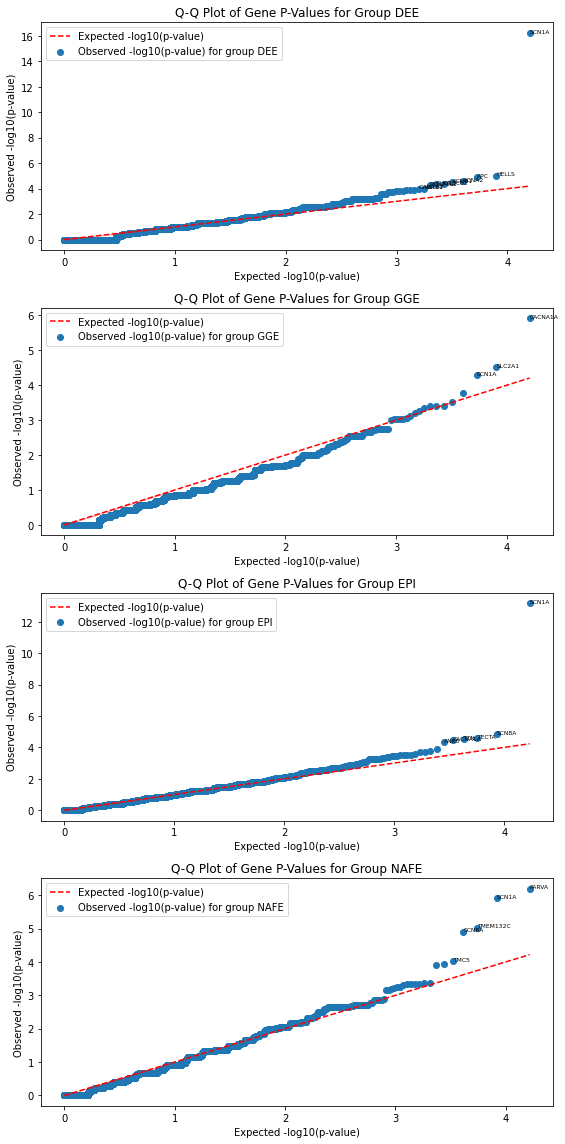

In [17]:
plot_group_QQ(significant_genes_df)

### Compare against published results

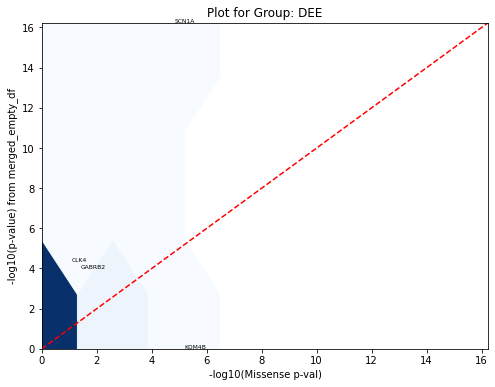

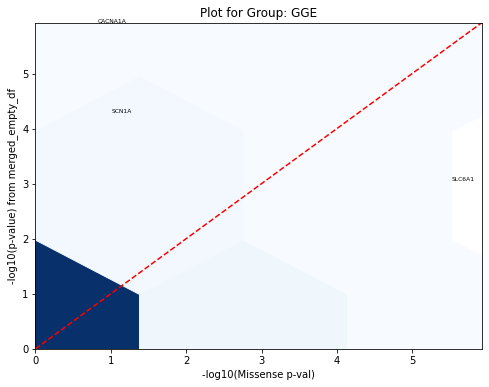

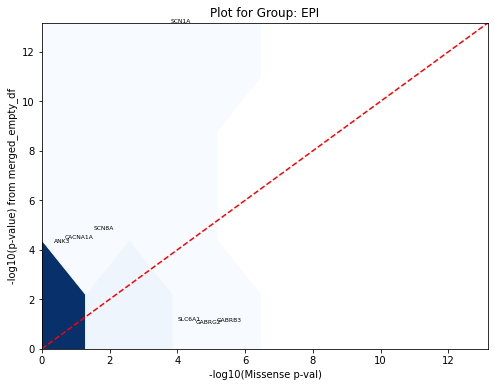

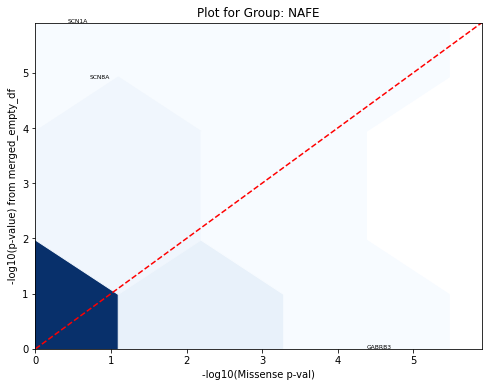

In [19]:
for group in significant_genes_df['group'].unique():
    file_pattern = f"{group}_results_2023_12_30_14_36_*.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Damaging Missense p‑val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")

In [150]:
merged_pub_df[merged_pub_df['gene_name'] == "SCN8A"]

gene_id gene_name group  total_ac_case  total_an_case  \
9362  ENSG00000196876     SCN8A  NAFE           16.0        18438.0   

      total_ac_ctrl  total_an_ctrl  odds_ratio   p_value             Gene  \
9362           10.0        66888.0    5.808533  0.000012  ENSG00000196876   

      ... PTV Case Count  PTV Control Count  PTV p‑val  PTV odds ratio  \
9362  ...              1                  5    0.99686          1.0037   

      Damaging Missense Case Count  Damaging Missense Control Count  \
9362                            27                               71   

      Damaging Missense p‑val  Damaging Missense odds ratio  minus_log_pval  \
9362                  0.19048                         1.373        4.904917   

      minus_log_missense_pval  
9362                 0.720151  

[1 rows x 23 columns]

### GeneBass exomes revisted

In [151]:
import pickle

mrp_df = predictions_df

# Save mrp_df as a Pickle file
mrp_df.to_pickle("mrp_df.pkl")

In [85]:
#Read in files, process, generate map file and then run MRP from Jupyter 
prop_thr = 0.6
import pandas as pd
gb_path = "Epilepsy_custom.genebass.tsv.gz"
gb_df = pd.read_csv(gb_path, sep='\t', compression='gzip')
print(gb_df.shape)
gb_filtered_df = gb_df[~gb_df['annotation'].isin(['LC', 'NA', 'synonymous']) & (gb_df['AC'] <= 5)]
#gb_filtered_df = gb_df[~gb_df['annotation'].isin(['LC', 'NA', 'synonymous']) ]
print(gb_filtered_df.shape)
# Processing 'locus' to get '#CHROM' and 'POS'
gb_filtered_df['#CHROM'] = gb_filtered_df['locus'].apply(lambda x: x.split(':')[0].replace('chr', ''))
gb_filtered_df['#CHROM'] = gb_filtered_df["#CHROM"].astype(str)
gb_filtered_df['POS'] = gb_filtered_df['locus'].apply(lambda x: x.split(':')[1])
# Convert to string if necessary (adjust as per your data types)
gb_filtered_df['POS'] = gb_filtered_df['POS'].astype(str)
mrp_df['pos'] = mrp_df['pos'].astype(str)
mrp_df['chr'] = mrp_df['chr'].astype(str)
# Merging DataFrames
#print(mrp_df[(mrp_df['chr'] == "17") & (mrp_df['pos'] == "7885025")])
value_counts = mrp_df['chr'].value_counts()
print(value_counts)
gb_filtered_df = pd.merge(gb_filtered_df, mrp_df, left_on=['#CHROM', 'POS'], right_on=['chr', 'pos'])
print(gb_filtered_df[(gb_filtered_df['#CHROM'] == "17") & (gb_filtered_df['POS'] == "7885025")])
gb_filtered_df = gb_filtered_df[gb_filtered_df['prob_0'] >= prop_thr]
#print(gb_filtered_df.shape)
# Processing 'markerID' to get 'REF' and 'ALT'
gb_filtered_df['REF'] = gb_filtered_df['markerID'].apply(lambda x: x.split('_')[1].split('/')[0])
gb_filtered_df['ALT'] = gb_filtered_df['markerID'].apply(lambda x: x.split('_')[1].split('/')[1])
gb_filtered_df['V'] = gb_filtered_df['#CHROM'] + ':' + gb_filtered_df['POS'] + ':' + gb_filtered_df['REF'] + ':' + gb_filtered_df['ALT']
meta_var_df = gb_filtered_df[['V', 'gene', 'annotation', 'AF']].copy()
meta_var_df['ld_indep'] = True
meta_var_df['pLI'] = "NA"
meta_var_df['MPC'] = "NA"
meta_var_df.rename(columns={
    'V': 'V',
    'gene': 'gene_symbol',
    'annotation': 'most_severe_consequence',
    'AF': 'maf'
}, inplace=True)

gb_filtered_df['P'] = gb_filtered_df["Pvalue"]
# Keeping 'BETA', 'SE', and 'Pvalue'
gb_filtered_df = gb_filtered_df[['#CHROM', 'POS', 'REF', 'ALT', 'BETA', 'SE', 'P']]
fileout = gb_path.split('.')[0] + "_sumstat.tsv.gz"
gb_filtered_df.to_csv(fileout, sep='\t', index=False, compression='gzip')

fileout_pre = fileout.split('.')[0]  # Replace with the actual prefix
map_file_name = fileout_pre + ".map"

with open(map_file_name, 'w') as f:
    f.write("path\tstudy\tpheno\tR_phen\n")
    f.write(f"{fileout}\tstudy1\tpheno1\tFALSE\n")  # Replace 'study1' and 'pheno1' with actual values
    

meta_var_filename = fileout_pre + ".meta.gz"

# Write meta_var_df to a tab-separated file
meta_var_df.to_csv(meta_var_filename, sep='\t', index=False, compression="gzip")
!python mrp/mrp.py --sigma_m_types sigma_m_var --file {map_file_name} --build hg38 --R_var independent similar --metadata {meta_var_filename} --variants pav ptv --se_thresh 1000000000000000000


(7823740, 31)
(4090092, 31)


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is try

1     3380119
2     2457680
19    2234481
11    1984372
3     1950694
17    1901748
12    1791120
6     1714677
5     1548359
7     1531381
16    1366699
9     1344526
4     1331683
10    1310128
15    1141775
8     1119857
14    1059970
20     812688
22     681114
13     621634
18     532825
21     316182
Name: chr, dtype: int64
                 locus                                        alleles  \
3128645  chr17:7885025                          ["C","CCCGCCGCCGCCG"]   
3128646  chr17:7885025                       ["C","CCCGCCGCCGCCGCCG"]   
3128647  chr17:7885025  ["CCCGCCGCCGCCGCCGCCGCCGCCACCGCTGCCCCCG","C"]   

                                                  markerID  gene annotation  \
3128645                      chr17:7885025_C/CCCGCCGCCGCCG  CHD3   missense   
3128646                   chr17:7885025_C/CCCGCCGCCGCCGCCG  CHD3   missense   
3128647  chr17:7885025_CCCGCCGCCGCCGCCGCCGCCGCCACCGCTGC...  CHD3   missense   

                                                call_stats

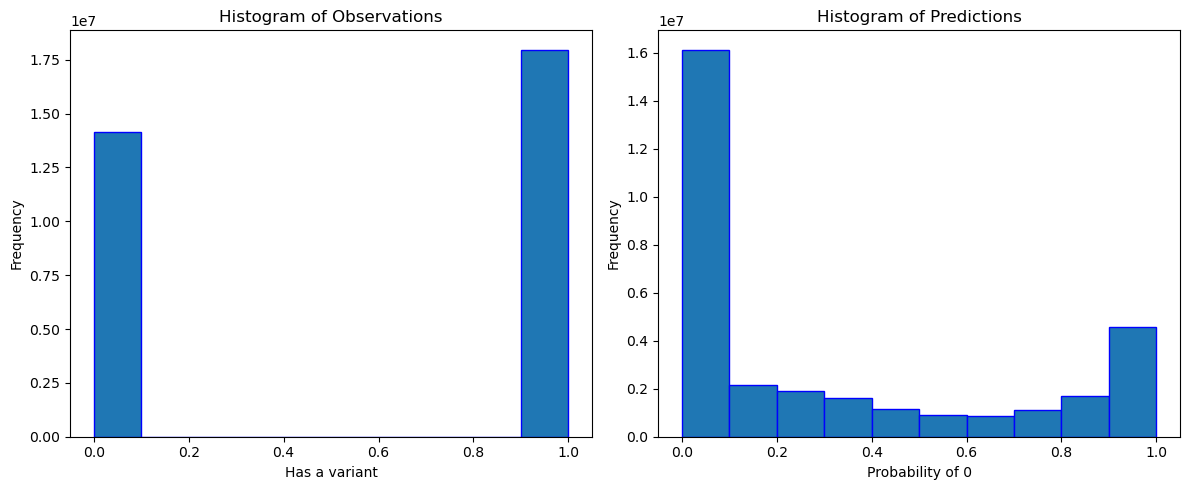

In [154]:
plot_hist_from_predictions(mrp_df)

In [80]:
!python mrp/mrp.py --sigma_m_types sigma_m_var --file {map_file_name} --build hg38 --R_var independent similar --metadata {meta_var_filename} --variants pav ptv --se_thresh 1000000000000000000



 __  __ ____  ____
|  \/  |  _ \|  _ \
| |\/| | |_) | |_) |
| |  | |  _ <|  __/ 
|_|  |_|_| \_\_|  

Production Author:
Guhan Ram Venkataraman, B.S.H.
Ph.D. Candidate | Biomedical Informatics

Contact:
Email: guhan@stanford.edu
URL: https://github.com/rivas-lab/mrp

Methods Developers:
Manuel A. Rivas, Ph.D.; Matti Pirinen, Ph.D.
Rivas Lab | Stanford University

Valid command line arguments. Importing required packages...

Map file passes initial checks.

Reading in summary statistics for:

Populations: study1
Phenotypes: pheno1

study1 pheno1 56472x4 30850_sumstat.tsv.gz

Merging summary statistics together...
Merging with metadata...
Setting sigmas...
summary statistics df: 56472x12
Correlation of errors, SE threshold = 1e+18:
[[1.]]

R_phen:
[[1.]]

Running MRP across parameters for MAF threshold 0.01 and SE threshold 1e+18...

Analysis: pav
R_study model: similar
R_var model: independent
Aggregation by: gene
Variant weighting factor: sigma_m_var
MAF threshold: 0.01
SE threshold: 1

## Autism

In [77]:
# Read the data into a DataFrame
aut_df = pd.read_csv(data_path + 'aut.tsv.gz', sep='\t')

# Reset the index before assigning values
aut_df[['chr', 'pos','ref','alt']] = aut_df['v'].str.split(':', expand=True)

# Convert 'chr' and 'pos' columns to integers
aut_df['chr'] = 'chr' + aut_df['chr'].astype(str)

# Ensure that the 'pos' column is converted to integers
aut_df['pos'] = pd.to_numeric(aut_df['pos'], errors='coerce').fillna(0).astype(int)

filter_variant_list = [
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "coding_sequence_variant",
    "downstream_gene_variant",
    "intergenic_variant",
    "intron_variant",
    "mature_miRNA_variant",
     "non_coding_transcript_exon_variant",
    "non_coding_transcript_variant",
    "null",
    "synonymous_variant",
    "upstream_gene_variant",
    "splice_region_variant",
    "inframe_insertion",
    "inframe_deletion",
    "stop_retained_variant",
    "protein_altering_variant"
]

# Filter rows
aut_df = aut_df[~aut_df['consequence'].isin(filter_variant_list)]
aut_df = aut_df[~aut_df['consequence'].isna()]

# Apply the liftover function to each row in the DataFrame
aut_df[['chr', 'pos']] = aut_df.apply(liftover, axis=1, result_type='expand')

aut_df = aut_df[(aut_df['chr'] != "chrX") & (aut_df['chr'] != "chrY") & (aut_df['chr'] != "chrMT")]

aut_df

v          gene_id       consequence     hgvsc  \
3           1:138532:A:G  ENSG00000237683         stop_lost  c.778T>C   
4           1:138543:C:T  ENSG00000237683  missense_variant  c.767G>A   
5           1:138565:G:A  ENSG00000237683  missense_variant  c.745C>T   
6           1:138582:G:A  ENSG00000237683  missense_variant  c.728C>T   
9           1:138817:T:C  ENSG00000237683  missense_variant  c.493A>G   
...                  ...              ...               ...       ...   
1552854  22:51215124:G:A  ENSG00000079974  missense_variant  c.191C>T   
1552855  22:51215134:G:A  ENSG00000079974  missense_variant  c.181C>T   
1552857  22:51215173:G:A  ENSG00000079974  missense_variant  c.142C>T   
1552859  22:51220617:T:G  ENSG00000079974  missense_variant  c.106A>C   
1552860  22:51220671:C:T  ENSG00000079974  missense_variant   c.52G>A   

                      hgvsp        locus    alleles  mpc           polyphen  \
3        p.Ter260ArgextTer2     1:138532  ["A","G"]  NaN                NaN   
4               p.Arg256Lys     1:138543  ["C","T"]  NaN             benign   
5               p.Leu249Phe     1:138565  ["G","A"]  NaN  possibly_damaging   
6               p.Pro243Leu     1:138582  ["G","A"]  NaN            unknown   
9               p.Ser165Gly     1:138817  ["T","C"]  NaN             benign   
...                     ...          ...        ...  ...                ...   
1552854          p.Thr64Met  22:51215124  ["G","A"]  NaN             benign   
1552855          p.His61Tyr  22:51215134  ["G","A"]  NaN             benign   
1552857          p.Pro48Ser  22:51215173  ["G","A"]  NaN             benign   
1552859          p.Lys36Gln  22:51220617  ["T","G"]  NaN  possibly_damaging   
1552860          p.Ala18Thr  22:51220671  ["C","T"]  NaN             benign   

        group  ac_case  an_case  ac_ctrl  an_ctrl  in_analysis    chr  \
3         DBS        1   9512.0        0  10368.0        False   chr1   
4         DBS        0   9504.0        1  10368.0        False   chr1   
5         DBS       38   9410.0       46  10286.0        False   chr1   
6         DBS        1   9266.0        0  10224.0        False   chr1   
9         DBS       80   9524.0       86  10298.0        False   chr1   
...       ...      ...      ...      ...      ...          ...    ...   
1552854   DBS        1   9622.0        0  10428.0         True  chr22   
1552855   DBS        3   9622.0        2  10428.0        False  chr22   
1552857   DBS        0   9622.0        1  10428.0         True  chr22   
1552859   DBS        1   9184.0        0  10172.0        False  chr22   
1552860   DBS        7   9140.0        7  10162.0        False  chr22   

              pos ref alt  
3          138532   A   G  
4          138543   C   T  
5          138565   G   A  
6          138582   G   A  
9          138817   T   C  
...           ...  ..  ..  
1552854  50776696   G   A  
1552855  50776706   G   A  
1552857  50776745   G   A  
1552859  50782189   T   G  
1552860  50782243   C   T  

[800907 rows x 19 columns]

In [ ]:
# Parameters for analysis
prop_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = aut_df
predictions_df = pd.read_csv('HMM_wgs_constraint_predictions.tsv.gz', sep='\t')

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    # Get results for the chromosome
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] < cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]
    
    # Get predictions for the chromosome
    chr_predictions_df = predictions_df[predictions_df['chr'] == 'chr2']
    
    # Filter variant results for positions over probability threshold
    cases_df = pd.merge(chr_predictions_df[chr_predictions_df['prob_0'] >= prop_thr]['pos'],
                        chr_variant_results_df, on='pos')

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)

    # Create a new column for standardized gene_id
    chr_gene_df['std_gene_id'] = chr_gene_df['gene_id'].str.split('.').str[0]
    
    # Drop duplicates in gene_df based on std_gene_id if necessary
    unique_genes_df = chr_gene_df.drop_duplicates(subset='std_gene_id')[["std_gene_id","gene_name"]]

    # Merge with gene names using gene_id and drop the join key
    tested_df = pd.merge(tested_df, 
                         unique_genes_df, 
                         right_on='std_gene_id', 
                         left_on='gene_id', 
                         how='left'
                        ).drop('std_gene_id', axis=1)
    
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(project_path + "aut_wgs_contraint_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

significant_genes_df

In [78]:
# Parameters for analysis
prop_thr = 0.6
cnt_thr = 5
coverage_thr = 0.5
order = 2
significance_thr = 1
variant_results_df = aut_df

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observations'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    chr_variants_df = variants_df[variants_df['chr'] == chromnum]
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum)) & (coverage_df['over_10'] > coverage_thr)]
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                                  (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] < cnt_thr) & 
                                                  (variant_results_df['an_case'] > 0) & 
                                                  (variant_results_df['an_ctrl'] > 0)]
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': chromnum,
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Append predictions to overall df
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
#     # Calculate the proportion of each gene with probability of observing 0 > threshold
#     chr_gene_df['proportion_over_thr'] = chr_gene_df.apply(lambda row: calculate_overlap(row, pos_over_thr), axis=1)
    
    # Filter variant results for positions over probability threshold
    cases_df = pd.merge(chr_predictions_df[chr_predictions_df['prob_0'] >= prop_thr]['pos'],
                        chr_variant_results_df, on='pos')

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)

    # Create a new column for standardized gene_id
    chr_gene_df['std_gene_id'] = chr_gene_df['gene_id'].str.split('.').str[0]
    
    # Drop duplicates in gene_df based on std_gene_id if necessary
    unique_genes_df = chr_gene_df.drop_duplicates(subset='std_gene_id')[["std_gene_id","gene_name"]]

    # Merge with gene names using gene_id and drop the join key
    tested_df = pd.merge(tested_df, 
                         unique_genes_df, 
                         right_on='std_gene_id', 
                         left_on='gene_id', 
                         how='left'
                        ).drop('std_gene_id', axis=1)
    
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
#     # Display the sorted DataFrame
#     print(tested_df[tested_df['p_value'] < .0001])

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


TypeError: get_HMM_predictions() missing 1 required positional argument: 'model'

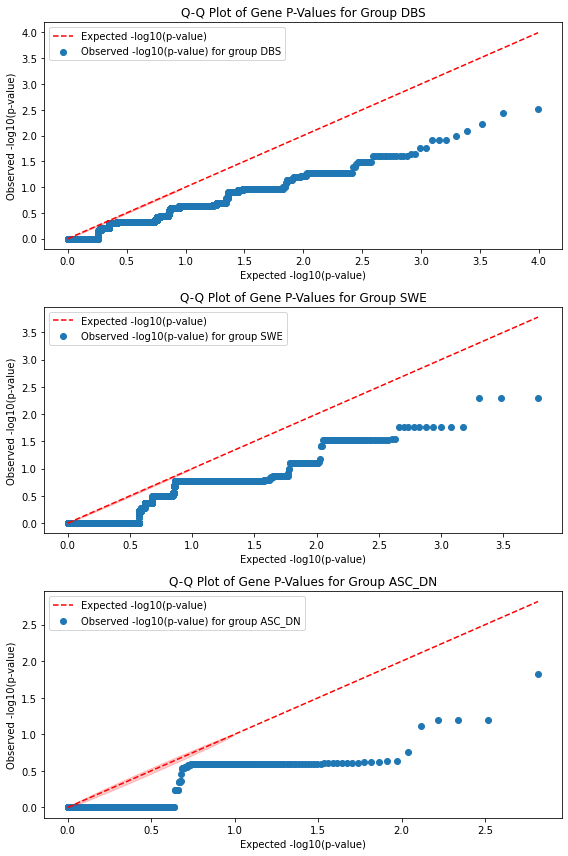

In [35]:
plot_group_QQ(significant_genes_df)

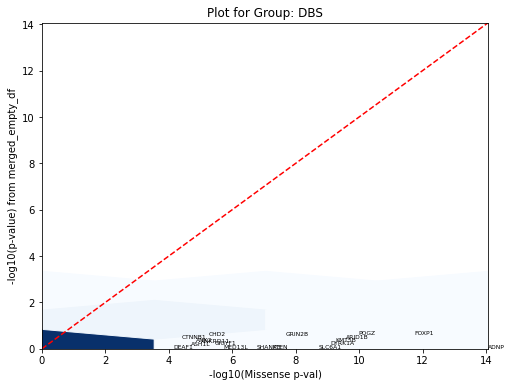

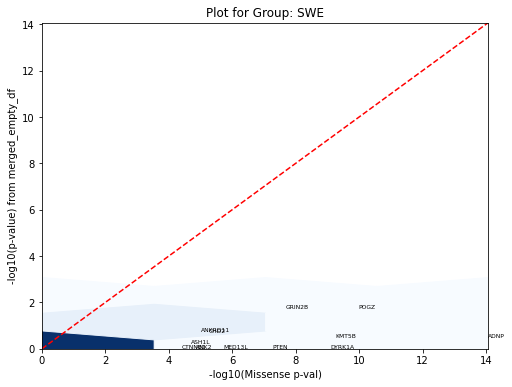

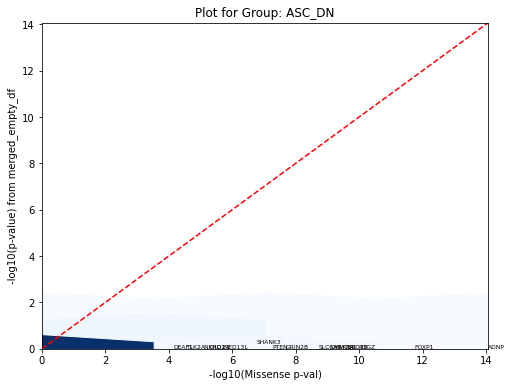

In [36]:
for group in significant_genes_df['group'].unique():
    file_pattern = f"Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")

### Analyze with Alpha Missense Results

In [81]:
# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

aut_dropped_df = aut_df.drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "v", "in_analysis", "chr", "ref", "alt"])

merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on='pos', how='inner'), aut_dropped_df, on='pos', how='inner')

merged_df = merged_df[(merged_df['ac_case'] > 0) & (merged_df['ac_ctrl'] > 0)]

# Calculating odds and log odds ratio
merged_df['odds_case'] = merged_df['ac_case'] / (merged_df['an_case'] - merged_df['ac_case'])
merged_df['odds_ctrl'] = merged_df['ac_ctrl'] / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])
merged_df['effect_size'] = np.log(merged_df['odds_case'] / merged_df['odds_ctrl'])

# Calculating the variance of log odds ratio
merged_df['var_effect_size'] = 1 / merged_df['ac_case'] + 1 / (merged_df['an_case'] - merged_df['ac_case']) + 1 / merged_df['ac_ctrl'] + 1 / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_aut_results.tsv.gz", index=False, compression='gzip', sep='\t')

# Get unique values in the 'gene_id' column
unique_genes = merged_df['gene_id'].unique()

# Initialize lists to store p-values
p_values_prob_0 = []
p_values_am_pathogenicity = []

# Loop over each gene and build a meta-regression model
for current_gene in unique_genes:
    # Subset the data for the current gene
    gene_data = merged_df[merged_df['gene_id'] == current_gene]
    
    # Check if there are at least 2 unique values in the dependent variable
    try:
        # Meta-regression model for the current gene
        X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
        y = np.log(gene_data['effect_size'])
        weights = 1 / np.sqrt(gene_data['var_effect_size'])  # Assuming the weights are based on the square root of var_effect_size

        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Get p-values for prob_0 and am_pathogenicity
        p_value_prob_0 = model.pvalues['prob_0']
        p_value_am_pathogenicity = model.pvalues['am_pathogenicity']

        # Append p-values to lists
        p_values_prob_0.append(p_value_prob_0)
        p_values_am_pathogenicity.append(p_value_am_pathogenicity)
        
    except:
        pass

# Combine p-values using Fisher's method
fisher_combined_p_prob_0 = fisher_method_p_value(np.array(p_values_prob_0))
fisher_combined_p_am_pathogenicity = fisher_method_p_value(np.array(p_values_am_pathogenicity))

# Print combined p-values
print(f"Combined p-value for prob_0: {fisher_combined_p_prob_0}")
print(f"Combined p-value for am_pathogenicity: {fisher_combined_p_am_pathogenicity}")

Combined p-value for prob_0: 0.0
Combined p-value for am_pathogenicity: 0.0


## Bipolar

In [41]:
# Read the data into a DataFrame
BipEx_variant_results_df = pd.read_csv('BipEx_variant_results.tsv.bgz', sep='\t', compression='gzip')

# Split locus into chr and pos and convert to integers
BipEx_variant_results_df[['chr', 'pos']] = BipEx_variant_results_df['locus'].str.split(':', expand=True)
BipEx_variant_results_df['pos'] = BipEx_variant_results_df['pos'].astype(int)

# Filter out rows
BipEx_variant_results_df = BipEx_variant_results_df[(BipEx_variant_results_df['chr'] != "chrX") & (BipEx_variant_results_df['chr'] != "chrY") & (BipEx_variant_results_df['chr'] != "chrMT")]
BipEx_variant_results_df = BipEx_variant_results_df[(BipEx_variant_results_df['consequence'] != "synonymous") & 
                                                    (BipEx_variant_results_df['consequence'] != "non_coding") & 
                                                    (BipEx_variant_results_df['consequence'] != "NA") & 
                                                    (~BipEx_variant_results_df['consequence'].isna())]

BipEx_variant_results_df

locus    alleles          gene_id     consequence  \
1382         chr1:925922  ["G","A"]  ENSG00000187634  other_missense   
1383         chr1:925922  ["G","A"]  ENSG00000187634  other_missense   
1384         chr1:925922  ["G","A"]  ENSG00000187634  other_missense   
1385         chr1:925923  ["G","C"]  ENSG00000187634  other_missense   
1386         chr1:925923  ["G","C"]  ENSG00000187634  other_missense   
...                  ...        ...              ...             ...   
22714981  chr22:50782243  ["C","T"]  ENSG00000079974  other_missense   
22714982  chr22:50782243  ["C","T"]  ENSG00000079974  other_missense   
22714989  chr22:50782290  ["G","C"]  ENSG00000079974  other_missense   
22714990  chr22:50782290  ["G","C"]  ENSG00000079974  other_missense   
22714991  chr22:50782290  ["G","C"]  ENSG00000079974  other_missense   

             hgvsc       hgvsp   cadd  mpc           polyphen  \
1382      c.-20G>A         NaN  22.30  NaN                NaN   
1383      c.-20G>A         NaN  22.30  NaN                NaN   
1384      c.-20G>A         NaN  22.30  NaN                NaN   
1385      c.-19G>C         NaN  20.20  NaN                NaN   
1386      c.-19G>C         NaN  20.20  NaN                NaN   
...            ...         ...    ...  ...                ...   
22714981   c.52G>A  p.Ala18Thr  18.69  NaN             benign   
22714982   c.52G>A  p.Ala18Thr  18.69  NaN             benign   
22714989    c.5C>G   p.Ala2Gly  24.10  NaN  possibly_damaging   
22714990    c.5C>G   p.Ala2Gly  24.10  NaN  possibly_damaging   
22714991    c.5C>G   p.Ala2Gly  24.10  NaN  possibly_damaging   

                                                 group  ... an_case  ac_ctrl  \
1382                                  Bipolar Disorder  ...   27842        0   
1383      Bipolar Disorder (including Schizoaffective)  ...   28396        0   
1384                                Bipolar Disorder 1  ...   16470        0   
1385                                  Bipolar Disorder  ...   27842        1   
1386      Bipolar Disorder (including Schizoaffective)  ...   28396        1   
...                                                ...  ...     ...      ...   
22714981               Bipolar Disorder with Psychosis  ...    8810       15   
22714982            Bipolar Disorder without Psychosis  ...    7624       15   
22714989                              Bipolar Disorder  ...   27866        0   
22714990  Bipolar Disorder (including Schizoaffective)  ...   28420        0   
22714991                            Bipolar Disorder 1  ...   16476        0   

          an_ctrl  estimate  chi_sq_stat  p_value  in_analysis  \
1382        28844       NaN          NaN      NaN         True   
1383        28844       NaN          NaN      NaN         True   
1384        28844       NaN          NaN      NaN         True   
1385        28844       NaN          NaN      NaN         True   
1386        28844       NaN          NaN      NaN         True   
...           ...       ...          ...      ...          ...   
22714981    28844   0.31788      0.43477  0.50966        False   
22714982    28844   0.38228      0.45574  0.49962        False   
22714989    28844       NaN          NaN      NaN         True   
22714990    28844       NaN          NaN      NaN         True   
22714991    28844       NaN          NaN      NaN         True   

          in_gnomad_non_neuro    chr       pos  
1382                    False   chr1    925922  
1383                    False   chr1    925922  
1384                    False   chr1    925922  
1385                    False   chr1    925923  
1386                    False   chr1    925923  
...                       ...    ...       ...  
22714981                 True  chr22  50782243  
22714982                 True  chr22  50782243  
22714989                False  chr22  50782290  
22714990                False  chr22  50782290  
22714991                False  chr22  50782290  

[9867264 rows x 22 columns]

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


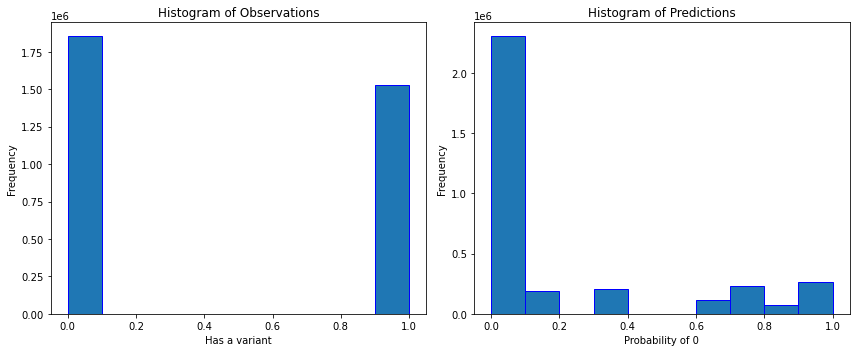

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.377e+06
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:13:11   Log-Likelihood:            -1.8599e+06
No. Observations:             3380119   AIC:                         3.720e+06
Df Residuals:                 3380117   BIC:                         3.720e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6158      0.000   2300.560      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


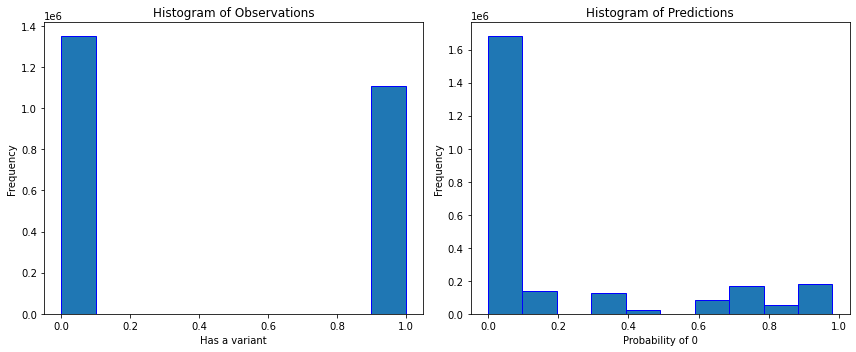

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 1.002e+06
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:17:14   Log-Likelihood:            -1.3518e+06
No. Observations:             2457680   AIC:                         2.704e+06
Df Residuals:                 2457678   BIC:                         2.704e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6171      0.000   1959.954      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


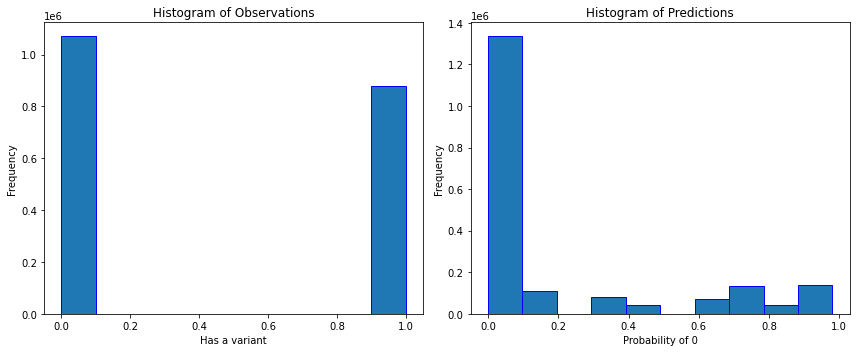

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.997e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:20:10   Log-Likelihood:            -1.0714e+06
No. Observations:             1950694   AIC:                         2.143e+06
Df Residuals:                 1950692   BIC:                         2.143e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6183      0.000   1749.482      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


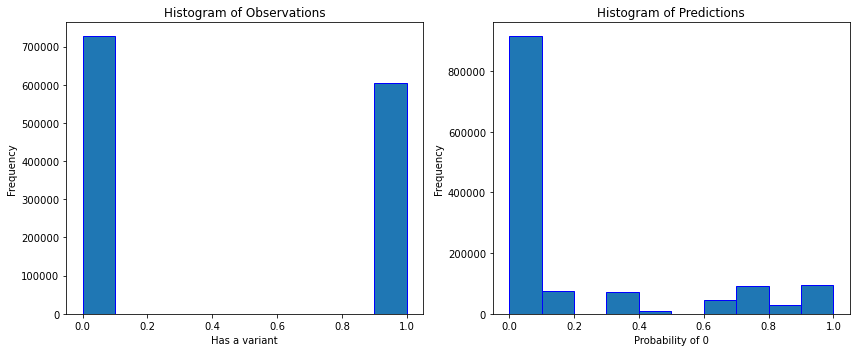

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 5.443e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:22:43   Log-Likelihood:            -7.3265e+05
No. Observations:             1331683   AIC:                         1.465e+06
Df Residuals:                 1331681   BIC:                         1.465e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6200      0.000   1450.062      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


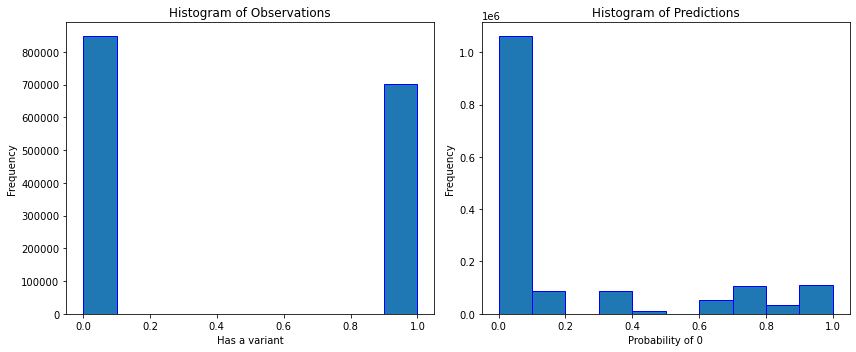

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 6.351e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:24:47   Log-Likelihood:            -8.5069e+05
No. Observations:             1548359   AIC:                         1.701e+06
Df Residuals:                 1548357   BIC:                         1.701e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6192      0.000   1561.637      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


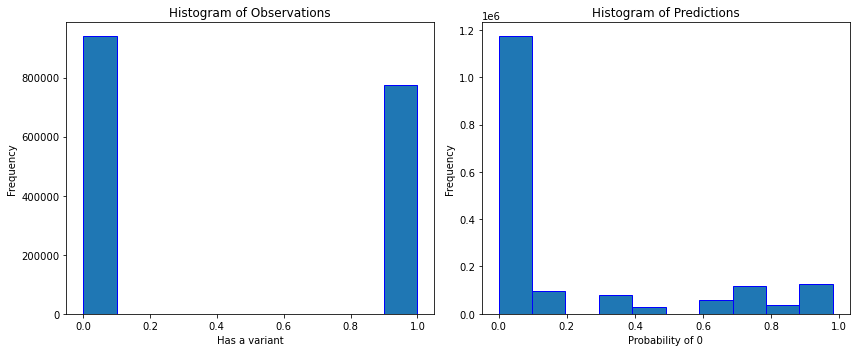

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.032e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:27:09   Log-Likelihood:            -9.4183e+05
No. Observations:             1714677   AIC:                         1.884e+06
Df Residuals:                 1714675   BIC:                         1.884e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6182      0.000   1641.571      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


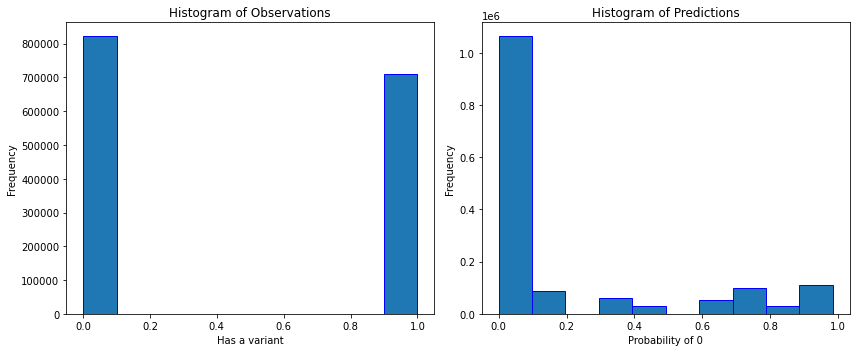

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 6.224e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:29:39   Log-Likelihood:            -8.4617e+05
No. Observations:             1531381   AIC:                         1.692e+06
Df Residuals:                 1531379   BIC:                         1.692e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6253      0.000   1574.953      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


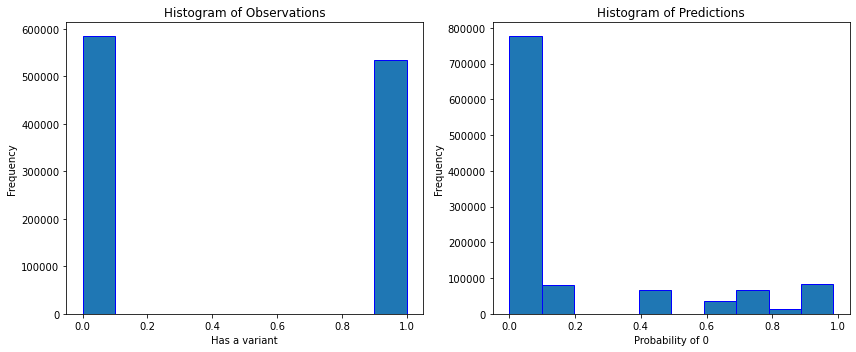

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 4.643e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:31:56   Log-Likelihood:            -6.1751e+05
No. Observations:             1119857   AIC:                         1.235e+06
Df Residuals:                 1119855   BIC:                         1.235e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6420      0.000   1383.492      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


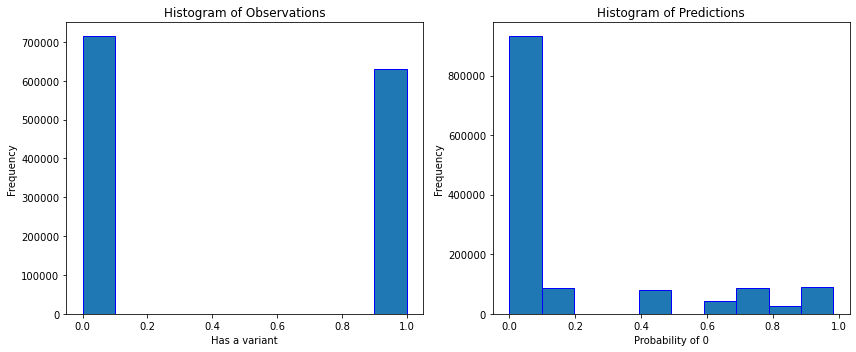

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 5.487e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:33:54   Log-Likelihood:            -7.4313e+05
No. Observations:             1344526   AIC:                         1.486e+06
Df Residuals:                 1344524   BIC:                         1.486e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6316      0.000   1488.965      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


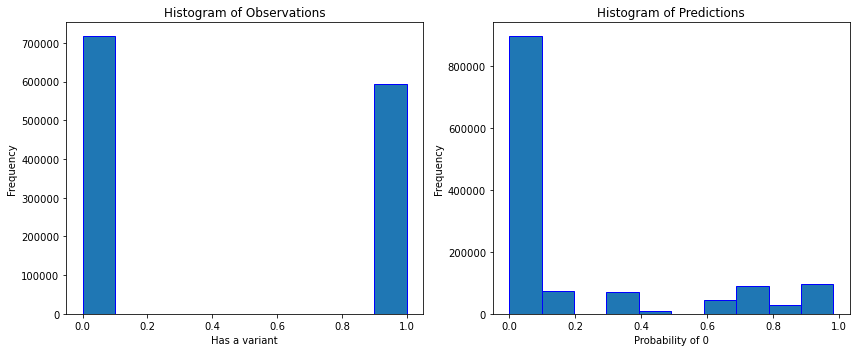

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 5.344e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:36:02   Log-Likelihood:            -7.2084e+05
No. Observations:             1310128   AIC:                         1.442e+06
Df Residuals:                 1310126   BIC:                         1.442e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6178      0.000   1434.701      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


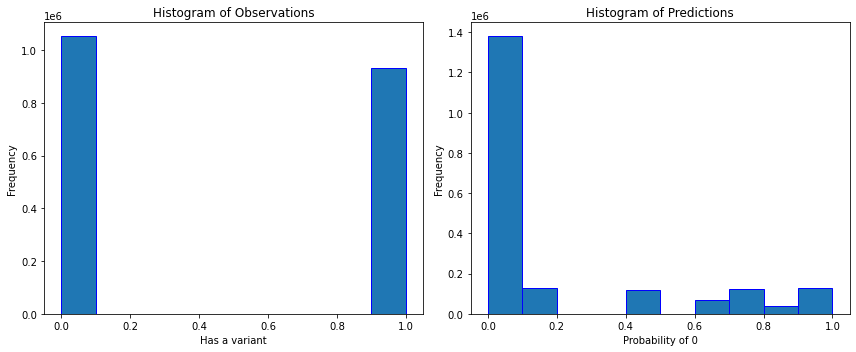

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 8.068e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:38:25   Log-Likelihood:            -1.0980e+06
No. Observations:             1984372   AIC:                         2.196e+06
Df Residuals:                 1984370   BIC:                         2.196e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6319      0.000   1809.869      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


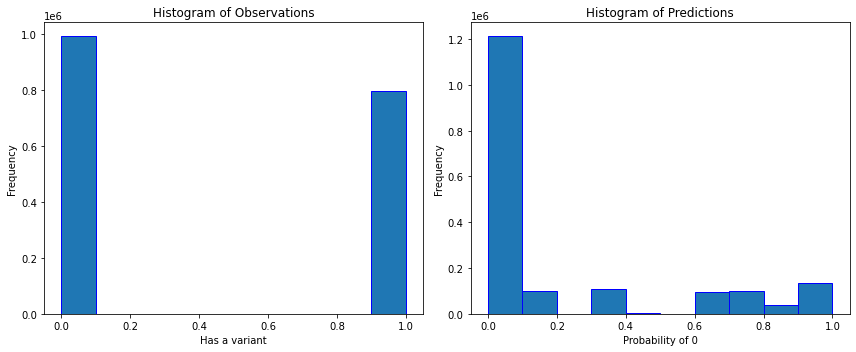

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 7.441e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:41:21   Log-Likelihood:            -9.7803e+05
No. Observations:             1791120   AIC:                         1.956e+06
Df Residuals:                 1791118   BIC:                         1.956e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6151      0.000   1666.801      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


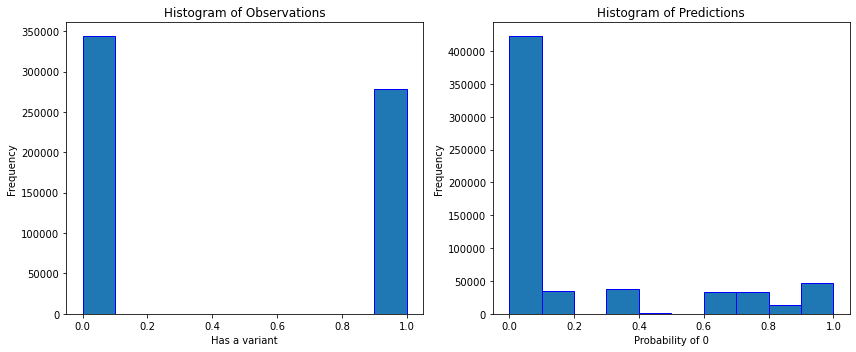

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 2.557e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:43:52   Log-Likelihood:            -3.4060e+05
No. Observations:              621634   AIC:                         6.812e+05
Df Residuals:                  621632   BIC:                         6.812e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6151      0.001    982.377      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


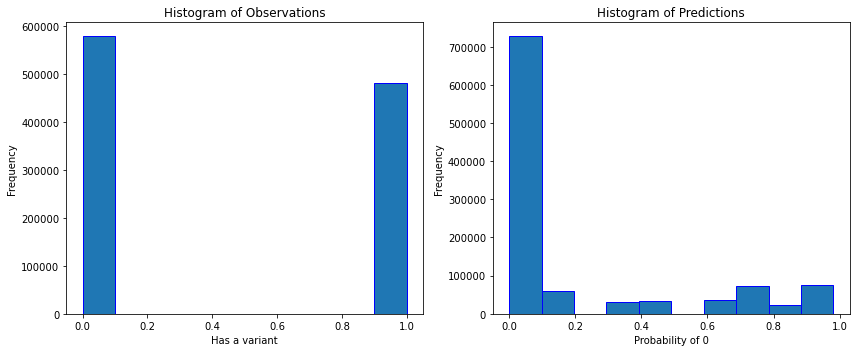

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 4.357e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:45:27   Log-Likelihood:            -5.8239e+05
No. Observations:             1059970   AIC:                         1.165e+06
Df Residuals:                 1059968   BIC:                         1.165e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6215      0.000   1296.366      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


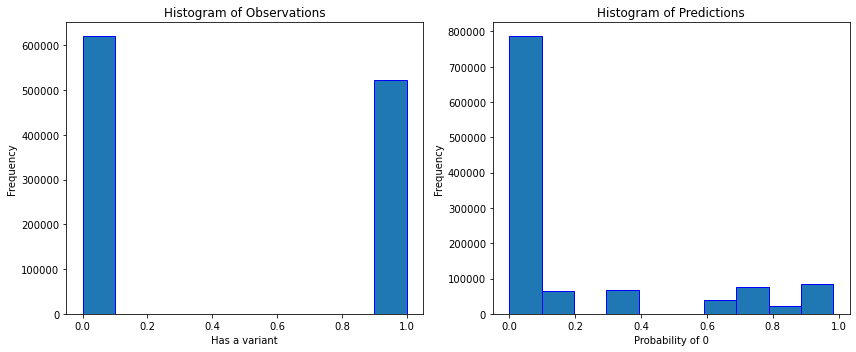

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                 4.574e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:47:32   Log-Likelihood:            -6.3211e+05
No. Observations:             1141775   AIC:                         1.264e+06
Df Residuals:                 1141773   BIC:                         1.264e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6181      0.000   1342.434      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


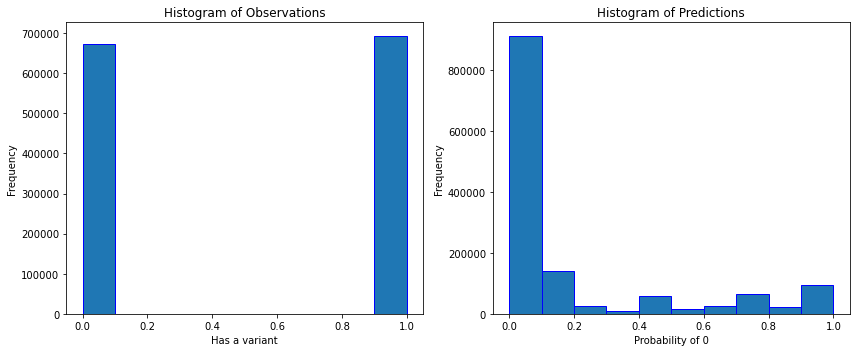

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                 5.830e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:49:43   Log-Likelihood:            -7.4904e+05
No. Observations:             1366699   AIC:                         1.498e+06
Df Residuals:                 1366697   BIC:                         1.498e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6733      0.000   1605.647      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


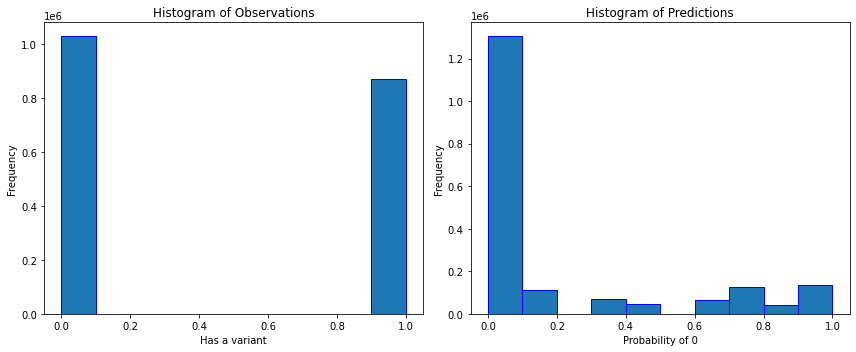

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 7.903e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:52:11   Log-Likelihood:            -1.0432e+06
No. Observations:             1901748   AIC:                         2.086e+06
Df Residuals:                 1901746   BIC:                         2.086e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6254      0.000   1750.870      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


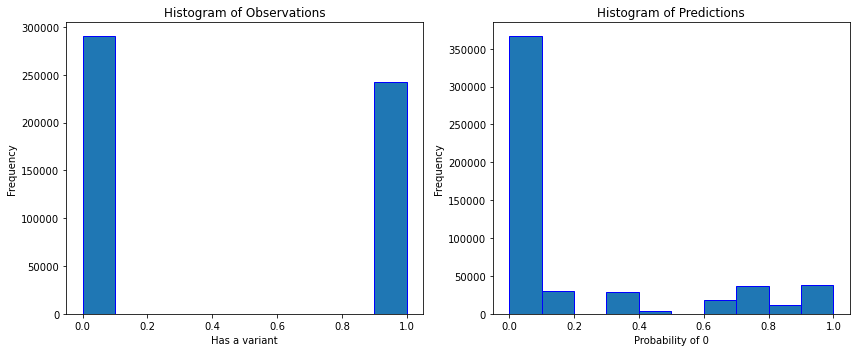

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 2.182e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:54:54   Log-Likelihood:            -2.9313e+05
No. Observations:              532825   AIC:                         5.863e+05
Df Residuals:                  532823   BIC:                         5.863e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6209      0.001    919.659      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


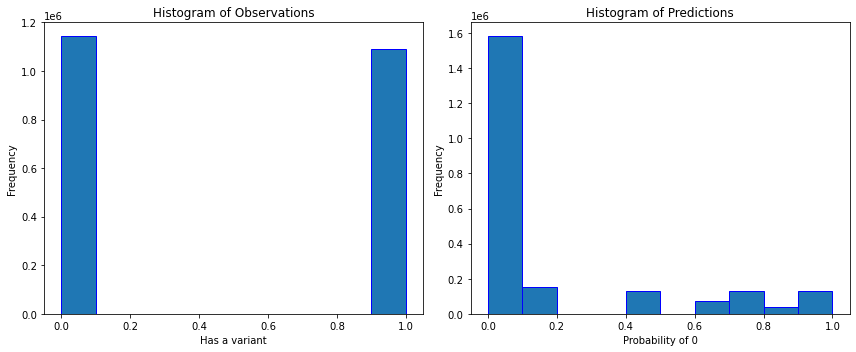

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 9.076e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:56:52   Log-Likelihood:            -1.2403e+06
No. Observations:             2234481   AIC:                         2.481e+06
Df Residuals:                 2234479   BIC:                         2.481e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6464      0.000   1976.262      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


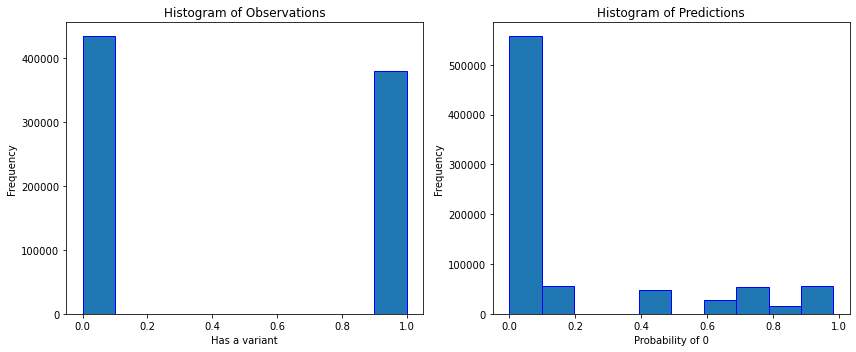

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 3.429e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:00:06   Log-Likelihood:            -4.4496e+05
No. Observations:              812688   AIC:                         8.899e+05
Df Residuals:                  812686   BIC:                         8.900e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6347      0.001   1162.906      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


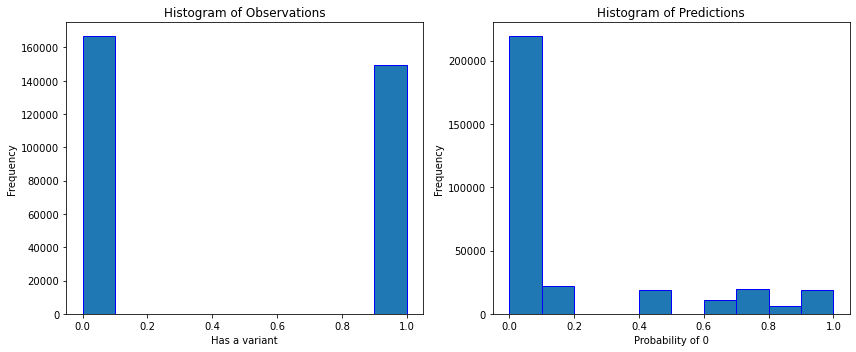

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                 1.324e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:01:55   Log-Likelihood:            -1.7372e+05
No. Observations:              316182   AIC:                         3.475e+05
Df Residuals:                  316180   BIC:                         3.475e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6396      0.001    730.838      0.0

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


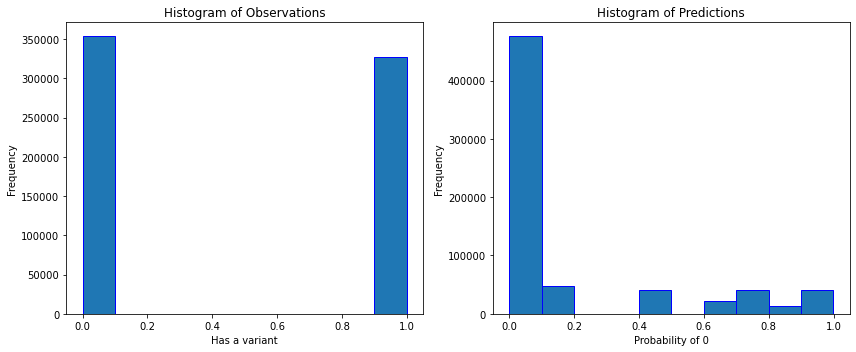

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 2.825e+05
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:03:25   Log-Likelihood:            -3.7566e+05
No. Observations:              681114   AIC:                         7.513e+05
Df Residuals:                  681112   BIC:                         7.513e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6435      0.001   1083.061      0.0

In [42]:
# Parameters for analysis
prop_thr = 0.6
cnt_thr = 5
coverage_thr = 0.5
order = 2
significance_thr = 1
variant_results_df = BipEx_variant_results_df

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observations'])

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    chr_variants_df = variants_df[variants_df['chr'] == chromnum]
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum)) & (coverage_df['over_10'] > coverage_thr)]
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                                  (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] < cnt_thr) & 
                                                  (variant_results_df['an_case'] > 0) & 
                                                  (variant_results_df['an_ctrl'] > 0)]
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': chromnum,
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Append predictions to overall df
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
#     # Calculate the proportion of each gene with probability of observing 0 > threshold
#     chr_gene_df['proportion_over_thr'] = chr_gene_df.apply(lambda row: calculate_overlap(row, pos_over_thr), axis=1)
    
    # Filter variant results for positions over probability threshold
    cases_df = pd.merge(chr_predictions_df[chr_predictions_df['prob_0'] >= prop_thr]['pos'],
                        chr_variant_results_df, on='pos')

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(cases_df)

    # Create a new column for standardized gene_id
    chr_gene_df['std_gene_id'] = chr_gene_df['gene_id'].str.split('.').str[0]
    
    # Drop duplicates in gene_df based on std_gene_id if necessary
    unique_genes_df = chr_gene_df.drop_duplicates(subset='std_gene_id')[["std_gene_id","gene_name"]]

    # Merge with gene names using gene_id and drop the join key
    tested_df = pd.merge(tested_df, 
                         unique_genes_df, 
                         right_on='std_gene_id', 
                         left_on='gene_id', 
                         how='left'
                        ).drop('std_gene_id', axis=1)
    
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
#     # Display the sorted DataFrame
#     print(tested_df[tested_df['p_value'] < .0001])

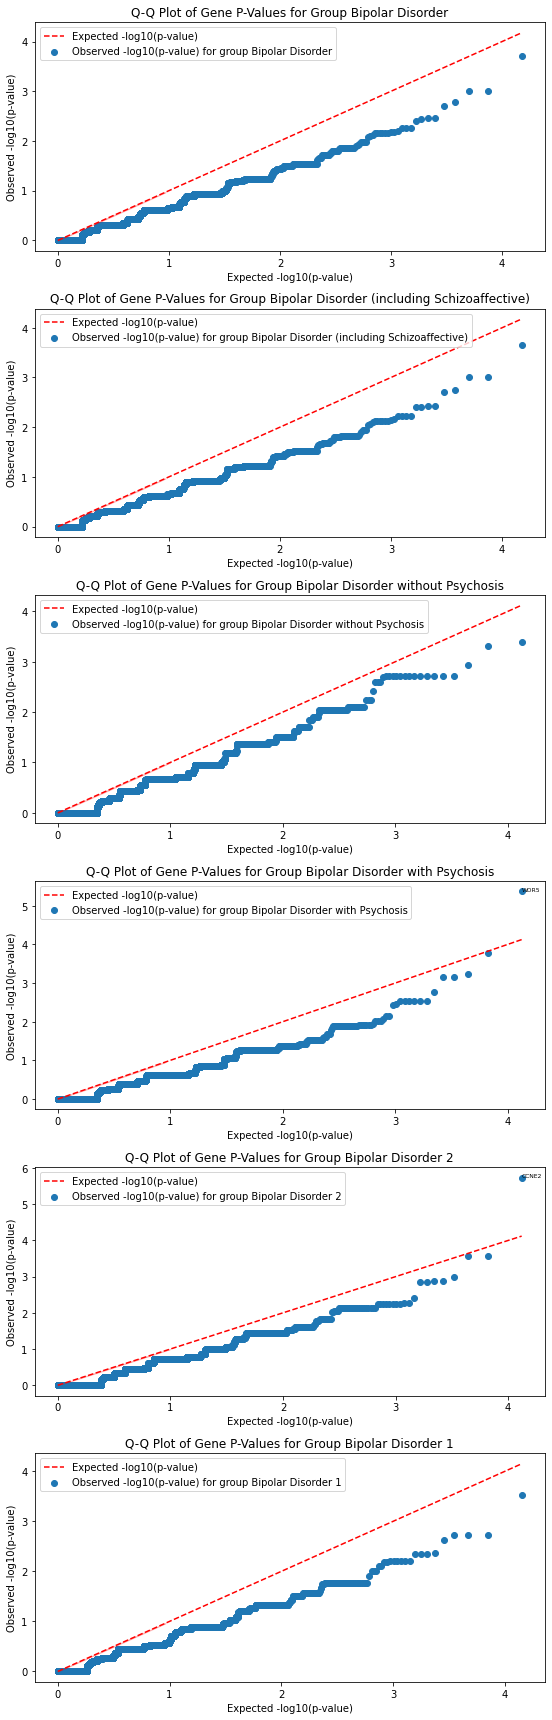

In [43]:
plot_group_QQ(significant_genes_df)

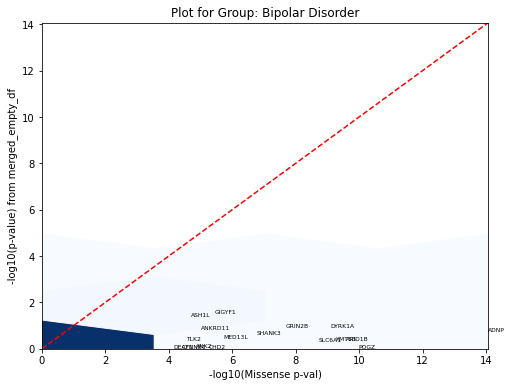

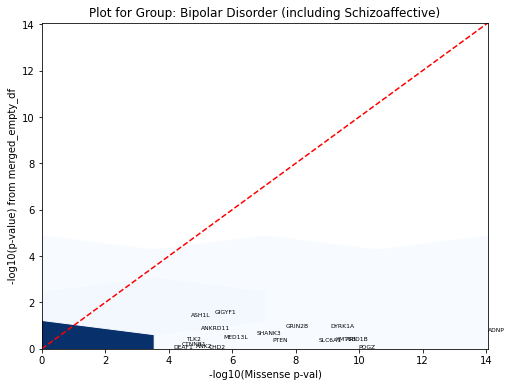

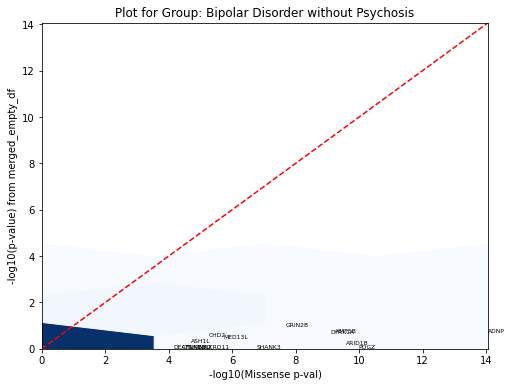

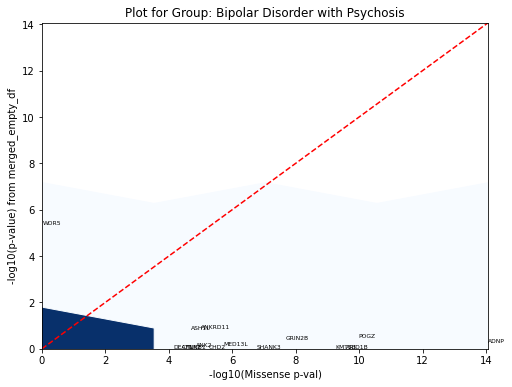

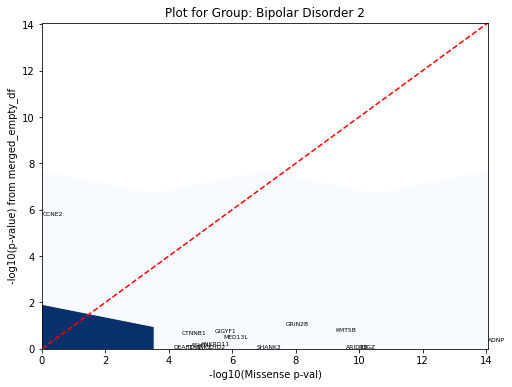

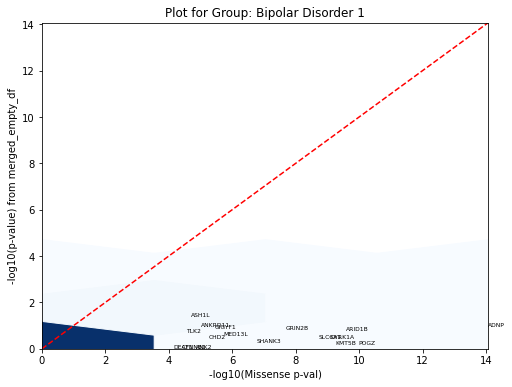

In [44]:
for group in significant_genes_df['group'].unique():
    file_pattern = f"Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(significant_genes_df[significant_genes_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")

### Schizophrenia

#### Have to do liftover from hg19 to hg38 

In [13]:
# !pip uninstall pandas --yes
!pip install pandas
# !pip install pyliftover

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached tzdata-2023.4-py2.py3-none-any.whl (346 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1


In [11]:
# Read the data into a DataFrame
df = pd.read_csv('scz.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df['chr'] = 'chr' + df['chr'].astype(str)
# Ensure that the 'pos' column is converted to integers
df['pos'] = pd.to_numeric(df['pos'], errors='coerce').fillna(0).astype(int)

print("READ SCZ FILE!")
# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], lifted[0][1]
    else:
        # Returns None if liftover fails
        return None, None

# Apply the liftover function to each row in the DataFrame
df[['new_chrom', 'new_pos']] = df.apply(liftover, axis=1, result_type='expand')


READ SCZ FILE!
23087953


In [70]:
print(df['new_pos'].shape)

(23087953,)


In [71]:
df['new_pos'] = df['new_pos'].fillna(0).astype(int)
df[['pos','new_pos']]
df['pos'] = df['new_pos']

In [72]:

df = df[(df['chr'] != "chrX") & (df['chr'] != "chrY") & (df['chr'] != "chrMT")]
# Convert 'chr' and 'pos' columns to integers
# First, convert 'chr' column to string type
df['chr'] = df['chr'].astype(str)
# Now perform the replacement and convert to integer
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)
filter_variant_list = [
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "coding_sequence_variant",
    "downstream_gene_variant",
    "intergenic_variant",
    "intron_variant",
    "mature_miRNA_variant",
     "non_coding_transcript_exon_variant",
    "non_coding_transcript_variant",
    "null",
    "synonymous_variant",
  #  "upstream_gene_variant",
    "splice_region_variant",
    "stop_retained_variant",
    "protein_altering_variant"
]

df = df[~df['consequence'].isin(filter_variant_list)]
df = df[~df['consequence'].isna()]

In [73]:
print(df[df['consequence'].isna()])

Empty DataFrame
Columns: [locus, alleles, gene_id, consequence, hgvsc, hgvsp, cadd, mpc, polyphen, group, ac_case, ac_ctrl, an_case, an_ctrl, n_denovos, p, est, se, qp, i2, in_analysis, source, k, chr, pos, new_chrom, new_pos]
Index: []

[0 rows x 27 columns]


In [74]:
print(df['consequence'].unique())

['frameshift_variant' 'upstream_gene_variant' 'splice_acceptor_variant'
 'start_lost' 'missense_variant_mpc_<2' 'splice_donor_variant'
 'stop_gained' 'inframe_insertion' 'inframe_deletion' 'stop_lost'
 'missense_variant_mpc_2-3' 'missense_variant_mpc_>=3'
 'incomplete_terminal_codon_variant']


In [75]:



columns = ['gene_id', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value']
empty_df = pd.DataFrame(columns=columns)

### Processing outside the for loop 
# Open the GTF file using gzip
with gzip.open(annotation_file_path, 'rt') as annotation_file:
    # Define the columns you want to extract from the GTF file
    columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

    # Read the GTF file into a pandas DataFrame
    gene_df = pd.read_csv(annotation_file, sep='\t', comment='#', header=None, names=columns, dtype={'start': int, 'end': int})

# Extract 'gene_id' using a simplified regular expression
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'transcript_id' using a simplified regular expression
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'gene_type' using a simplified regular expression
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' using a simplified regular expression
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_name' using a simplified regular expression
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

prop_thr = 0.6
cnt_thr = 5
for chromnum in range(1,23):
    # Filter rows for protein-coding regions on chr2
    gene_df_chr = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['seqname'] == 'chr' + str(chromnum)) & (gene_df['feature'] == 'CDS')]

    variants_file_path = "rgc_me_variant_frequencies_chr" + str(chromnum) + "_20231004.vcf.gz"
    # Open the compressed VCF file using gzip
    with gzip.open(variants_file_path, 'rt') as variants_file:
        # Specify column names
        columns = ['chr', 'pos', 'variant', 'ref', 'alt', 'quality', 'filter', 'info']

        # Read the VCF file into a pandas DataFrame
        variants_df = pd.read_csv(variants_file, comment='#', sep='\t', header=None, names=columns, dtype={'pos': int, 'end': int}, usecols=[i for i in range(len(columns)-1)])
    # File path
    coverage_file_path = "chr" + str(chromnum) + ".tsv.gz"

    # Initialize an empty DataFrame to hold the data
    coverage_df = pd.read_csv(coverage_file_path, sep='\t', compression='gzip')
    # Expand locus column
    coverage_df[['chr', 'pos']] = coverage_df['locus'].str.split(':', expand=True)
    coverage_df['pos'] = coverage_df['pos'].astype(int)
    # Filter for >= 80% coverage > 20
    coverage_df_chr = coverage_df[(coverage_df['chr'] == "chr" + str(chromnum))]
    coverage_df_subset = coverage_df_chr[(coverage_df_chr['over_10'] >= 0.8) ]

    # Get the length of the genetic sequence
    sequence_length = max(gene_df_chr['end'].max(), coverage_df_subset['pos'].max())

    # Create a boolean mask for the combined protein-coding regions
    protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
    for start, end in zip(gene_df_chr['start'].to_numpy(), gene_df_chr['end'].to_numpy()):
        protein_coding_mask[start:end+1] = 1

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df_subset['pos'].to_numpy()] = 1

    # Convert the position of the variants to a numpy array
    variant_pos = variants_df['pos'].to_numpy()
    # Filter values less than or equal to sequence_length
    valid_indices = variant_pos <= sequence_length

    # Keep only the valid values
    variant_pos = variant_pos[valid_indices]

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variant_pos] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[protein_coding_mask & coverage_mask])

    print("Size of total sequence:", sequence_length)
    print("Size of regions with >= 80% coverage > 20:", np.sum(coverage_mask))
    print("Size of protein coding-regions:", np.sum(protein_coding_mask))
    print("Size of joint regions:", np.sum(protein_coding_mask & coverage_mask))
    print("Size of joint regions with variants", np.sum(observations))

    # Flatten the higher-order structure
    order = 2  # Set the desired order


    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])


    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    # Display results
    print("Probabilities:", probabilities[:, 0])
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions

    predictions_df = pd.DataFrame({'pos': np.where(protein_coding_mask & coverage_mask)[0][0:len(observations)-2], 'prob_0': probabilities[:, 0], 'prob_1': probabilities[:, 1], 'observations' : observations[0:len(observations)-2]})
 
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observations'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    # Filter for the positions with probability > 0.8 of observing a 0
    pos_over_80 = predictions_df[predictions_df['prob_0'] >= prop_thr]['pos'].to_numpy()

    # Function to calculate the overlap proportion for a single row
    def calculate_overlap(row):
        return np.sum((row['start'] <= pos_over_80) & (pos_over_80 <= row['end'])) / np.sum(row['end'] - row['start']) if row['end'] > row['start'] else 0

    # Apply the function to each row in df1
    gene_df_chr['proportion_over_80'] = gene_df_chr.apply(lambda row: calculate_overlap(row), axis=1)

    # Filter for the positions with probability > 0.8 of observing a 0
    pos_over_80 = predictions_df[predictions_df['prob_0'] >= prop_thr]['pos'].to_numpy()
    filtered_df_2 = df[(df['chr'] == chromnum) & ((df['ac_ctrl'] + df['ac_case']) < cnt_thr)  & (df['an_case'] > 0) & (df['an_ctrl'] > 0)]
    # Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
    filtered_df = filtered_df_2
    filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]
    # Calculate total counts for cases and controls
    filtered_df['total_ac_case'] = filtered_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    filtered_df['total_an_case'] = filtered_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    filtered_df['total_ac_ctrl'] = filtered_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    filtered_df['total_an_ctrl'] = filtered_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_combinations = filtered_df[['gene_id', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Apply Fisher's exact test for each unique combination
    results = unique_combinations.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1)

    # Add the results to the DataFrame
    unique_combinations[['odds_ratio', 'p_value']] = pd.DataFrame(results.tolist(), index=unique_combinations.index)

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_combinations.sort_values(by='p_value')

    # Filter rows where p_value < 0.0001
    filtered_rows = sorted_df[sorted_df['p_value'] <= 1]

    # Append these rows to the empty DataFrame
    empty_df = empty_df.append(filtered_rows, ignore_index=True)
    print("CHROMOSOME FINISHED: " + str(chromnum))
    # Display the sorted DataFrame
    print(sorted_df[sorted_df['p_value'] < .0001])
    

# Create a new column for standardized gene_id
gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]
empty_df['std_gene_id'] = empty_df['gene_id'].str.split('.').str[0]

# Optional: Drop duplicates in gene_df based on std_gene_id if necessary
gene_df_unique = gene_df.drop_duplicates(subset='std_gene_id')

# Merge the dataframes on the new standardized gene_id column
merged_empty_df = pd.merge(empty_df, gene_df_unique[["std_gene_id","gene_name"]], on='std_gene_id', how='left')

# Drop the std_gene_id column if not needed
merged_empty_df = merged_empty_df.drop('std_gene_id', axis=1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Sample DataFrame (replace with your actual DataFrame)
# merged_empty_df = ...

# Get unique groups


Size of total sequence: 248918453
Size of regions with >= 80% coverage > 20: 6024675
Size of protein coding-regions: 3547150
Size of joint regions: 3321469
Size of joint regions with variants 1498639.0
Probabilities: [9.66674184e-34 2.53299804e-03 2.53554095e-03 ... 4.09313693e-05
 4.10091563e-05 1.18711234e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                 1.373e+06
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:22:01   Log-Likelihood:            -1.8202e+06
No. Observations:             3321467   AIC:                         3.640e+06
Df Residuals:                 3321465   BIC:                         3.640e+06
Df Model:                           1                 

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 1
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 242119107
Size of regions with >= 80% coverage > 20: 4354636
Size of protein coding-regions: 2554055
Size of joint regions: 2425391
Size of joint regions with variants 1092106.0
Probabilities: [1.55167437e-35 4.08903237e-05 4.09548949e-05 ... 4.09313593e-05
 4.10091563e-05 1.18711234e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 9.894e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:25:08   Log-Likelihood:            -1.3334e+06
No. Observations:             2425389   AIC:            

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 2
                 gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
2399034  ENSG00000143797  meta             15          48496              9   

         total_an_ctrl  odds_ratio   p_value  
2399034         194644    6.691109  0.000006  
Size of total sequence: 198167921
Size of regions with >= 80% coverage > 20: 3464792
Size of protein coding-regions: 1986252
Size of joint regions: 1929980
Size of joint regions with variants 869319.0
Probabilities: [9.66673987e-34 2.53298922e-03 2.53538142e-03 ... 2.53552633e-03
 4.35115444e-05 1.18718486e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 7.866e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:           

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 3
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 190175195
Size of regions with >= 80% coverage > 20: 2266543
Size of protein coding-regions: 1392596
Size of joint regions: 1309148
Size of joint regions with variants 592477.0
Probabilities: [1.00407813e-30 7.25733762e-01 9.14184101e-01 ... 1.37830962e-01
 1.16167470e-02 8.58805755e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 5.330e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:28:59   Log-Likelihood:            -7.2069e+05
No. Observations:             1309146   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 4
                 gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
5592227  ENSG00000053900  meta             16          48496             14   

         total_an_ctrl  odds_ratio   p_value  
5592227         194644    4.588166  0.000051  
Size of total sequence: 181368222
Size of regions with >= 80% coverage > 20: 2638786
Size of protein coding-regions: 1594789
Size of joint regions: 1532488
Size of joint regions with variants 691912.0
Probabilities: [1.55177224e-35 4.34661987e-05 2.61626409e-03 ... 1.02516119e-02
 5.97635253e-05 6.92450787e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 6.260e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:           

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 5
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 170640291
Size of regions with >= 80% coverage > 20: 2962162
Size of protein coding-regions: 1760101
Size of joint regions: 1691173
Size of joint regions with variants 761729.0
Probabilities: [1.55257114e-35 6.44927264e-05 2.36381736e-02 ... 4.09412802e-05
 4.10091663e-05 1.18711234e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 6.919e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:31:53   Log-Likelihood:            -9.2908e+05
No. Observations:             1691171   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 6
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 159233413
Size of regions with >= 80% coverage > 20: 2744340
Size of protein coding-regions: 1622853
Size of joint regions: 1496489
Size of joint regions with variants 691516.0
Probabilities: [1.92732687e-35 9.92774725e-03 1.36329715e-01 ... 2.71530627e-03
 2.97109822e-03 7.34357482e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 6.071e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:33:24   Log-Likelihood:            -8.2704e+05
No. Observations:             1496487   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 7
                 gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
9186215  ENSG00000087085  meta              8          48496              2   

         total_an_ctrl  odds_ratio   p_value  
9186215         194644   16.056921  0.000076  


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Size of total sequence: 145065777
Size of regions with >= 80% coverage > 20: 1942099
Size of protein coding-regions: 1193748
Size of joint regions: 1104268
Size of joint regions with variants 527670.0
Probabilities: [1.55177223e-35 4.34660990e-05 2.61616442e-03 ... 3.43275621e-02
 2.98236632e-02 3.08785838e-01]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 4.382e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:34:34   Log-Likelihood:            -6.1585e+05
No. Observations:             1104266   AIC:                         1.232e+06
Df Residuals:                 1104264   BIC:                         1.232e+06
Df Model:                           1                  

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 8
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Size of total sequence: 138217172
Size of regions with >= 80% coverage > 20: 2389101
Size of protein coding-regions: 1411072
Size of joint regions: 1308174
Size of joint regions with variants 611496.0
Probabilities: [1.92816394e-35 9.94977814e-03 1.36728323e-01 ... 4.00558572e-01
 4.08327579e-01 6.56919013e-02]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                 5.230e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:35:41   Log-Likelihood:            -7.2669e+05
No. Observations:             1308172   AIC:                         1.453e+06
Df Residuals:                 1308170   BIC:                         1.453e+06
Df Model:                           1                  

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 9
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 133626845
Size of regions with >= 80% coverage > 20: 2334129
Size of protein coding-regions: 1358880
Size of joint regions: 1284789
Size of joint regions with variants 580113.0
Probabilities: [9.63601194e-34 2.39525227e-03 4.32884772e-05 ... 9.72424995e-01
 9.54879693e-01 8.84444216e-01]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 5.259e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:36:53   Log-Likelihood:            -7.0600e+05
No. Observations:             1284787   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 10
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 134387940
Size of regions with >= 80% coverage > 20: 3490127
Size of protein coding-regions: 2065437
Size of joint regions: 1960368
Size of joint regions with variants 919444.0
Probabilities: [9.66853728e-34 2.54104605e-03 2.68115473e-03 ... 3.27150964e-02
 5.47483865e-01 6.30923549e-01]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 7.768e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:38:30   Log-Likelihood:            -1.0919e+06
No. Observations:             1960366   AIC:            

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 11
                  gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
13359496  ENSG00000168876  meta             11          48496              2   

          total_an_ctrl  odds_ratio   p_value  
13359496         194644   22.079633  0.000001  
Size of total sequence: 133234483
Size of regions with >= 80% coverage > 20: 3236394
Size of protein coding-regions: 1826401
Size of joint regions: 1747171
Size of joint regions with variants 774427.0
Probabilities: [5.38867405e-31 3.70583375e-01 3.75114999e-01 ... 6.77963890e-01
 8.27220907e-01 8.05002704e-01]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 7.273e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:      

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 12
                  gene_id         group  total_ac_case  total_an_case  \
14860577  ENSG00000197653  FIN (exomes)              5           1888   

          total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
14860577              1          15968    42.39777  0.000072  


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Size of total sequence: 114326382
Size of regions with >= 80% coverage > 20: 1063289
Size of protein coding-regions: 635093
Size of joint regions: 610169
Size of joint regions with variants 271599.0
Probabilities: [2.23409197e-31 1.29756802e-01 9.57361337e-03 ... 8.93143693e-01
 9.20508584e-01 8.63055223e-01]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                 2.516e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:41:11   Log-Likelihood:            -3.3381e+05
No. Observations:              610167   AIC:                         6.676e+05
Df Residuals:                  610165   BIC:                         6.677e+05
Df Model:                           1                    

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 13
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 106873086
Size of regions with >= 80% coverage > 20: 1858340
Size of protein coding-regions: 1090118
Size of joint regions: 1044611
Size of joint regions with variants 473293.0
Probabilities: [1.40009710e-32 5.86791276e-01 7.03288650e-01 ... 9.96123824e-03
 5.94239162e-05 6.92445898e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 4.254e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:42:03   Log-Likelihood:            -5.7513e+05
No. Observations:             1044609   AIC:            

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 14
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 101975197
Size of regions with >= 80% coverage > 20: 2078610
Size of protein coding-regions: 1204731
Size of joint regions: 1118065
Size of joint regions with variants 511308.0
Probabilities: [3.83866394e-33 1.31269041e-01 1.18689825e-02 ... 2.70632670e-03
 2.97052364e-03 7.34349212e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 4.523e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:43:08   Log-Likelihood:            -6.1748e+05
No. Observations:             1118063   AIC:            

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 15
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 90102492
Size of regions with >= 80% coverage > 20: 2505795
Size of protein coding-regions: 1460302
Size of joint regions: 1341973
Size of joint regions with variants 678949.0
Probabilities: [2.23409697e-31 1.29757184e-01 9.57419269e-03 ... 2.69064057e-03
 2.54891552e-03 1.25979294e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 5.081e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:44:23   Log-Likelihood:            -7.5846e+05
No. Observations:             1341971   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 16
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 83094646
Size of regions with >= 80% coverage > 20: 3538861
Size of protein coding-regions: 1991750
Size of joint regions: 1868529
Size of joint regions with variants 854679.0
Probabilities: [1.00407813e-30 7.25733762e-01 9.14184101e-01 ... 7.65527674e-05
 4.10448890e-05 1.18711337e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.653e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:45:51   Log-Likelihood:            -1.0286e+06
No. Observations:             1868527   AIC:             

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 17
                  gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
18191796  ENSG00000132510  meta             12          48496              7   

          total_an_ctrl  odds_ratio   p_value  
18191796         194644    6.881929  0.000048  
Size of total sequence: 80247419
Size of regions with >= 80% coverage > 20: 908148
Size of protein coding-regions: 540237
Size of joint regions: 523779
Size of joint regions with variants 237221.0
Probabilities: [1.00407813e-30 7.25733762e-01 9.14184101e-01 ... 2.53579026e-03
 2.54033362e-03 1.25954423e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 2.138e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:          

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 18
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 58571508
Size of regions with >= 80% coverage > 20: 3781091
Size of protein coding-regions: 2296390
Size of joint regions: 2178998
Size of joint regions with variants 1062339.0
Probabilities: [1.00407813e-30 7.25733762e-01 9.14184101e-01 ... 1.12499325e-02
 1.48913169e-01 2.83509497e-02]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 8.446e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:48:16   Log-Likelihood:            -1.2239e+06
No. Observations:             2178996   AIC:            

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 19
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 64327998
Size of regions with >= 80% coverage > 20: 1415556
Size of protein coding-regions: 828894
Size of joint regions: 794036
Size of joint regions with variants 368920.0
Probabilities: [9.11077471e-34 4.08927984e-05 4.34289962e-05 ... 4.77568044e-03
 3.10293543e-03 7.36255190e-03]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 3.225e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:49:18   Log-Likelihood:            -4.3897e+05
No. Observations:              794034   AIC:               

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 20
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 46664441
Size of regions with >= 80% coverage > 20: 565065
Size of protein coding-regions: 334987
Size of joint regions: 311195
Size of joint regions with variants 146820.0
Probabilities: [1.00381760e-30 7.25534871e-01 9.13882212e-01 ... 3.56356582e-02
 7.67150811e-05 1.18814712e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 1.233e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:49:42   Log-Likelihood:            -1.7344e+05
No. Observations:              311193   AIC:                

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 21
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
Size of total sequence: 50782401
Size of regions with >= 80% coverage > 20: 1265995
Size of protein coding-regions: 717578
Size of joint regions: 667439
Size of joint regions with variants 319574.0
Probabilities: [5.92971074e-32 4.47062766e-03 3.75933294e-02 ... 2.61627653e-03
 4.35925468e-05 1.18718721e-04]
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 2.637e+05
Date:                Wed, 03 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:50:17   Log-Likelihood:            -3.7271e+05
No. Observations:              667437   AIC:               

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

CHROMOSOME FINISHED: 22
Empty DataFrame
Columns: [gene_id, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []


In [76]:
print(merged_empty_df[merged_empty_df['gene_name'] == "SETD1A"])

               gene_id           group total_ac_case total_an_case  \
59838  ENSG00000099381            meta            15         48496   
60081  ENSG00000099381  EUR-N (exomes)             6         14554   
60213  ENSG00000099381    ASJ (exomes)             1          1738   
60233  ENSG00000099381    EUR (exomes)             4         17748   
60581  ENSG00000099381   FIN (genomes)             1           846   
60877  ENSG00000099381    AMR (exomes)             1          2776   
62020  ENSG00000099381   EST (genomes)             0           522   
62021  ENSG00000099381   AFR (genomes)             1          4490   
62023  ENSG00000099381    EAS (exomes)             1          3460   

      total_ac_ctrl total_an_ctrl  odds_ratio   p_value gene_name  
59838            23        194644    2.618072  0.006658    SETD1A  
60081             3         22374    3.075474  0.168304    SETD1A  
60213             0          4830         inf  0.264616    SETD1A  
60233             4        

In [77]:
merged_empty_df[(merged_empty_df['p_value'] < .001) & (merged_empty_df['group'] == "meta")].sort_values(by='p_value')

gene_id group total_ac_case total_an_case total_ac_ctrl  \
43427  ENSG00000168876  meta            11         48496             2   
8691   ENSG00000143797  meta            15         48496             9   
62825  ENSG00000132510  meta            12         48496             7   
19225  ENSG00000053900  meta            16         48496            14   
30724  ENSG00000087085  meta             8         48496             2   
43428  ENSG00000254986  meta            10         48496             5   
30725  ENSG00000004948  meta            10         48496             5   
62826  ENSG00000161509  meta             9         48496             4   
26414  ENSG00000081087  meta             7         48496             2   
54574  ENSG00000100485  meta            15         48496            16   
14224  ENSG00000164082  meta            14         48496            14   
59832  ENSG00000169957  meta            14         48496            14   
40179  ENSG00000122378  meta             6         48496             1   
40180  ENSG00000048740  meta             9         48496             5   
26415  ENSG00000112365  meta            12         48496            11   
1      ENSG00000116128  meta            20         48496            28   
26416  ENSG00000146192  meta             7         48496             3   
53098  ENSG00000133106  meta             7         48496             3   
19226  ENSG00000183423  meta             7         48496             3   
54575  ENSG00000100614  meta            10         48496             8   
2      ENSG00000125703  meta            10         48496             8   
26417  ENSG00000112337  meta            10         48496             8   
77222  ENSG00000161180  meta            10         48496             8   
19227  ENSG00000184985  meta            11         48496            10   

      total_an_ctrl  odds_ratio   p_value gene_name  
43427        194644   22.079633  0.000001   ANKRD49  
8691         194644    6.691109  0.000006    MBOAT2  
62825        194644    6.881929  0.000048     KDM6B  
19225        194644    4.588166  0.000051    ANAPC4  
30724        194644   16.056921  0.000076      ACHE  
43428        194644    8.028668  0.000110      DPP3  
30725        194644    8.028668  0.000110     CALCR  
62826        194644    9.032112  0.000162    GRIN2C  
26414        194644   14.049516  0.000308     OSTM1  
54574        194644    3.763614  0.000354      SOS2  
14224        194644    4.014480  0.000362      GRM2  
59832        194644    4.014480  0.000362    ZNF768  
40179        194644   24.084512  0.000365    PRXL2A  
40180        194644    7.225652  0.000374     CELF2  
26415        194644    4.379319  0.000582    ZBTB24  
1            194644    2.867634  0.000780      BCL9  
26416        194644    9.366296  0.000849      FGD2  
53098        194644    9.366296  0.000849    EPSTI1  
19226        194644    9.366296  0.000849     LRIT3  
54575        194644    5.017840  0.000890     PPM1A  
2            194644    5.017840  0.000890     ATG4C  
26417        194644    5.017840  0.000890   SLC17A2  
77222        194644    5.017840  0.000890   CCDC116  
19227        194644    4.415745  0.000946    SORCS2

In [78]:
for item in merged_empty_df[(merged_empty_df['p_value'] < .001) & (merged_empty_df['group'] == "meta")]['gene_name']:
    print(item)

BCL9
ATG4C
MBOAT2
GRM2
ANAPC4
LRIT3
SORCS2
OSTM1
ZBTB24
FGD2
SLC17A2
ACHE
CALCR
PRXL2A
CELF2
ANKRD49
DPP3
EPSTI1
SOS2
PPM1A
ZNF768
KDM6B
GRIN2C
CCDC116


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


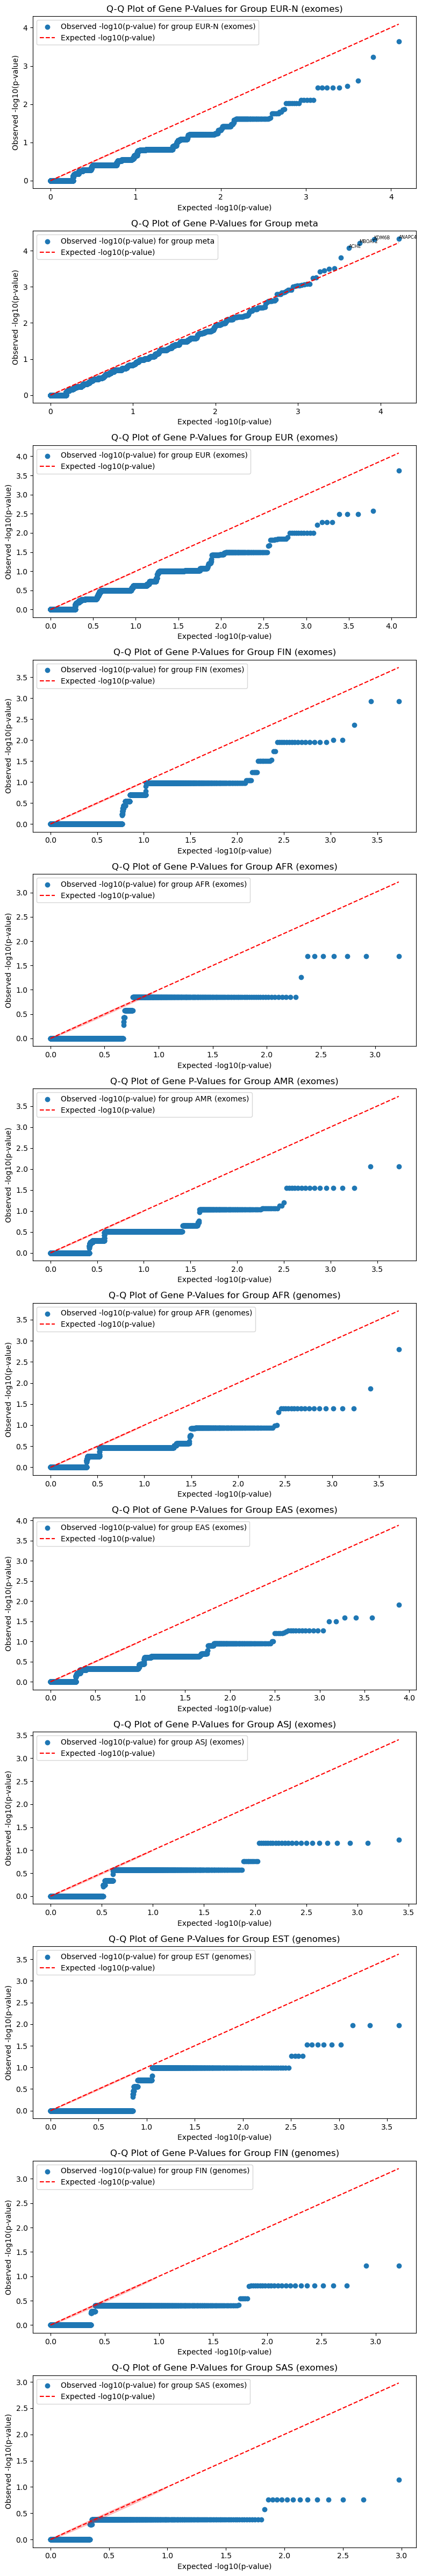

In [39]:
unique_groups = merged_empty_df['group'].unique()

# Number of unique groups
num_groups = len(unique_groups)

# Create a figure with subplots
fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

# Loop over each group and create a Q-Q plot
for i, group in enumerate(unique_groups):
    # Filter the DataFrame for the current group
    group_df = merged_empty_df[merged_empty_df['group'] == group]

    # Calculate -log10(p-values)
    group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

    # Sort by p-value in ascending order
    group_df = group_df.sort_values('p_value', ascending=True)

    # Calculate theoretical quantiles
    theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

    # Transform theoretical quantiles into -log10(p-values)
    group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

    # Plotting the Q-Q plot for the group
    ax = axs[i] if num_groups > 1 else axs
    ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

    # Define x for the expected line and confidence intervals
    x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
    y = x
    ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
    ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

    # Labeling significant genes
    significant_genes = group_df[group_df['p_value'] < .0001]
    for idx, row in significant_genes.iterrows():
        ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

    # Labeling the plot
    ax.set_xlabel('Expected -log10(p-value)')
    ax.set_ylabel('Observed -log10(p-value)')
    ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob



In [79]:
print(merged_empty_df[merged_empty_df['group'] == "meta"].shape)

(16716, 9)


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


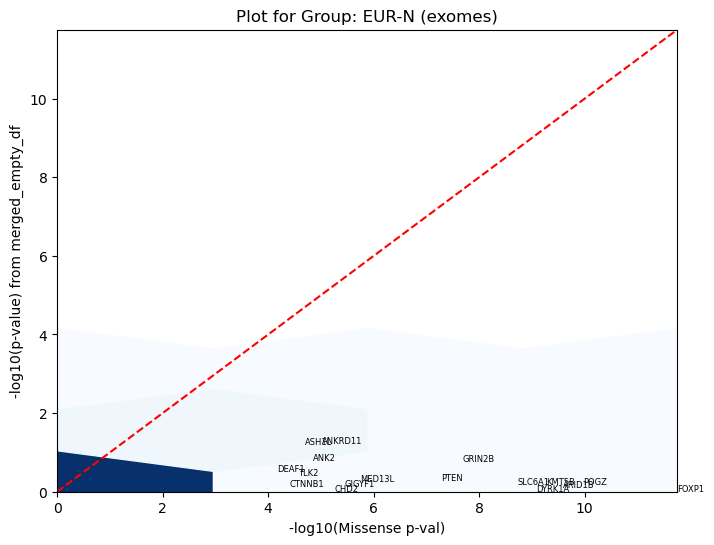

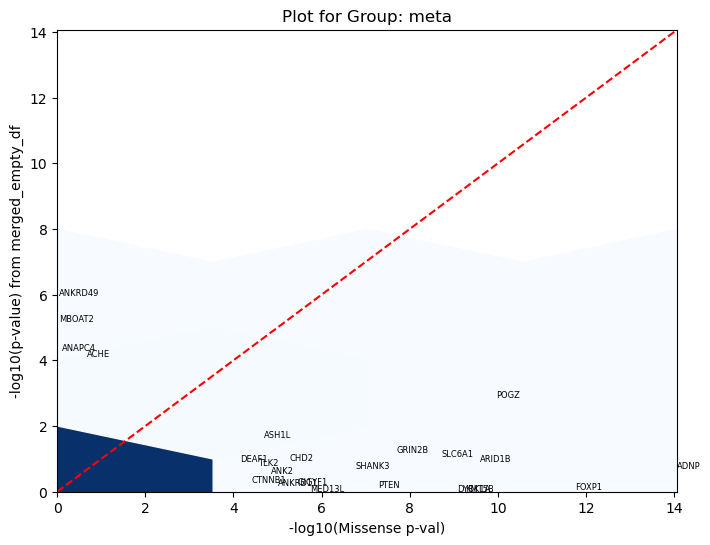

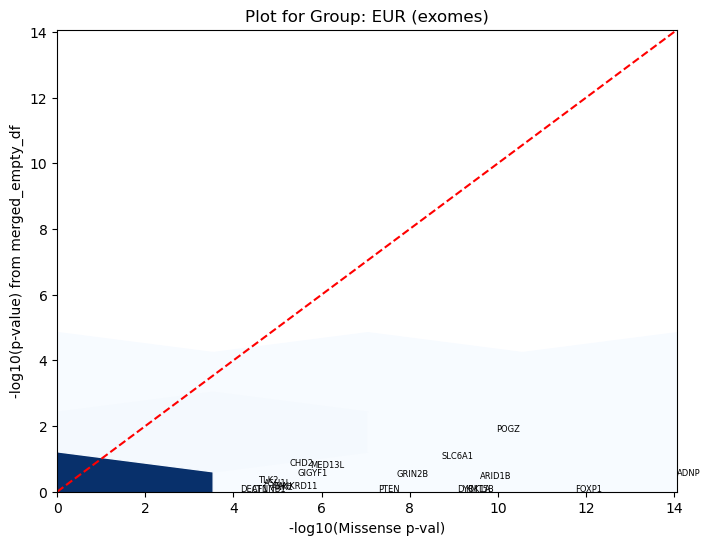

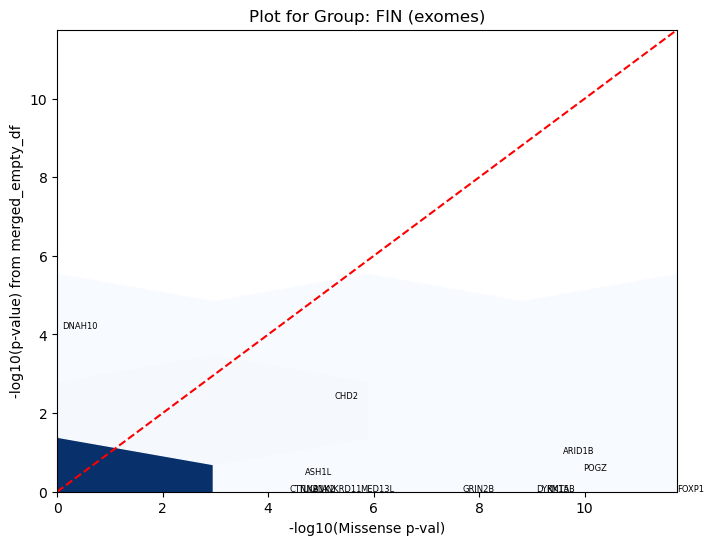

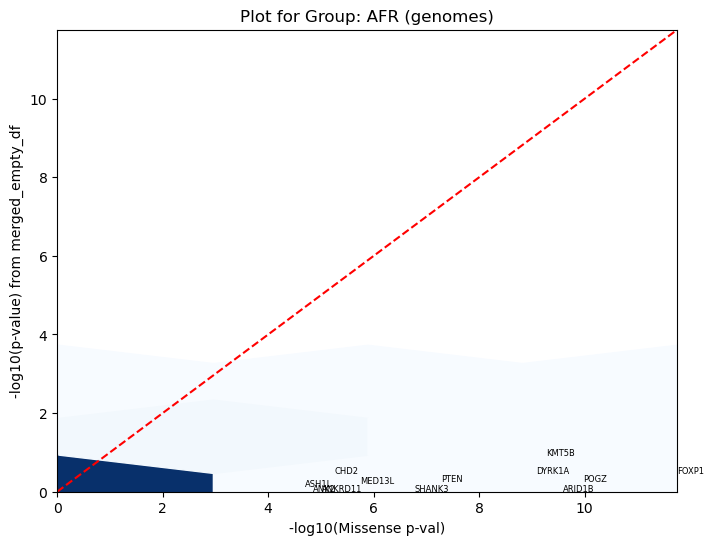

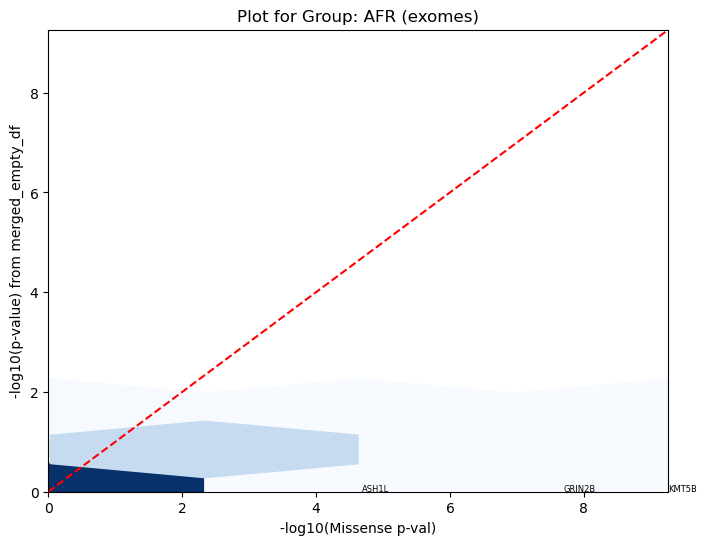

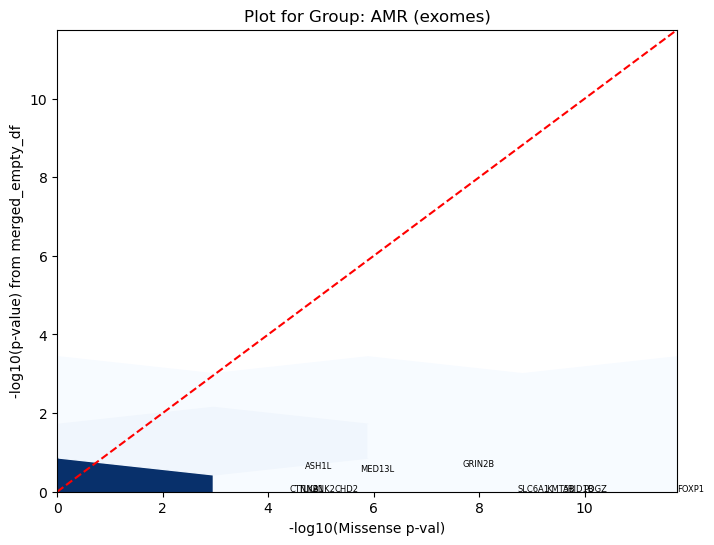

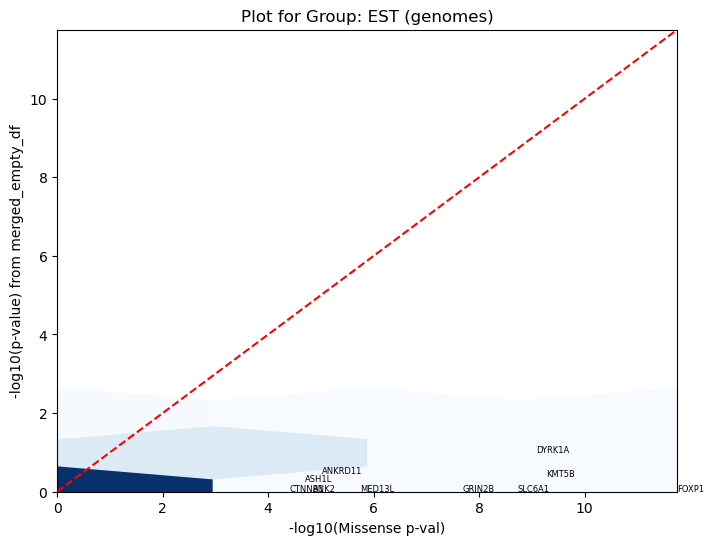

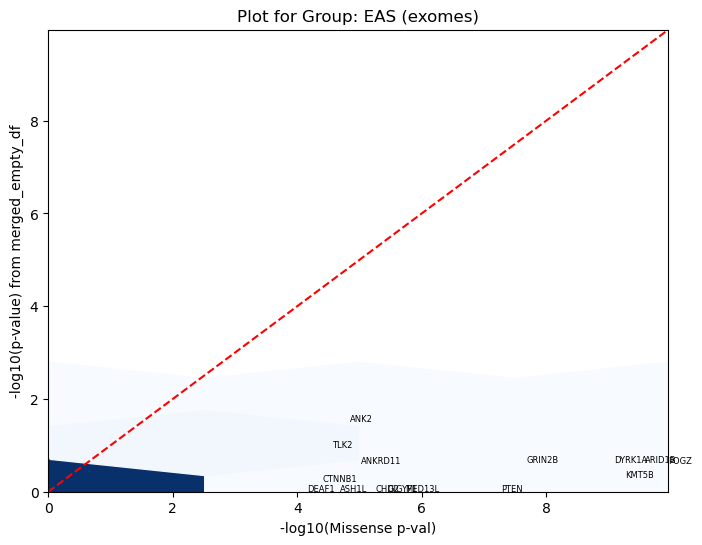

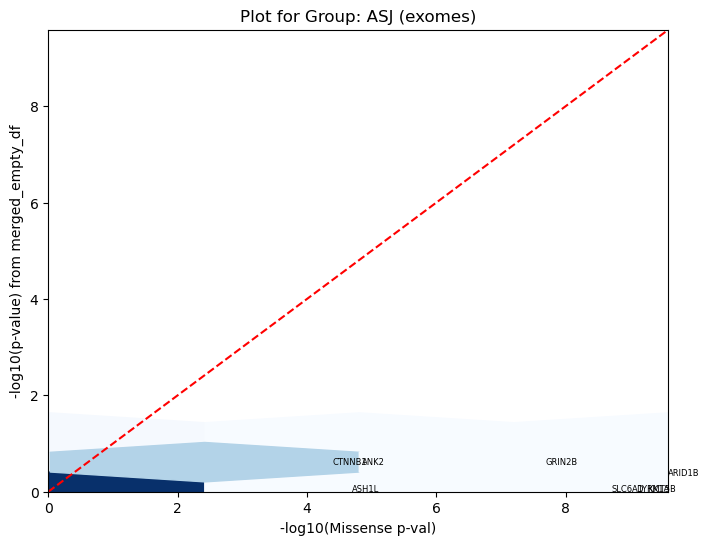

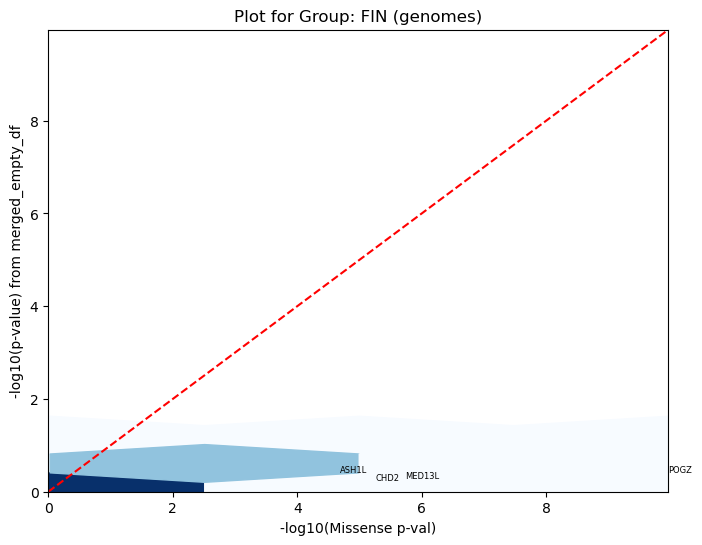

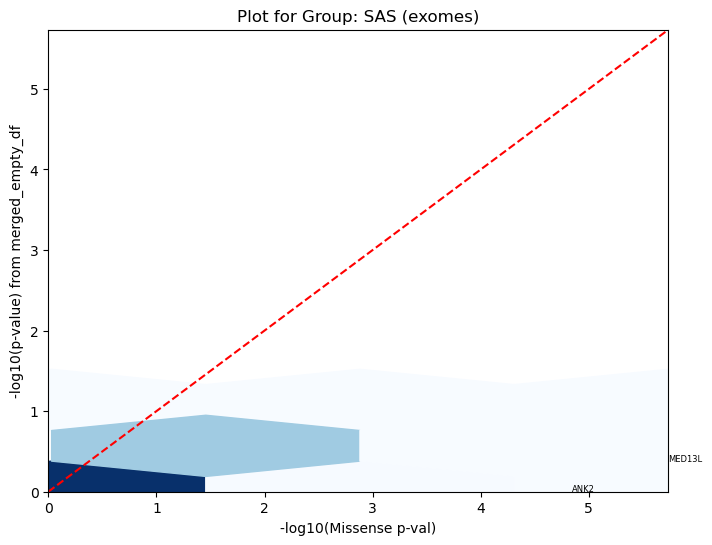

In [80]:
# Assuming merged_empty_df is your DataFrame
for group in merged_empty_df['group'].unique():
    file_pattern = f"Autism_results_2023_12_30_14_36_32.csv"
    files = glob.glob(file_pattern)

    if files:
        results_pub_df = pd.read_csv(files[0], sep=",")
        merged_pub_df = pd.merge(merged_empty_df[merged_empty_df['group'] == group], results_pub_df, left_on='gene_id', right_on='Gene')

        merged_pub_df['minus_log_pval'] = -np.log10(merged_pub_df['p_value'])
        merged_pub_df['minus_log_missense_pval'] = -np.log10(merged_pub_df['Q‑Val'])

        # Set up the plot
        plt.figure(figsize=(8, 6))

        # Replace Inf values with NaN
        merged_pub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Calculate the minimum p-value, ignoring NaN values
        min_pval = np.nanmin([merged_pub_df['minus_log_missense_pval'].min(), merged_pub_df['minus_log_pval'].min()])

        # Calculate the maximum p-value, ignoring NaN values
        max_pval = np.nanmax([merged_pub_df['minus_log_missense_pval'].max(), merged_pub_df['minus_log_pval'].max()])

        # Ensure min_pval and max_pval are not NaN (in case all values are NaN or Inf)
        if np.isnan(min_pval):
            min_pval = 0  # or some other default value
        if np.isnan(max_pval):
            max_pval = 1  # or some other default value
        # Create a hexbin (smoothscatter) plot
        plt.hexbin(merged_pub_df['minus_log_missense_pval'], merged_pub_df['minus_log_pval'], gridsize=2, cmap='Blues')

        # Add a diagonal line
        plt.plot([min_pval, max_pval], [min_pval, max_pval], color='red', linestyle='--')

        # Annotate points
        for _, row in merged_pub_df.iterrows():
            if (abs((row['minus_log_missense_pval'] - row['minus_log_pval'])) > 2) & (max(row['minus_log_missense_pval'], row['minus_log_pval']) > 4):
                plt.text(row['minus_log_missense_pval'], row['minus_log_pval'], row['gene_name'], fontsize=6)

        # Set axis limits
        plt.xlim(min_pval, max_pval)
        plt.ylim(min_pval, max_pval)

        # Axis labels and title
        plt.xlabel('-log10(Missense p-val)')
        plt.ylabel('-log10(p-value) from merged_empty_df')
        plt.title(f'Plot for Group: {group}')
      #  plt.colorbar()  # Add a color bar to the hexbin plot

        plt.show()

    else:
        print(f"No files found for group {group}")

### Bipolar 

In [ ]:
# Create a DataFrame from the collected rowsfile_path = coverage_file_path
import gzip


# Read the data into a DataFrame
df = pd.read_csv('epi25_variant_results.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df = df[(df['chr'] != "chrX") & (df['chr'] != "chrY") & (df['chr'] != "chrMT")]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)
df = df[(df['consequence'] != "synonymous") & (df['consequence'] != "non_coding") & (df['consequence'] != "NA")  ]

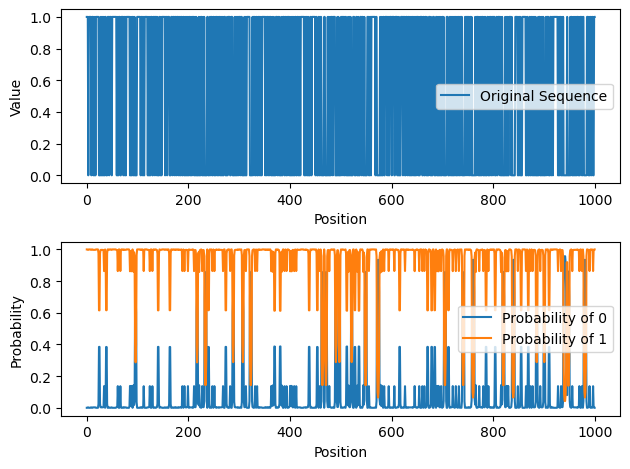

In [539]:
import matplotlib.pyplot as plt

start_idx = 0
end_idx = 1000

# Plot the original sequence
plt.subplot(2, 1, 1)
plt.plot(observations[start_idx:end_idx], label='Original Sequence')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()

# Plot the predicted probabilities
plt.subplot(2, 1, 2)
plt.plot(probabilities[start_idx:end_idx, 0], label='Probability of 0')
plt.plot(probabilities[start_idx:end_idx, 1], label='Probability of 1')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [541]:
import statsmodels.api as sm

print(predictions_df.shape)
# Add a constant term to the independent variable for the intercept
X = sm.add_constant(predictions_df['prob_0'])

# Fit the linear regression model
model4 = sm.OLS(predictions_df['observations'],X).fit()

model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

# Get the summary of the regression
print(model4.summary())

# Extract the F-statistic and its associated p-value
f_statistic = model4.fvalue
p_value_f_statistic = model4.f_pvalue

(1480859, 4)
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 6.036e+05
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:43:05   Log-Likelihood:            -8.1470e+05
No. Observations:             1480859   AIC:                         1.629e+06
Df Residuals:                 1480857   BIC:                         1.629e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6178      0.000   1523

In [543]:
# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()

# Function to calculate the overlap proportion for a single row
def calculate_overlap(row):
    return np.sum((row['start'] <= pos_over_80) & (pos_over_80 <= row['end'])) / np.sum(row['end'] - row['start']) if row['end'] > row['start'] else 0

# Apply the function to each row in df1
gene_df['proportion_over_80'] = gene_df.apply(lambda row: calculate_overlap(row), axis=1)

# Display the result
gene_df

seqname  source feature      start        end score strand frame  \
555724    chr5  HAVANA     CDS      92232      92276     .      +     0   
555727    chr5  HAVANA     CDS     113251     113448     .      +     0   
555729    chr5  HAVANA     CDS     139483     140716     .      +     0   
555731    chr5  HAVANA     CDS     143047     143256     .      +     2   
555733    chr5  HAVANA     CDS     143380     143503     .      +     2   
...        ...     ...     ...        ...        ...   ...    ...   ...   
644578    chr5  HAVANA     CDS  181260001  181260813     .      -     0   
644581    chr5  HAVANA     CDS  181256474  181256515     .      -     0   
644587    chr5  HAVANA     CDS  181260001  181260813     .      -     0   
644590    chr5  HAVANA     CDS  181257052  181257054     .      -     0   
644657    chr5  HAVANA     CDS  181367287  181368222     .      +     0   

                   gene_id      transcript_id       gene_type gene_name  \
555724  ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
555727  ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
555729  ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
555731  ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
555733  ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
...                    ...                ...             ...       ...   
644578   ENSG00000183718.6  ENST00000685507.1  protein_coding    TRIM52   
644581   ENSG00000183718.6  ENST00000685507.1  protein_coding    TRIM52   
644587   ENSG00000183718.6  ENST00000510796.2  protein_coding    TRIM52   
644590   ENSG00000183718.6  ENST00000510796.2  protein_coding    TRIM52   
644657   ENSG00000230178.1  ENST00000456475.1  protein_coding     OR4F3   

       transcript_name  proportion_over_80  
555724    PLEKHG4B-204            0.000000  
555727    PLEKHG4B-204            0.000000  
555729    PLEKHG4B-204            0.019465  
555731    PLEKHG4B-204            0.105263  
555733    PLEKHG4B-204            0.105691  
...                ...                 ...  
644578      TRIM52-207            0.160099  
644581      TRIM52-207            0.000000  
644587      TRIM52-202            0.160099  
644590      TRIM52-202            0.000000  
644657       OR4F3-201            0.000000  

[28470 rows x 14 columns]

In [544]:
#gene_df[gene_df['proportion_over_80'] > .5]['gene_name'].unique()
sorted_df2 = gene_df[gene_df['proportion_over_80'] > 0.5].sort_values(by='proportion_over_80', ascending=False)
sorted_df2

seqname   source feature      start        end score strand frame  \
568867    chr5   HAVANA     CDS   40835183   40835185     .      -     0   
568843    chr5   HAVANA     CDS   40835183   40835185     .      -     0   
568856    chr5   HAVANA     CDS   40835183   40835185     .      -     0   
594306    chr5   HAVANA     CDS   95656046   95656050     .      +     2   
625061    chr5   HAVANA     CDS  150699256  150699271     .      -     0   
...        ...      ...     ...        ...        ...   ...    ...   ...   
598076    chr5  ENSEMBL     CDS  103158452  103158573     .      +     2   
598139    chr5   HAVANA     CDS  103158452  103158573     .      +     2   
566711    chr5   HAVANA     CDS   37017019   37017162     .      +     0   
566614    chr5   HAVANA     CDS   37017019   37017162     .      +     0   
566515    chr5   HAVANA     CDS   37017019   37017162     .      +     0   

                   gene_id       transcript_id       gene_type gene_name  \
568867  ENSG00000145592.14   ENST00000508493.1  protein_coding     RPL37   
568843  ENSG00000145592.14  ENST00000274242.10  protein_coding     RPL37   
568856  ENSG00000145592.14   ENST00000509877.5  protein_coding     RPL37   
594306  ENSG00000175449.15   ENST00000513950.2  protein_coding     RFESD   
625061  ENSG00000086589.12   ENST00000447771.6  protein_coding     RBM22   
...                    ...                 ...             ...       ...   
598076  ENSG00000145725.21   ENST00000414217.5  protein_coding   PPIP5K2   
598139  ENSG00000145725.21   ENST00000627916.2  protein_coding   PPIP5K2   
566711  ENSG00000164190.19   ENST00000652901.1  protein_coding     NIPBL   
566614  ENSG00000164190.19   ENST00000448238.2  protein_coding     NIPBL   
566515  ENSG00000164190.19  ENST00000282516.13  protein_coding     NIPBL   

       transcript_name  proportion_over_80  
568867       RPL37-204            1.500000  
568843       RPL37-201            1.500000  
568856       RPL37-205            1.500000  
594306       RFESD-208            1.250000  
625061       RBM22-202            1.066667  
...                ...                 ...  
598076     PPIP5K2-203            0.504132  
598139     PPIP5K2-217            0.504132  
566711       NIPBL-209            0.503497  
566614       NIPBL-202            0.503497  
566515       NIPBL-201            0.503497  

[808 rows x 14 columns]

In [545]:
# Read the file into a pandas DataFrame
constraint_df = pd.read_csv(constraint_file_path, sep='\t', usecols=['gene', 'transcript', 'mane_select', 'mis.z_score'])

# Compute the MTR
#constraint_df['MTR'] = (constraint_df['mis.obs'] / (constraint_df['mis.obs'] + constraint_df['syn.obs'])) / (constraint_df['mis.exp'] / (constraint_df['mis.exp'] + constraint_df['syn.exp']))

constraint_df

gene       transcript  mane_select  mis.z_score
0       A1BG  ENST00000263100         True     -0.86948
1       A1BG  ENST00000600966        False      0.11131
2       A1BG      NM_130786.4         True     -0.86948
3       A1CF  ENST00000282641        False      1.22810
4       A1CF  ENST00000373993        False      1.24550
...      ...              ...          ...          ...
211267   NaN  ENST00000691540        False      1.42620
211268   NaN  ENST00000691972        False      1.02480
211269   NaN  ENST00000692281        False      2.21410
211270   NaN  ENST00000692585        False     -0.26486
211271   NaN  ENST00000693342        False      0.13518

[211272 rows x 4 columns]

In [546]:
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)
merged_df = pd.merge(gene_df, constraint_df, left_on=['gene_name', 'transcript'], right_on=['gene', 'transcript'], how='inner')
merged_df['length'] = abs(merged_df['end'] - merged_df['start']) + 1
merged_df

seqname  source feature      start        end score strand frame  \
0        chr5  HAVANA     CDS      92232      92276     .      +     0   
1        chr5  HAVANA     CDS     113251     113448     .      +     0   
2        chr5  HAVANA     CDS     139483     140716     .      +     0   
3        chr5  HAVANA     CDS     143047     143256     .      +     2   
4        chr5  HAVANA     CDS     143380     143503     .      +     2   
...       ...     ...     ...        ...        ...   ...    ...   ...   
26305    chr5  HAVANA     CDS  181257211  181257228     .      -     0   
26306    chr5  HAVANA     CDS  181260001  181260813     .      -     0   
26307    chr5  HAVANA     CDS  181256474  181256515     .      -     0   
26308    chr5  HAVANA     CDS  181260001  181260813     .      -     0   
26309    chr5  HAVANA     CDS  181257052  181257054     .      -     0   

                  gene_id      transcript_id       gene_type gene_name  \
0      ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
1      ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
2      ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
3      ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
4      ENSG00000153404.15  ENST00000637938.2  protein_coding  PLEKHG4B   
...                   ...                ...             ...       ...   
26305   ENSG00000183718.6  ENST00000686030.1  protein_coding    TRIM52   
26306   ENSG00000183718.6  ENST00000685507.1  protein_coding    TRIM52   
26307   ENSG00000183718.6  ENST00000685507.1  protein_coding    TRIM52   
26308   ENSG00000183718.6  ENST00000510796.2  protein_coding    TRIM52   
26309   ENSG00000183718.6  ENST00000510796.2  protein_coding    TRIM52   

      transcript_name  proportion_over_80       transcript transcript_num  \
0        PLEKHG4B-204            0.000000  ENST00000637938              2   
1        PLEKHG4B-204            0.000000  ENST00000637938              2   
2        PLEKHG4B-204            0.019465  ENST00000637938              2   
3        PLEKHG4B-204            0.105263  ENST00000637938              2   
4        PLEKHG4B-204            0.105691  ENST00000637938              2   
...               ...                 ...              ...            ...   
26305      TRIM52-208            0.000000  ENST00000686030              1   
26306      TRIM52-207            0.160099  ENST00000685507              1   
26307      TRIM52-207            0.000000  ENST00000685507              1   
26308      TRIM52-202            0.160099  ENST00000510796              2   
26309      TRIM52-202            0.000000  ENST00000510796              2   

           gene  mane_select  mis.z_score  length  
0      PLEKHG4B         True     -1.04490      45  
1      PLEKHG4B         True     -1.04490     198  
2      PLEKHG4B         True     -1.04490    1234  
3      PLEKHG4B         True     -1.04490     210  
4      PLEKHG4B         True     -1.04490     124  
...         ...          ...          ...     ...  
26305    TRIM52        False      0.46965      18  
26306    TRIM52        False      0.40910     813  
26307    TRIM52        False      0.40910      42  
26308    TRIM52        False      0.42783     813  
26309    TRIM52        False      0.42783       3  

[26310 rows x 20 columns]

In [547]:
merged_df[(merged_df['proportion_over_80'] > 0.5) & (merged_df['length'] > 50)]['gene_name'].unique()
#merged_df[(merged_df['proportion_over_80'] > 0.5) & (merged_df['length'] > 50)].sort_values(by='proportion_over_80', ascending=False)

array(['ADCY2', 'MARCHF6', 'TRIO', 'DROSHA', 'ZFR', 'SUB1', 'RAI14',
       'NIPBL', 'PRKAA1', 'OXCT1', 'ZNF131', 'HCN1', 'DDX4', 'MIER3',
       'PLK2', 'PDE4D', 'ZSWIM6', 'KIF2A', 'SREK1', 'MAST4', 'PIK3R1',
       'OCLN', 'GTF2H2C', 'TNPO1', 'FCHO2', 'HMGCR', 'RASGRF2', 'SSBP2',
       'RPS23', 'RASA1', 'MEF2C', 'CHD1', 'PPIP5K2', 'PJA2', 'AP3S1',
       'SLC12A2', 'FBN2', 'IRF1', 'AFF4', 'SKP1', 'PPP2CA', 'UBE2B',
       'DDX46', 'MACROH2A1', 'SMAD5', 'BRD8', 'KDM3B', 'ETF1', 'MATR3',
       'UBE2D2', 'NRG2', 'ANKHD1', 'ANKHD1-EIF4EBP3', 'IK', 'ZMAT2',
       'HDAC3', 'ARHGAP26', 'NR3C1', 'JAKMIP2', 'CSNK1A1', 'CAMK2A',
       'RBM22', 'GRIA1', 'PPP1R2B', 'ITK', 'CYFIP2', 'EBF1', 'GABRB2',
       'GABRA1', 'FGF18', 'FBXW11', 'CREBRF', 'CPEB4', 'THOC3', 'FAF2',
       'NSD1', 'HNRNPH1', 'RACK1'], dtype=object)

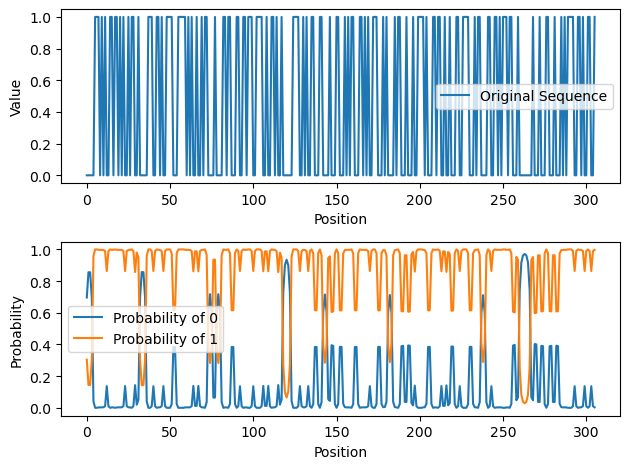

In [575]:
import matplotlib.pyplot as plt

# Filter for the positions with probability > 0.8 of observing a 0
start_idx = 2000
end_idx = 3000 

start_idx = np.where(predictions_df['pos'] == min(gene_df[(gene_df['gene_name'] == "SDHA") & (gene_df['start'].isin(pos_over_80))]['start']))[0][0]
end_idx = np.where(predictions_df['pos'] == max(gene_df[(gene_df['gene_name'] == "SDHA") & (gene_df['end'].isin(pos_over_80))]['end']))[0][0] - 1400 

# Plot the original sequence
plt.subplot(2, 1, 1)
plt.plot(observations[start_idx:end_idx], label='Original Sequence')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()

# Plot the predicted probabilities
plt.subplot(2, 1, 2)
plt.plot(probabilities[start_idx:end_idx, 0], label='Probability of 0')
plt.plot(probabilities[start_idx:end_idx, 1], label='Probability of 1')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

## Load Epilepsy, Schizophrenia, Bipolar, and Autism exome sequencing data 

### Autism analysis

In [380]:
import pandas as pd

# Read the data into a DataFrame
df = pd.read_csv('aut.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos','ref','alt']] = df['v'].str.split(':', expand=True)
df = df[df['chr'] == "2"]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)

# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.8]['pos'].to_numpy()
filtered_df_2 = df[(df['chr'] == 2) & (df['ac_ctrl'] < 30)]
# Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]

# Display the filtered DataFrame
print(filtered_df)

                      v          gene_id         consequence         hgvsc  \
161549     2:224888:G:A  ENSG00000035115    missense_variant      c.814C>T   
163314    2:8877092:T:G  ENSG00000134313    missense_variant     c.3623A>C   
163315    2:8877092:T:G  ENSG00000134313    missense_variant     c.3623A>C   
163911    2:9992099:A:C  ENSG00000115750      intron_variant  c.303+332A>C   
168495   2:24261163:A:C  ENSG00000163026    missense_variant     c.1202T>G   
...                 ...              ...                 ...           ...   
271694  2:239082125:G:C  ENSG00000132323      intron_variant   c.956+50C>G   
272239  2:240029815:G:A  ENSG00000068024  synonymous_variant     c.2028C>T   
272413  2:240500528:C:G  ENSG00000196758    missense_variant      c.409C>G   
273452  2:241816630:C:T  ENSG00000172482      intron_variant  c.847-324C>T   
273521  2:241872681:G:A  ENSG00000226321    missense_variant     c.1067G>A   

                 hgvsp        locus    alleles      mpc        

### Schizophrenia analysis

In [374]:
import pandas as pd

# Read the data into a DataFrame
df = pd.read_csv('scz.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df = df[df['chr'] == "2"]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)

# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.8]['pos'].to_numpy()
filtered_df_2 = df[(df['chr'] == 2) & (df['ac_ctrl'] < 5)]
# Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]

# Display the filtered DataFrame
print(filtered_df)

               locus                          alleles          gene_id  \
2372837     2:218942                        ["C","T"]  ENSG00000035115   
2372838     2:218942                        ["C","T"]  ENSG00000035115   
2373006     2:229973                        ["G","T"]  ENSG00000035115   
2373007     2:229973                        ["G","T"]  ENSG00000035115   
2373008     2:229977                        ["G","C"]  ENSG00000035115   
...              ...                              ...              ...   
4014432  2:241872175  ["GGGGGAGCCACGGCGCCCACTGA","G"]  ENSG00000226321   
4014476  2:241872593                        ["C","G"]  ENSG00000226321   
4014477  2:241872593                        ["C","G"]  ENSG00000226321   
4014504  2:241872680                        ["C","T"]  ENSG00000226321   
4014505  2:241872680                        ["C","T"]  ENSG00000226321   

                     consequence                               hgvsc  \
2372837  missense_variant_mpc_<2       

### Bipolar disease analysis

In [434]:
import pandas as pd

# File path
file_path = "BipEx_variant_results.tsv.bgz"

# Open the compressed file using gzip and read it into a pandas DataFrame
with gzip.open(file_path, 'rt') as file:
    df = pd.read_csv(file, sep='\t')

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df = df[df['chr'] == "chr2"]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)

# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()
filtered_df_2 = df[(df['chr'] == 2) & (df['ac_ctrl'] < 5)]
# Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]

# Display the filtered DataFrame
print(filtered_df)

                  locus    alleles          gene_id        consequence  \
2315284     chr2:224875  ["T","C"]  ENSG00000035115     other_missense   
2315285     chr2:224875  ["T","C"]  ENSG00000035115     other_missense   
2315286     chr2:224875  ["T","C"]  ENSG00000035115     other_missense   
2315287     chr2:224875  ["T","C"]  ENSG00000035115     other_missense   
2315292     chr2:224893  ["G","A"]  ENSG00000035115  damaging_missense   
...                 ...        ...              ...                ...   
3950034  chr2:241872899  ["G","A"]  ENSG00000188011         synonymous   
3950035  chr2:241872899  ["G","A"]  ENSG00000188011         synonymous   
3950036  chr2:241872899  ["G","A"]  ENSG00000188011         synonymous   
3950037  chr2:241872899  ["G","A"]  ENSG00000188011         synonymous   
3950038  chr2:241872899  ["G","A"]  ENSG00000188011         synonymous   

             hgvsc        hgvsp    cadd       mpc           polyphen  \
2315284   c.827A>G  p.His276Arg   8.245

### Epilepsy analysis 

In [568]:
import pandas as pd

# Read the data into a DataFrame
df = pd.read_csv('epi25_variant_results.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df = df[df['chr'] == "chr5"]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)

# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()
filtered_df_2 = df[(df['chr'] == 5) & (df['ac_ctrl'] < 5)]
# Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
filtered_df = filtered_df_2
filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]
#filtered_df = filtered_df[filtered_df['consequence'] != "synonymous"]
# Display the filtered DataFrame
print(filtered_df)

                  locus     alleles          gene_id     consequence  \
4703367     chr5:143077   ["C","T"]  ENSG00000153404  other_missense   
4703368     chr5:143077   ["C","T"]  ENSG00000153404  other_missense   
4703369     chr5:143077   ["C","T"]  ENSG00000153404  other_missense   
4703370     chr5:143077   ["C","T"]  ENSG00000153404  other_missense   
4703677     chr5:154889   ["C","T"]  ENSG00000153404      synonymous   
...                 ...         ...              ...             ...   
5502662  chr5:181260432  ["CT","C"]  ENSG00000183718            pLoF   
5502811  chr5:181260803   ["T","C"]  ENSG00000183718  other_missense   
5502812  chr5:181260803   ["T","C"]  ENSG00000183718  other_missense   
5502813  chr5:181260803   ["T","C"]  ENSG00000183718  other_missense   
5502814  chr5:181260803   ["T","C"]  ENSG00000183718  other_missense   

            hgvsc              hgvsp       mpc polyphen group  \
4703367  c.440C>T        p.Thr147Ile  0.099777   benign   DEE   
47033

In [625]:
import pandas as pd

# Read the data into a DataFrame
df = pd.read_csv('epi25_variant_results.tsv.gz', sep='\t')
# Reset the index before assigning values

df[['chr', 'pos']] = df['locus'].str.split(':', expand=True)
df = df[df['chr'] == "chr2"]
# Convert 'chr' and 'pos' columns to integers
df['chr'] = df['chr'].str.replace('chr', '').astype(int)
df['pos'] = df['pos'].astype(int)
      
# Filter for the positions with probability > 0.8 of observing a 0
pos_over_80 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()
filtered_df_2 = df[(df['chr'] == 2) & (df['ac_ctrl'] < 5)]
# Assuming you have another DataFrame 'df' with columns 'chrom' and 'position'
filtered_df = filtered_df_2
filtered_df = filtered_df_2[filtered_df_2['pos'].isin(pos_over_80)]
#filtered_df = filtered_df[filtered_df['consequence'] != "synonymous"]
# Display the filtered DataFrame
print(filtered_df)

                  locus    alleles          gene_id        consequence  \
1780044      chr2:45487  ["C","G"]  ENSG00000184731  damaging_missense   
1780045      chr2:45487  ["C","G"]  ENSG00000184731  damaging_missense   
1780046      chr2:45487  ["C","G"]  ENSG00000184731  damaging_missense   
1780047      chr2:45487  ["C","G"]  ENSG00000184731  damaging_missense   
1780068      chr2:45507  ["G","A"]  ENSG00000184731         synonymous   
...                 ...        ...              ...                ...   
3041834  chr2:241873090  ["C","A"]  ENSG00000188011     other_missense   
3041835  chr2:241873090  ["C","A"]  ENSG00000188011     other_missense   
3041836  chr2:241873090  ["C","A"]  ENSG00000188011     other_missense   
3041924  chr2:241873182  ["G","T"]  ENSG00000188011     other_missense   
3041925  chr2:241873182  ["G","T"]  ENSG00000188011     other_missense   

             hgvsc        hgvsp      mpc           polyphen group  \
1780044   c.899G>C  p.Cys300Ser  1.87580  

In [626]:
# Calculate total counts for cases and controls
filtered_df['total_ac_case'] = filtered_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
filtered_df['total_an_case'] = filtered_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
filtered_df['total_ac_ctrl'] = filtered_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
filtered_df['total_an_ctrl'] = filtered_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')


/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

In [627]:
# Remove duplicate rows for unique combinations of 'gene_id' and 'group'
unique_combinations = filtered_df[['gene_id', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()


In [628]:
print(unique_combinations)

                 gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
1780044  ENSG00000184731   DEE            0.0         3876.0            2.0   
1780045  ENSG00000184731   EPI            1.0        41958.0            2.0   
1780046  ENSG00000184731   GGE            1.0        10998.0            2.0   
1780047  ENSG00000184731  NAFE            0.0        18438.0            2.0   
1780383  ENSG00000035115   DEE            0.0         3876.0            7.0   
...                  ...   ...            ...            ...            ...   
3040223  ENSG00000188389  NAFE            3.0        18438.0            7.0   
3040758  ENSG00000188011   EPI            9.0        41958.0            8.0   
3040759  ENSG00000188011  NAFE            4.0        18438.0            8.0   
3040889  ENSG00000188011   GGE            4.0        10998.0            8.0   
3041075  ENSG00000188011   DEE            0.0         3876.0            8.0   

         total_an_ctrl  
1780044        66888.0  
1

In [629]:
from scipy.stats import fisher_exact
import math
def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value



In [630]:
# Remove duplicate rows for unique combinations of 'gene_id' and 'group'
unique_combinations = filtered_df[['gene_id',  'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

# Apply Fisher's exact test for each unique combination
results = unique_combinations.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1)

# Add the results to the DataFrame
unique_combinations[['odds_ratio', 'p_value']] = pd.DataFrame(results.tolist(), index=unique_combinations.index)

# Sort the DataFrame by 'p_value' in increasing order
sorted_df = unique_combinations.sort_values(by='p_value')

# Display the sorted DataFrame
print(sorted_df[sorted_df['p_value'] < .0001])

Negative values detected: gene=nan, ac_case=nan, an_case=nan, ac_ctrl=nan, an_ctrl=nan
Negative values detected: gene=nan, ac_case=nan, an_case=nan, ac_ctrl=nan, an_ctrl=nan
Negative values detected: gene=nan, ac_case=nan, an_case=nan, ac_ctrl=nan, an_ctrl=nan
Negative values detected: gene=nan, ac_case=nan, an_case=nan, ac_ctrl=nan, an_ctrl=nan
                 gene_id group  total_ac_case  total_an_case  total_ac_ctrl  \
2517579  ENSG00000144285   DEE           22.0         3876.0           32.0   
2517535  ENSG00000144285   EPI           80.0        41958.0           32.0   
2592665  ENSG00000155657   EPI          396.0        41958.0          457.0   
2517582  ENSG00000144285  NAFE           30.0        18438.0           32.0   
2787825  ENSG00000144406   EPI           53.0        41958.0           32.0   
2815630  ENSG00000138375   EPI           17.0        41958.0            3.0   
2787827  ENSG00000144406  NAFE           27.0        18438.0           32.0   

         total_an_c

/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/bonanza/anaconda3/envs/ieu-gwas-db-demo/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


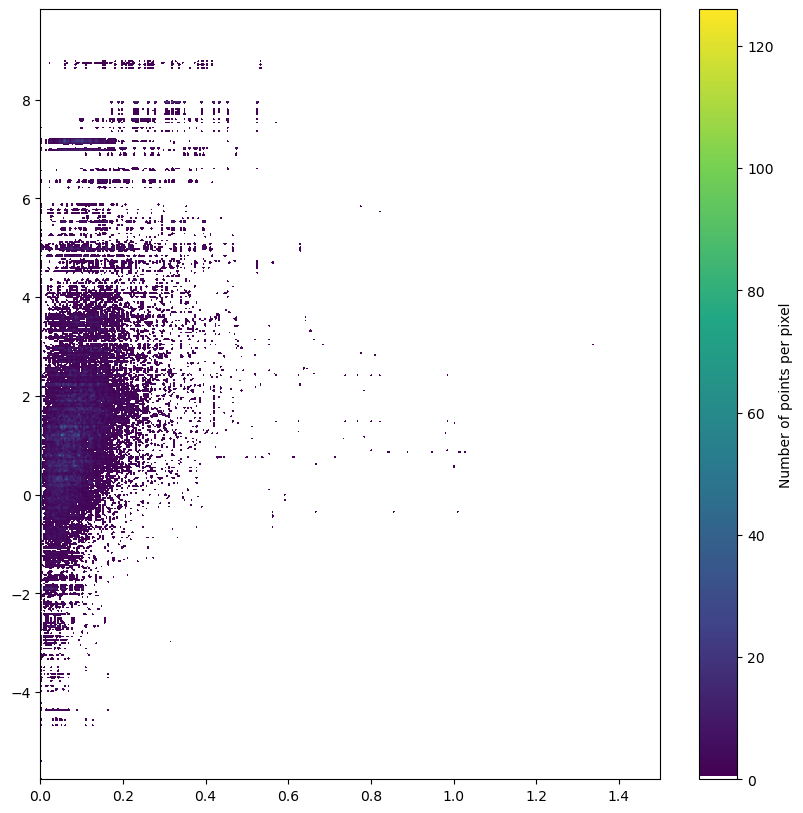

In [364]:
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
   # plt.xlim([0,200])
   # plt.ylim([0,3000])
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure(figsize=(10,10))
using_mpl_scatter_density(fig, merged_df['proportion_over_80'], merged_df['mis.z_score'])
plt.show()

In [365]:
# Remove rows with missing or infinite values
df_cleaned = merged_df.replace([np.inf, -np.inf], np.nan).dropna()

# Add a constant term to the independent variable for the intercept
X = sm.add_constant(df_cleaned['proportion_over_80'])

# Fit the linear regression model
model3 = sm.OLS(df_cleaned['mis.z_score'], X).fit()

model3.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

# Get the summary of the regression
print(model3.summary())

# Extract the F-statistic and its associated p-value
f_statistic = model3.fvalue
p_value_f_statistic = model3.f_pvalue

                            OLS Regression Results                            
Dep. Variable:            mis.z_score   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     9703.
Date:                Wed, 27 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:42:29   Log-Likelihood:                -99141.
No. Observations:               46966   AIC:                         1.983e+05
Df Residuals:                   46964   BIC:                         1.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8117      0

# Fit HMM to simluated sequence

##Genomic Sequence Generation with Biased Mutations

This Python code generates a random genomic sequence with biased probabilities for the presence of mutations. It uses the `hmmlearn` library to simulate a genomic sequence of a specified length (`sequence_length`) with a given mutation probability (`mutation_probability`).

Parameters:
- sequence_length: Length of the genomic sequence (default: 5,000,000 base pairs).
- mutation_probability: Probability of a mutation (1) in the sequence (default: 0.25).

Code Explanation:

1. Import necessary libraries:
   ```python
   import numpy as np
   from hmmlearn import hmm

2. Set the parameters:
  ```python
   sequence_length = 5000000  # Length of the genomic sequence
   mutation_probability = 0.25  # Probability of a mutation (1) in the sequence

3. Generate a random sequence with biased probabilities:
  ```python
   sequence = np.random.choice([0, 1], size=sequence_length, p=[1-mutation_probability, mutation_probability])

4. Define regions with low probability of 1s:
  ```python
   low_prob_regions = np.arange(0, sequence_length, 10000)

5. Add additional mutations within low-probability regions:
  ```python
   for region in low_prob_regions:
       sequence[region:region+1000] = np.random.choice([0, 1], size=1000, p=[0.99, .01])

6. Display the first 100 elements of the generated sequence:
  ```python
   print(sequence[:100])

This code is useful for simulating genomic sequences with biased mutation patterns for testing and experimentation.


In [ ]:
import numpy as np
from hmmlearn import hmm

sequence_length = 100000000
mutation_probability = 0.99

# Generate random sequence with biased probabilities
sequence = np.random.choice([0, 1], size=sequence_length, p=[1-mutation_probability, mutation_probability])

# Define regions with low probability of 1s (e.g., every 200 positions)
low_prob_regions = np.arange(0, sequence_length, 10000)

# Add additional mutations within low-probability regions
for region in low_prob_regions:
    sequence[region:region+1000] = np.random.choice([0, 1], size=1000, p=[0.99, .01])

observations = np.array(sequence)

In [ ]:
# Flatten the higher-order structure
order = 2  # Set the desired order
# X = np.array([observations[i:i+order] for i in range(len(observations)-order)])
X = np.stack([observations[i:i-order] for i in range(order)], axis=1) # Changed this line due to RAM constraint

# Convert observations to counts
X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

# Create and fit a first-order HMM
model = hmm.MultinomialHMM(n_components=2)
model.fit(X_counts)

# Predict probabilities for each position
probabilities = model.predict_proba(X_counts)

# Display results
print("Probabilities:", probabilities[:, 0])

## Flatten the higher-order structure
The Python code below sets the desired order of the hidden Markov model (HMM) to 2 and creates a flattened array X from the original sequence observations. It captures sequences of length 'order' from the observations.

## Convert observations to counts
The flattened array X is then converted to counts and stored in X_counts. This step counts the occurrences of 0s and 1s in each sequence of length 'order'.

## Create and fit a first-order HMM
A first-order HMM with 2 hidden states is created using the `hmmlearn` library. The model is fitted to the count data (X_counts).

## Predict probabilities for each position
The model predicts probabilities for each position in the sequence based on the fitted HMM. The result is stored in the 'probabilities' variable.

## Display results
The code prints the probabilities corresponding to the first hidden state (index 0) for each position in the sequence.


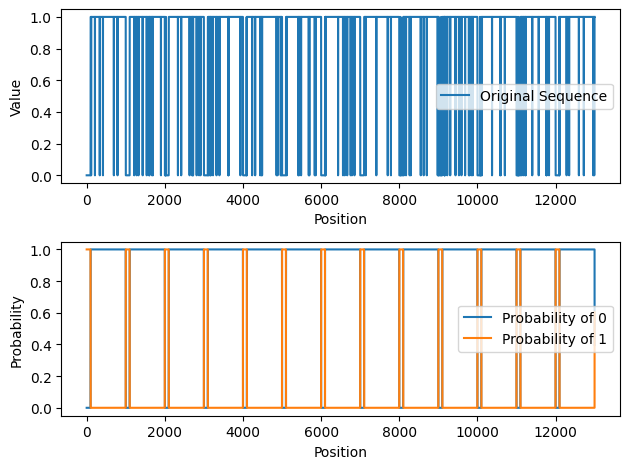

In [ ]:
import matplotlib.pyplot as plt

# Plot the original sequence
plt.subplot(2, 1, 1)
plt.plot(observations[0:13000], label='Original Sequence')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()

# Plot the predicted probabilities
plt.subplot(2, 1, 2)
plt.plot(probabilities[0:13000, 0], label='Probability of 0')
plt.plot(probabilities[0:13000, 1], label='Probability of 1')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
positions = np.arange(1,sequence_length-1, 1)
probs = probabilities[:, 1]
filtered_values = positions[probs < 0.1]

## Baum-Welch Algorithm for Hidden Markov Models (HMM)

### Model Components:
- States (S): Hidden states representing the system's transitions (e.g., 0 and 1).
- Observations (O): Visible outcomes associated with each state (e.g., binary mutations).

### Parameters:
1. Transition Probability Matrix (A): Probability of transitioning between states.
2. Emission Probability Matrix (B): Probability of observing outcomes given the states.
3. Initial State Distribution (π): Probability distribution of starting in each state.

## Baum-Welch Steps:

### E-step (Expectation):
1. **Forward Algorithm:**
   - Compute the probability of observing the sequence up to time $t$ and being in state $i$ at time $t$ (forward probabilities).
     - Forward probabilities: $\(\alpha_t(i) = P(O_1, O_2, ..., O_t, X_t=i | \lambda))$.

2. **Backward Algorithm:**
   - Compute the probability of observing the sequence from time t+1 to the end, given being in state $i$ at time $t$ (backward probabilities).
     - Backward probabilities: $\(\beta_t(i) = P(O_{t+1}, O_{t+2}, ..., O_T | X_t=i, \lambda)\)$.

3. **Compute Gamma $(\gamma)$:**
   - Probability of being in state $i$ at time $t$ given the observations.
     - $\left(\gamma_t(i) = \frac{\alpha_t(i) \cdot \beta_t(i)}{\sum_{j=1}^{N} \alpha_t(j) \cdot \beta_t(j)}\right)$.

4. **Compute $Xi (\xi)$:**
   - Joint probability of being in state i at time t and state j at time t+1 given the observations.
     - $\left(\xi_t(i, j) = \frac{\alpha_t(i) \cdot A(i, j) \cdot B(j, O_{t+1}) \cdot \beta_{t+1}(j)}{\sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_t(i) \cdot A(i, j) \cdot B(j, O_{t+1}) \cdot \beta_{t+1}(j)}\right)$.

### M-step (Maximization):
1. **Update Initial State Distribution $(\pi)$:**
   - Set $\left(\pi(i) = \gamma_1(i)\right)$, the average probability of being in state i at time 0 across all sequences.

2. **Update Transition Probability Matrix ($A$):**
   - Set $\left(A(i, j) = \frac{\sum_{t=1}^{T-1} \xi_t(i, j)}{\sum_{t=1}^{T-1} \gamma_t(i)}\right)$, the expected number of transitions from state i to state j divided by the expected number of transitions from state i.

3. **Update Emission Probability Matrix ($B$):**
   - Set $\left(B(i, o) = \frac{\sum_{t=1}^{T} \gamma_t(i) \cdot I(O_t = o)}{\sum_{t=1}^{T} \gamma_t(i)}\right)$, the expected number of times in state $i$ and observing outcome $o$ divided by the expected number of times in state $i$.

4. **Normalization:**
   - Normalize the rows of $A$ and $B$ to ensure they sum to 1.

5. **Log-Likelihood:**
   - Evaluate the log-likelihood of the observed sequences given the current parameters.
     - Log-Likelihood: $\left(P(O | \lambda) = \sum_{i=1}^{N} \alpha_T(i)\right)$.

# Conclusion:
The Baum-Welch algorithm iteratively refines the parameters until convergence, maximizing the likelihood of the observed sequences given the HMM.


# Fit HMM to simluated sequence

##Genomic Sequence Generation with Biased Mutations

This Python code generates a random genomic sequence with biased probabilities for the presence of mutations. It uses the `hmmlearn` library to simulate a genomic sequence of a specified length (`sequence_length`) with a given mutation probability (`mutation_probability`).

Parameters:
- sequence_length: Length of the genomic sequence (default: 5,000,000 base pairs).
- mutation_probability: Probability of a mutation (1) in the sequence (default: 0.25).

Code Explanation:

1. Import necessary libraries:
   ```python
   import numpy as np
   from hmmlearn import hmm

2. Set the parameters:
  ```python
   sequence_length = 5000000  # Length of the genomic sequence
   mutation_probability = 0.25  # Probability of a mutation (1) in the sequence

3. Generate a random sequence with biased probabilities:
  ```python
   sequence = np.random.choice([0, 1], size=sequence_length, p=[1-mutation_probability, mutation_probability])

4. Define regions with low probability of 1s:
  ```python
   low_prob_regions = np.arange(0, sequence_length, 10000)

5. Add additional mutations within low-probability regions:
  ```python
   for region in low_prob_regions:
       sequence[region:region+1000] = np.random.choice([0, 1], size=1000, p=[0.99, .01])

6. Display the first 100 elements of the generated sequence:
  ```python
   print(sequence[:100])

This code is useful for simulating genomic sequences with biased mutation patterns for testing and experimentation.


In [ ]:
import numpy as np
from hmmlearn import hmm

sequence_length = 100000000
mutation_probability = 0.99

# Generate random sequence with biased probabilities
sequence = np.random.choice([0, 1], size=sequence_length, p=[1-mutation_probability, mutation_probability])

# Define regions with low probability of 1s (e.g., every 200 positions)
low_prob_regions = np.arange(0, sequence_length, 10000)

# Add additional mutations within low-probability regions
for region in low_prob_regions:
    sequence[region:region+1000] = np.random.choice([0, 1], size=1000, p=[0.99, .01])

observations = np.array(sequence)

In [ ]:
# Flatten the higher-order structure
order = 2  # Set the desired order
# X = np.array([observations[i:i+order] for i in range(len(observations)-order)])
X = np.stack([observations[i:i-order] for i in range(order)], axis=1) # Changed this line due to RAM constraint

# Convert observations to counts
X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

# Create and fit a first-order HMM
model = hmm.MultinomialHMM(n_components=2)
model.fit(X_counts)

# Predict probabilities for each position
probabilities = model.predict_proba(X_counts)

# Display results
print("Probabilities:", probabilities[:, 0])

## Flatten the higher-order structure
The Python code below sets the desired order of the hidden Markov model (HMM) to 2 and creates a flattened array X from the original sequence observations. It captures sequences of length 'order' from the observations.

## Convert observations to counts
The flattened array X is then converted to counts and stored in X_counts. This step counts the occurrences of 0s and 1s in each sequence of length 'order'.

## Create and fit a first-order HMM
A first-order HMM with 2 hidden states is created using the `hmmlearn` library. The model is fitted to the count data (X_counts).

## Predict probabilities for each position
The model predicts probabilities for each position in the sequence based on the fitted HMM. The result is stored in the 'probabilities' variable.

## Display results
The code prints the probabilities corresponding to the first hidden state (index 0) for each position in the sequence.


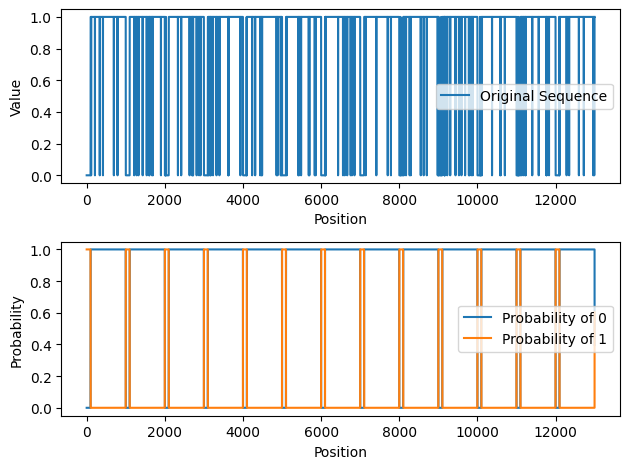

In [ ]:
import matplotlib.pyplot as plt

# Plot the original sequence
plt.subplot(2, 1, 1)
plt.plot(observations[0:13000], label='Original Sequence')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()

# Plot the predicted probabilities
plt.subplot(2, 1, 2)
plt.plot(probabilities[0:13000, 0], label='Probability of 0')
plt.plot(probabilities[0:13000, 1], label='Probability of 1')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
positions = np.arange(1,sequence_length-1, 1)
probs = probabilities[:, 1]
filtered_values = positions[probs < 0.1]

## Plotting Original Sequence and Predicted Probabilities

This Python code snippet utilizes Matplotlib to create a side-by-side plot of the original genomic sequence and the predicted probabilities from a Hidden Markov Model (HMM).

1. Plotting the Original Sequence:
   - Subplot 1 (top): Displays the original sequence (observations) up to position 13,000.
   - X-axis: Position in the sequence.
   - Y-axis: Value (0 or 1) at each position.
   - Legend: "Original Sequence."

2. Plotting the Predicted Probabilities:
   - Subplot 2 (bottom): Shows the predicted probabilities for both 0 and 1 states up to position 13,000.
   - X-axis: Position in the sequence.
   - Y-axis: Probability values.
   - Legends: "Probability of 0" and "Probability of 1."

3. Adjusting Layout:
   - `plt.tight_layout()`: Adjusts subplot parameters for better layout.

4. Display the Plot:
   - `plt.show()`: Displays the side-by-side plot containing the original sequence and predicted probabilities.

This visualization helps compare the actual sequence values with the probabilities predicted by the HMM at each position.


# Filtering Positions with Low Probabilities

This code snippet performs filtering on positions based on the predicted probabilities from an earlier Hidden Markov Model (HMM).

1. Creating an Array of Positions:
   - `positions`: Generates an array of positions ranging from 1 to `sequence_length-1` with a step size of 1.

2. Extracting Probabilities for State 1:
   - `probs`: Extracts the predicted probabilities for state 1 (presence of mutation) from the previously computed `probabilities` array.

3. Filtering Positions with Low Probabilities:
   - `filtered_values`: Filters positions where the probability of state 1 is less than 0.1.
   - Uses boolean indexing to select positions meeting the condition.

This code is useful for identifying genomic positions where the predicted probability of a specific state (e.g., presence of mutation) is below a certain threshold.


# **Relevance of LSTM/RNN:**
In this UK Biobank whole genome sequencing data we can represent the data exhibiting a sequential or temporal nature. The presence or absence of mutations at a given position can be influenced by the mutations at preceding positions. Traditional machine learning models, like standard HMMs (Hidden Markov Models), may struggle to capture these long-range dependencies effectively.

# **Mathematical Derivation:**
Consider a genomic sequence $(X = \{x_1, x_2, ..., x_T\})$, where \(x_t\) represents the presence (1) or absence (0) of a mutation at position \(t\). The key idea behind RNNs and LSTMs is to maintain a hidden state that captures information from previous time steps.

## **Vanilla RNN Update Equation:**
\[ $h_t$ = $\sigma(W_{hx} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h) ]$
where:
- \($h_t$\) is the hidden state at time \(t\),
- \($\sigma$\) is the activation function (commonly the sigmoid function),
- \($W_{hx}$\) is the weight matrix for the input,
- \($W_{hh}$\) is the weight matrix for the recurrent connection, and
- \($b_h$\) is the bias term.

## **LSTM Update Equations:**

\begin{align*}
f_t & = \sigma(W_{fx} \cdot x_t + W_{fh} \cdot h_{t-1} + b_f) \\
i_t & = \sigma(W_{ix} \cdot x_t + W_{ih} \cdot h_{t-1} + b_i) \\
o_t & = \sigma(W_{ox} \cdot x_t + W_{oh} \cdot h_{t-1} + b_o) \\
c_t & = f_t \odot c_{t-1} + i_t \odot \tanh(W_{cx} \cdot x_t + W_{ch} \cdot h_{t-1} + b_c) \\
h_t & = o_t \odot \tanh(c_t)
\end{align*}

where:
- \($f_t$, $i_t$, $o_t$\) are the forget, input, and output gates, respectively,
- \($\odot$\) denotes element-wise multiplication, and
- \($c_t$\) is the cell state.

# **Algorithm Description:**

1. **Data Preparation:**
   - Prepare the genomic sequence as a time series, with each position representing a time step.
   - Label the data based on the presence or absence of mutations.

2. **Model Architecture:**
   - Design an LSTM or RNN model architecture.
   - Configure the number of hidden units, activation functions, and output layer.

3. **Compile Model:**
   - Choose appropriate loss function and optimizer.
   - Compile the model.

4. **Train Model:**
   - Train the model on the prepared genomic sequence data.
   - Adjust hyperparameters like batch size and epochs.

5. **Prediction:**
   - Utilize the trained model to predict the probabilities of mutations at each position.

6. **Evaluation:**
   - Assess the model's performance using relevant metrics (accuracy, precision, recall).


In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense

X = np.array([observations[i:i+order] for i in range(len(observations)-order)])
y = observations[order:]  # Target labels

# Reshape X to match LSTM input shape (samples, timesteps, features)
X_lstm = X.reshape(X.shape[0], 1, X.shape[1])

# Convert target labels to categorical format
y_categorical = to_categorical(y)

# Build an LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(8, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model
model_lstm.fit(X_lstm, y_categorical, epochs=5, batch_size=32)

# Predict probabilities for each position
probabilities_lstm = model_lstm.predict(X_lstm)

# Display results
print("Probabilities:", probabilities_lstm[:, 0])

Epoch 1/5
312500/312500 [==============================] - 1197s 4ms/step - loss: 0.0732 - accuracy: 0.9848
Epoch 2/5
312500/312500 [==============================] - 1161s 4ms/step - loss: 0.0727 - accuracy: 0.9850
Epoch 3/5
312500/312500 [==============================] - 1188s 4ms/step - loss: 0.0727 - accuracy: 0.9850
Epoch 4/5
312500/312500 [==============================] - 1221s 4ms/step - loss: 0.0727 - accuracy: 0.9850
Epoch 5/5
312500/312500 [==============================] - 788s 3ms/step
Probabilities: [0.9768276 0.9768276 0.9768276 ... 0.0114703 0.0114703 0.0114703]


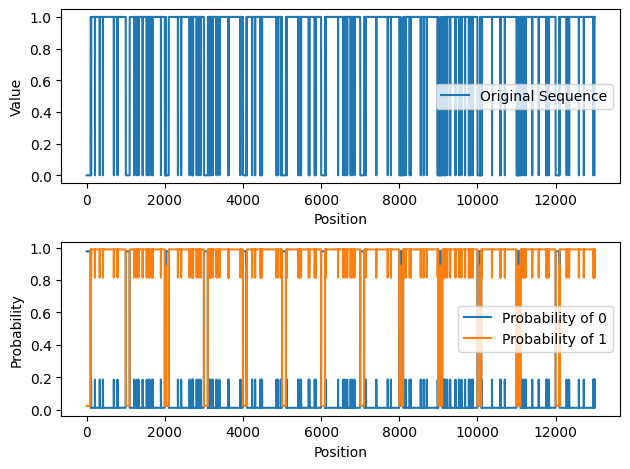

In [ ]:
import matplotlib.pyplot as plt

# Plot the original sequence
plt.subplot(2, 1, 1)
plt.plot(observations[0:13000], label='Original Sequence')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()

# Plot the predicted probabilities
plt.subplot(2, 1, 2)
plt.plot(probabilities_lstm[0:13000, 0], label='Probability of 0')
plt.plot(probabilities_lstm[0:13000, 1], label='Probability of 1')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

From the probabilities generated by the LSTM we see that the model is being overfit, i.e. there is no smooth transition in the probabilities across the genome.

In [577]:
import numpy as np
from transformers import pipeline
import torch

In [578]:
print(len(observations))

1480861


In [582]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Function to apply the transformer model
def transformer_model(sequence):
    # Convert each item in the sequence to a binary string
    binary_strings = [str(bit) for bit in sequence]

    # Load pre-trained DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

    # Tokenize and pad the input sequences
    inputs = tokenizer(binary_strings, return_tensors="pt", truncation=True, padding=True)

    # Forward pass through the model
    outputs = model(**inputs)

    # Extract probabilities for class 1
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    probabilities_class_1 = probabilities[:, 1].tolist()

    return probabilities_class_1

# Example usage
transformer_probs = transformer_model(observations)
print("Transformer probabilities:", [1 - prob for prob in transformer_probs])


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

KeyboardInterrupt: 



### Transformer Relevance for Sequence Data

**Introduction:**
The transformer architecture, introduced by Vaswani et al. in the paper "Attention is All You Need," has become a cornerstone in natural language processing and sequential data modeling. It stands out for its parallelization capabilities, which allow it to efficiently capture dependencies between distant elements in a sequence.

**Key Components:**
1. **Self-Attention Mechanism:**
   - Transformers leverage a self-attention mechanism to weigh different positions in a sequence differently during computation.
   - This mechanism allows the model to focus on relevant parts of the input sequence while considering the context of each element.

2. **Positional Encoding:**
   - Transformers do not inherently understand the order of elements in a sequence, so positional encodings are added to the input embeddings to provide information about the position of each element.

3. **Multi-Head Attention:**
   - Multiple attention heads enable the model to learn different relationships in parallel, enhancing its ability to capture various dependencies.

4. **Feedforward Networks:**
   - Each attention output is passed through a feedforward network, allowing the model to capture complex patterns and non-linear relationships in the data.

**Relevance to the Problem:**
In the context of genetic sequences or any sequence data with dependencies across long distances, transformers can provide significant advantages.

**Mathematical Formulation:**
Let \(X\) be the input sequence of length \(T\) with elements \($x_1, x_2, ..., x_T$\). The transformer processes this sequence through the following steps:

1. **Embedding:**
   $\text{Embedding}: x_i \rightarrow \text{Embedding}(x_i)$

2. **Positional Encoding:**
    $\text{Positional Encoding}: \text{Embedding}(x_i) \rightarrow \text{Positional Encoding}(\text{Embedding}(x_i))$

3. **Self-Attention Mechanism:**
    $\text{Multi-Head Attention}:  \text{Positional Encoding}(\text{Embedding}(x_1), ..., \text{Positional Encoding}(\text{Embedding}(x_T)) \rightarrow \text{Attention Output}$

4. **Feedforward Networks:**
   $\text{Feedforward Networks}: \ \text{Attention Output} \rightarrow \text{Output Probabilities}$

**Algorithm Description:**
1. Tokenize the input sequence and obtain embeddings.
2. Add positional encodings to the embeddings to capture sequence order.
3. Apply multi-head self-attention to the sequence.
4. Pass the attention output through feedforward networks.
5. Obtain output probabilities for each position in the sequence.

**Conclusion:**
Transformers provide an effective and scalable solution for modeling dependencies in sequences. Their self-attention mechanism enables them to capture long-range dependencies, making them well-suited for tasks involving genetic sequences, where the presence or absence of mutations at one position can depend on positions far away.

---